In [2]:
import glob
import os
from collections import Counter
from itertools import combinations, product

import numpy as np
np.random.seed(18012023)

import pandas as pd
pd.set_option('display.max_colwidth', 0)

import seaborn as sb

from sklearn.metrics import pairwise_distances
import lxml.etree
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'
from IPython.display import display

## Loading and preprocessing

##### Length distribution of the intertexts

In [3]:
intertexts = pd.read_excel('../data/intertexts.xlsx')
intertexts.sample(5)

ID                         source  \
97   mor-mou-16  Moriaen                         
145  lan-ele-21  Lantsloot van der Haghedochte   
8    mor-ele-9   Moriaen                         
84   mor-mou-4   Moriaen                         
25   mor-ele-26  Moriaen                         

                                                      src-passage  \
97   Hie deetse bat achtergaen.                                     
145  Mar ic segghe v dat ic v rade Omme te bescuwene meere scade:   
8    God hi mach v wel gesterken.                                   
84   Doe hi achters van u sciet                                     
25   En ontfinc noit vlecge no scard.                               

                    target  \
97   Riddere metter mouwen   
145  Moriaen                 
8    Karel ende Elegast      
84   Riddere metter mouwen   
25   Karel ende Elegast      

                                                trg-passage  verse-length  \
97   Ende dadense also achtergaen.                           1              
145  oft gi werken wilt bi rade Ende scuwen wilt vwe scade.  2              
8    Nv so moetti - God - mi gestercken:                     1              
84   Doe hi achters van hem sciet                            1              
25   Ende ontfingen scarde ende vlegghen:                    1              

                         biblio remarks  \
97   Van der Stempel 1930        NaN      
145  NaN                         NaN      
8    Heeroma 1973a, Moriaen (I)  NaN      
84   Van der Stempel 1917        NaN      
25   Heeroma 1973a, Moriaen (I)  NaN      

                                          Unnamed: 8  
97   Editions have achterstaen. Might not be a link.  
145  NaN                                              
8    NaN                                              
84   Double case                                      
25   NaN

In [4]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

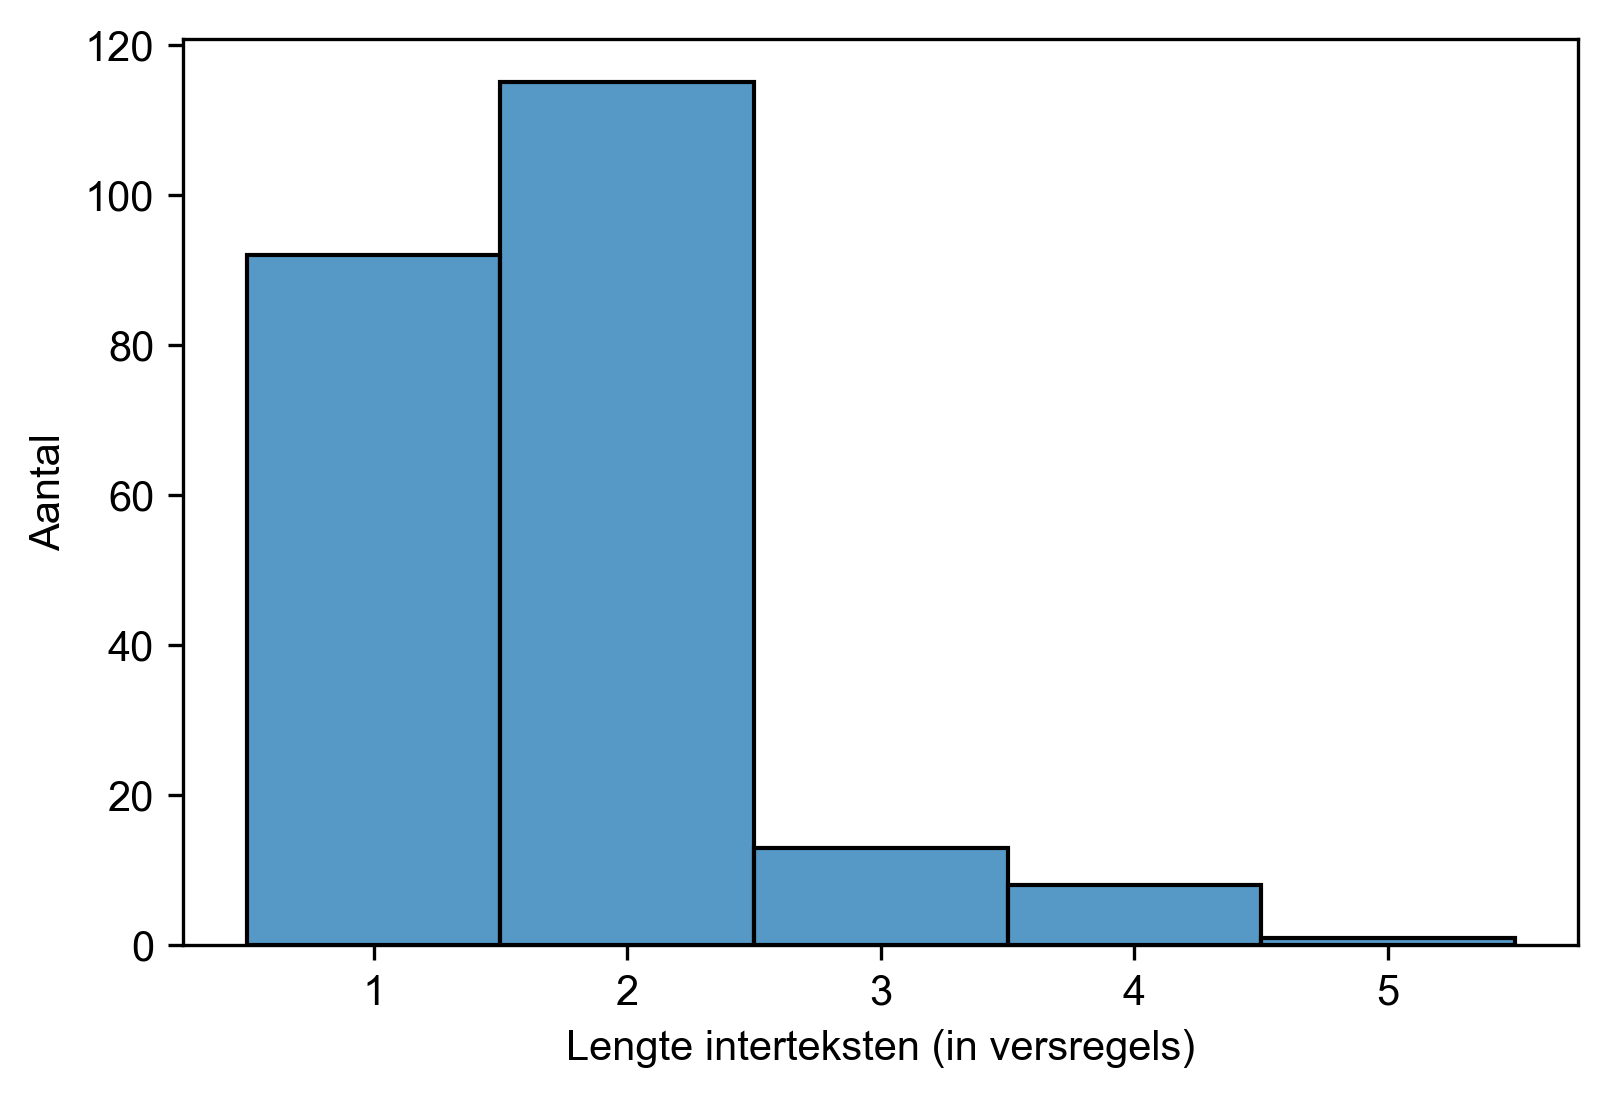

In [5]:
sb.histplot(data=intertexts, x="verse-length", discrete=True)
plt.xlabel('Lengte interteksten (in versregels)')
plt.ylabel('Aantal')
plt.savefig(f'{fig_dir}/intertext_dist.png', transparent=True);

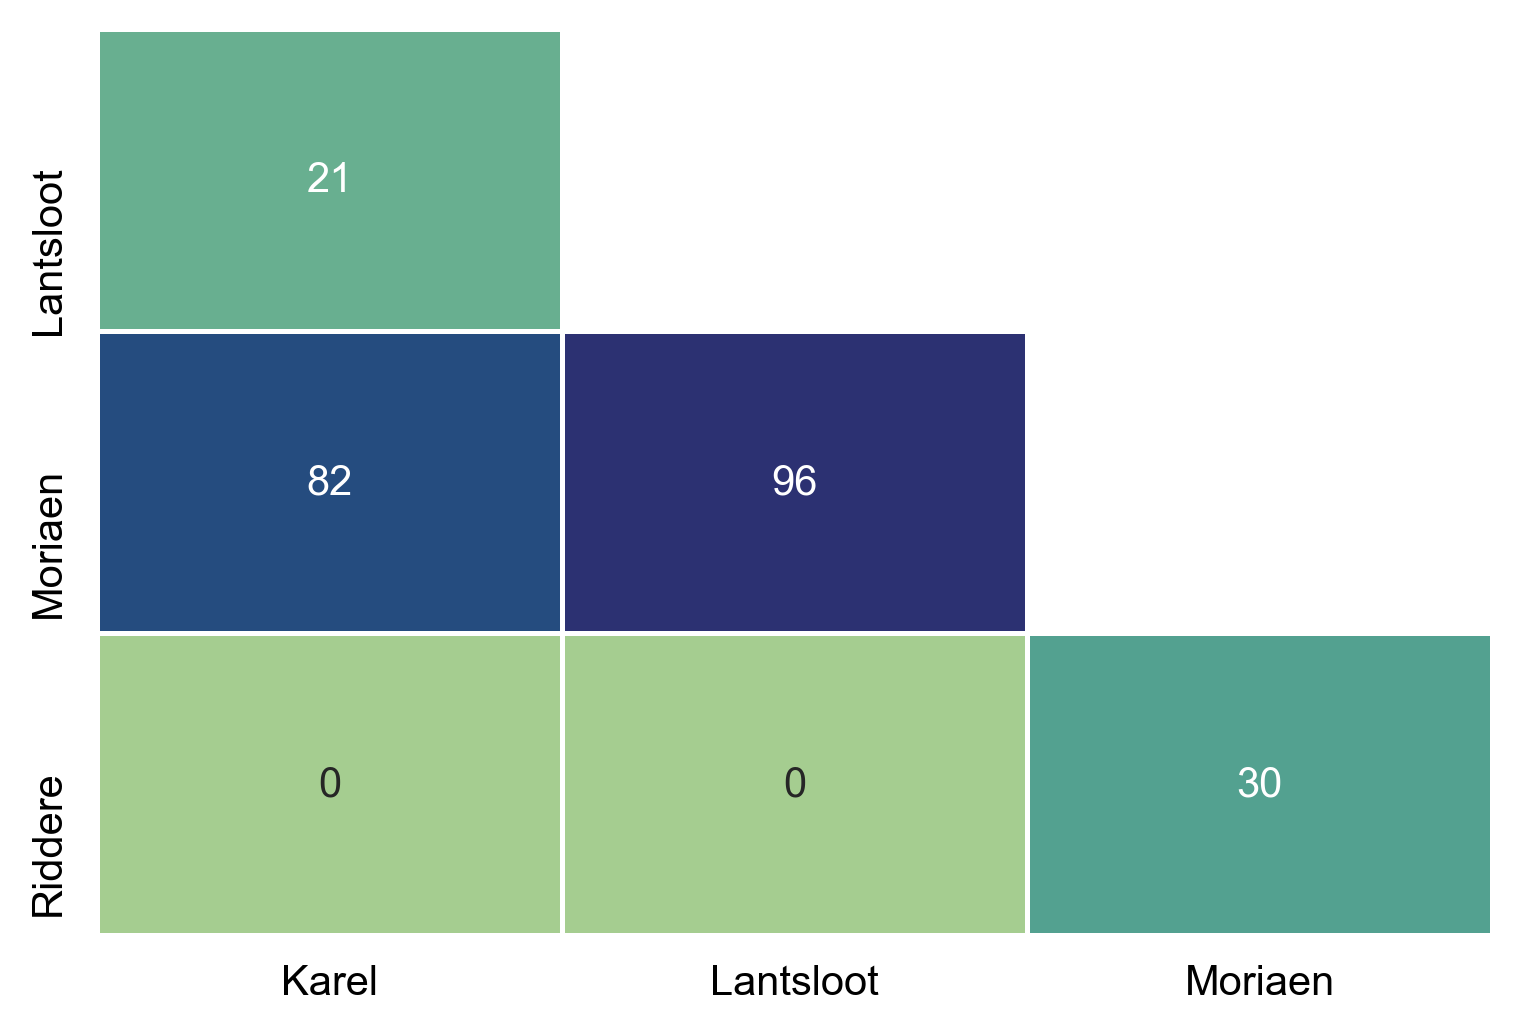

In [6]:
titles = sorted(set(intertexts['source'].tolist() + intertexts['target'].tolist()))
counts = np.zeros((len(titles), len(titles)))
for _, row in intertexts.iterrows():
    counts[titles.index(row['source']), titles.index(row['target'])] += 1
    counts[titles.index(row['target']), titles.index(row['source'])] += 1
np.fill_diagonal(counts, np.nan)
counts[np.triu_indices(4)] = np.nan
titles = [t.split()[0] for t in titles]
counts = pd.DataFrame(counts, columns=titles, index=titles)
counts = counts.iloc[1:, :-1]
ax = sb.heatmap(counts, annot=True, cmap='crest', cbar=False, linewidths=1, linecolor='white')
ax.tick_params(left=False, bottom=False)
for l in plt.gca().lines:
    l.set_alpha(0.3)
plt.savefig(f'{fig_dir}/intertext_links.png', transparent=True);

#### Load metadata

In [7]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

id                                   title  \
9    barlaam_en_josaphat_fragm_ge     Barlaam en Josaphat                      
275  roman_van_walewein               Walewein                                 
216  spiegel_historiael__2_fragm_l    Spiegel historiael (P2)                  
120  madelgijs_fragm_be               Madelgijs                                
37   collectief_lunarium_ii           Collectief lunarium II                   
174  Rijmbijbel                       Rijmbijbel                               
35   collectief_lunarium_iii          Collectief lunarium III                  
255  van_den_vijf_vrouden             Van den vijf vrouden                     
72   gedichten_hildegaersberch__hs_g  Gedichten (Willem van Hildegaersberch)   
252  van_den_neghen_besten__lang      Van den neghen besten (lang)             

                         author    date provenance date_range   genre  \
9    NaN                         1325.0  cdrom-mnl  1300-1350  Epiek    
275  Penninc en Pieter Vostaert  1350.0  cdrom-mnl  1350-1350  Epiek    
216  Philip Utenbroeke           1337.5  cdrom-mnl  1325-1350  Epiek    
120  NaN                         1350.0  cdrom-mnl  1340-1360  Epiek    
37   NaN                         1435.0  cdrom-mnl  1434-1436  Epiek    
174  NaN                         1285.0  CG1        1285-1285  Epiek    
35   NaN                         1450.0  cdrom-mnl  1440-1460  Epiek    
255  NaN                         1339.0  cdrom-mnl  1339-1339  Epiek    
72   Willem van Hildegaersberch  1480.0  cdrom-mnl  1470-1490  Lyriek   
252  NaN                         1465.0  cdrom-mnl  1460-1470  Epiek    

           subgenre exclude  
9    Ridder          NaN     
275  Arthur          NaN     
216  Historiografie  NaN     
120  Karel           NaN     
37   Didactiek       NaN     
174  Religie         NaN     
35   Didactiek       NaN     
255  Didactiek       NaN     
72   NaN             NaN     
252  Didactiek       NaN

In [8]:
def get_verse_groups(verses, size=2, intertexts=False):
    for i in range(len(verses) - (size - 1)):
        if not intertexts:
            yield ' / '.join(verses[i : i + size])
        else:
            its = Counter(verses[i : i + size])
            if None in its:
                yield None
            elif len(its) > 1:
                yield 'overlap'
            else:
                yield list(its.keys())[0]

In [9]:
def parse_xml(fn, rm_interpol=False):
    try:
        tree = lxml.etree.parse(fn)
    except OSError:
        print(f'- Could not load {fn}')
        return None
        
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
        
    for line_node in tree.iterfind('//l'):
        try:
            intertext_id = line_node.attrib['intertext']
        except KeyError:
            intertext_id = None
        
        tokens_ = line_node.attrib['tokens'].split()
        lemmas_ = []
        
        lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'n(prop)':
                        lemmas_.append('n(prop)')
                    else:
                        lemmas_.append(l)
    
        yield tokens_, lemmas_, intertext_id

In [10]:
GROUP_SIZE = 2

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(meta_df.groupby('title')):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        for tok, lem, intertext_id in parse_xml(f'../data/xml/{id_}.xml'):
            work_tokens.append(tok)
            work_lemmas.append(lem)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

100%|██████████| 205/205 [00:32<00:00,  6.32it/s]


In [11]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
df = df[df['intertext'] != 'overlap']
df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

title  \
340350  Karel ende Elegast   
340386  Karel ende Elegast   
340398  Karel ende Elegast   
340437  Karel ende Elegast   
340465  Karel ende Elegast   
340467  Karel ende Elegast   
340540  Karel ende Elegast   
340564  Karel ende Elegast   
340630  Karel ende Elegast   
340644  Karel ende Elegast   
340654  Karel ende Elegast   
340658  Karel ende Elegast   
340706  Karel ende Elegast   
340710  Karel ende Elegast   
340722  Karel ende Elegast   
340728  Karel ende Elegast   
340730  Karel ende Elegast   
340745  Karel ende Elegast   
340789  Karel ende Elegast   
340798  Karel ende Elegast   
340799  Karel ende Elegast   
340850  Karel ende Elegast   
340852  Karel ende Elegast   
340892  Karel ende Elegast   
340904  Karel ende Elegast   
340983  Karel ende Elegast   
341007  Karel ende Elegast   
341019  Karel ende Elegast   
341023  Karel ende Elegast   
341029  Karel ende Elegast   
341067  Karel ende Elegast   
341266  Karel ende Elegast   
341283  Karel ende Elegast   
341287  Karel ende Elegast   
341288  Karel ende Elegast   
341289  Karel ende Elegast   
341325  Karel ende Elegast   
341339  Karel ende Elegast   
341357  Karel ende Elegast   
341381  Karel ende Elegast   
341393  Karel ende Elegast   
341397  Karel ende Elegast   
341409  Karel ende Elegast   
341439  Karel ende Elegast   
341441  Karel ende Elegast   
341457  Karel ende Elegast   
341505  Karel ende Elegast   
341520  Karel ende Elegast   
341531  Karel ende Elegast   
341533  Karel ende Elegast   
341597  Karel ende Elegast   
341598  Karel ende Elegast   
341607  Karel ende Elegast   
341661  Karel ende Elegast   
341677  Karel ende Elegast   

                                                                         tokens  \
340350  Crone draghen ende houden hof / Om te meerderen sinen lof                 
340386  Als die seere was vereent / Wat ist dat dit wonder meent                  
340398  Mijn lant is so groot / Men vint nyewers sijns ghenoot                    
340437  En wil ic niet laten achter / Ic sel dief wesen al ist lachter            
340465  Moet varen in een lant / Dat mi is vremde ende onbecant                   
340467  Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden        
340540  Dieue te hatene daer icse wiste / Die den lieden mit liste                
340564  Beide borch ende lant / Des was ic herde onbekant                         
340630  Nochtan weet ic te voren wel / Tis die duuel ende niemant el              
340644  Pensde hi in sinen sin / Dese is verdoelt hier in                         
340654  Ten was noyt arm man / Die sulcke wapen droech an                         
340658  DOen si quamen te gemoeten / Leden si al sonder groeten                   
340706  En wistu hoe berechten / Ic heb lieuer dat wi vechten                     
340710  Dat mi een man dwinghen soude / Van dinghen die ic niet en woude          
340722  Haer orssen sterc ende snel / Si waren beyde ghewapent wel                
340728  Manlic vingen si ten swaerde / Als die vechtens begaerde                  
340730  Si vochten een langhe wile / Datmen gaen mochte een mile                  
340745  Daer en dranc dore dat bloet / Doer die maelgien vuter huyt               
340789  Ghi en berecht mi een dinc / Heer ridder des ic v vraghe                  
340798  In dien dat ghi mi maket vroet / Wat nootsaken dat v doet                 
340799  Wat nootsaken dat v doet / Dat ghi hier quaemt te nacht                   
340850  Karel vut minen lande / Ic salt segghen al ist scande                     
340852  So heb ic mi onthouden / In wildernissen ende in wouden                   
340892  Sprac die coninc tot elegast / Aen mi hebdi gheleyde vast                 
340904  Ick sel v segghen minen name / Ist v wille ende bequame                   
340983  ELegast sede ia ic gerne / Men weet niet ghi segt in scerne               
341007  Dus droeghen si ouereen / Daer te varen onder hem tween                   
341019  Hi pensd

In [12]:
def tokenizer(text):
    return text.replace(' / ', ' ').lower().strip().split()

vec = TfidfVectorizer(max_features=10000, min_df=2, tokenizer=tokenizer)
X = vec.fit_transform(df['lemmas'])
X.shape

(925352, 10000)

In [13]:
def add_rhyme_column(df):
    rhyme_words = []
    for lemmas in df['lemmas']:
        rhymes = []
        for verse in lemmas.split(' / '):
            rhymes.append(verse.strip().split()[-1])
        rhyme_words.append(' '.join(rhymes))
    df['rhyme'] = rhyme_words
    return df

In [14]:
df = add_rhyme_column(df)
df.head()
df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

title  \
340350  Karel ende Elegast   
340386  Karel ende Elegast   
340398  Karel ende Elegast   
340437  Karel ende Elegast   
340465  Karel ende Elegast   
340467  Karel ende Elegast   
340540  Karel ende Elegast   
340564  Karel ende Elegast   
340630  Karel ende Elegast   
340644  Karel ende Elegast   
340654  Karel ende Elegast   
340658  Karel ende Elegast   
340706  Karel ende Elegast   
340710  Karel ende Elegast   
340722  Karel ende Elegast   
340728  Karel ende Elegast   
340730  Karel ende Elegast   
340745  Karel ende Elegast   
340789  Karel ende Elegast   
340798  Karel ende Elegast   
340799  Karel ende Elegast   
340850  Karel ende Elegast   
340852  Karel ende Elegast   
340892  Karel ende Elegast   
340904  Karel ende Elegast   
340983  Karel ende Elegast   
341007  Karel ende Elegast   
341019  Karel ende Elegast   
341023  Karel ende Elegast   
341029  Karel ende Elegast   
341067  Karel ende Elegast   
341266  Karel ende Elegast   
341283  Karel ende Elegast   
341287  Karel ende Elegast   
341288  Karel ende Elegast   
341289  Karel ende Elegast   
341325  Karel ende Elegast   
341339  Karel ende Elegast   
341357  Karel ende Elegast   
341381  Karel ende Elegast   
341393  Karel ende Elegast   
341397  Karel ende Elegast   
341409  Karel ende Elegast   
341439  Karel ende Elegast   
341441  Karel ende Elegast   
341457  Karel ende Elegast   
341505  Karel ende Elegast   
341520  Karel ende Elegast   
341531  Karel ende Elegast   
341533  Karel ende Elegast   
341597  Karel ende Elegast   
341598  Karel ende Elegast   
341607  Karel ende Elegast   
341661  Karel ende Elegast   
341677  Karel ende Elegast   

                                                                         tokens  \
340350  Crone draghen ende houden hof / Om te meerderen sinen lof                 
340386  Als die seere was vereent / Wat ist dat dit wonder meent                  
340398  Mijn lant is so groot / Men vint nyewers sijns ghenoot                    
340437  En wil ic niet laten achter / Ic sel dief wesen al ist lachter            
340465  Moet varen in een lant / Dat mi is vremde ende onbecant                   
340467  Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden        
340540  Dieue te hatene daer icse wiste / Die den lieden mit liste                
340564  Beide borch ende lant / Des was ic herde onbekant                         
340630  Nochtan weet ic te voren wel / Tis die duuel ende niemant el              
340644  Pensde hi in sinen sin / Dese is verdoelt hier in                         
340654  Ten was noyt arm man / Die sulcke wapen droech an                         
340658  DOen si quamen te gemoeten / Leden si al sonder groeten                   
340706  En wistu hoe berechten / Ic heb lieuer dat wi vechten                     
340710  Dat mi een man dwinghen soude / Van dinghen die ic niet en woude          
340722  Haer orssen sterc ende snel / Si waren beyde ghewapent wel                
340728  Manlic vingen si ten swaerde / Als die vechtens begaerde                  
340730  Si vochten een langhe wile / Datmen gaen mochte een mile                  
340745  Daer en dranc dore dat bloet / Doer die maelgien vuter huyt               
340789  Ghi en berecht mi een dinc / Heer ridder des ic v vraghe                  
340798  In dien dat ghi mi maket vroet / Wat nootsaken dat v doet                 
340799  Wat nootsaken dat v doet / Dat ghi hier quaemt te nacht                   
340850  Karel vut minen lande / Ic salt segghen al ist scande                     
340852  So heb ic mi onthouden / In wildernissen ende in wouden                   
340892  Sprac die coninc tot elegast / Aen mi hebdi gheleyde vast                 
340904  Ick sel v segghen minen name / Ist v wille ende bequame                   
340983  ELegast sede ia ic gerne / Men weet niet ghi segt in scerne               
341007  Dus droeghen si ouereen / Daer te varen onder hem tween                   
341019  Hi pensd

## Nearest neighbors

In [15]:
def nearest_verses(title1, title2, base_df, vectorizer, prop_filt=2, rhyme_weight=.15):
    A = base_df[base_df['title'] == title1]
    B = base_df[base_df['title'] == title2]
    
    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    
    nearest = []
    for i, ax in enumerate(AX):
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_i = distances.argsort()[0]
        nearest.append((A.iloc[i]['tokens'], B.iloc[top_i]['tokens'],
                        A.iloc[i]['lemmas'], B.iloc[top_i]['lemmas'],
                        A.iloc[i]['title'], B.iloc[top_i]['title'],
                        A.iloc[i]['intertext'], B.iloc[top_i]['intertext'],
                        distances[top_i]))

    nearest = pd.DataFrame(nearest,
                           columns=['tokens1', 'tokens2', 'lemmas1', 'lemmas2',
                                    'title1', 'title2', 'intertext1', 'intertext2',
                                    'distance'])

    nearest = nearest[nearest['title1'] != nearest['title2']]
    nearest = nearest[
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) & \
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) 
                     ]
    return nearest

In [16]:
nearest_df = nearest_verses('Moriaen', 'Karel ende Elegast',
#nearest_df = nearest_verses('Limborch', 'Roman der Lorreinen',
#nearest_df = nearest_verses('Rijmkroniek van Woeringen', 'Grimbergse oorlog',
#nearest_df = nearest_verses('Parthonopeus van Bloys', 'Floris ende Blancefloer',
                            base_df=df, vectorizer=vec, prop_filt=2)
nearest_df = nearest_df.sort_values(by='distance')
nearest_df.head(50).to_excel('../figures/mor-ele-selection.xlsx')
nearest_df.head(50)

tokens1  \
163   Nu es leden die derde dach / Dat ic voer om min bejach                      
2909  Ende segt mi ende maect mi vroet / Wat noetsaken dat u doet                 
193   Want ic come u te genaden / Van allen minen mesdaden                        
1288  Men doet mi lachter onverdient / Quame enech Gods vrient                    
1839  Die grote ondaet ende die mort / Hi sprac te sinen lieden vort              
447   Dan mi een ridder dwingen soude / Van dies ic doen nine woude               
893   U ne gesciets niet te wors / Her Walewein sat doe op sijn ors               
877   Maer wistic uwer beider name / Ende u wille ware ende bequame               
3763  Doe pensdi in sinen moet / Op dattie trappen waren so goet                  
2949  Si hadden daer soe grote macht / Ende vingen Arture met harre cracht        
596   Secget mi u noetsaken / Magic ic sal u vroet maken                          
2296  Ent hen lachter ware te vele / Si souden hangen bider kele                  
1425  Ende wel geboren vanden lande / Ic moet secgen al eest scande               
1993  Ende pensde in sinen moet / Hem ware gene dinc so goet                      
2676  Van al dien dat hen bedorste / Ende dede hen halen sonder vorste            
1640  Ende uwe wille ende bequame / Hoe gerne ic herberge name                    
1628  Hi pensde in sinen moet / Hem ne ware gene dinc so goet                     
2156  Ende die here vander veste / Hadde die starcste entie beste                 
2910  Wat noetsaken dat u doet / Dat gi hier nu comt gereden                      
878   Ende u wille ware ende bequame / Ic waers te blider sonder waen             
4398  Si waren binnen wel gereden / Ende hadden starke orsse bescreden            
1591  Doe pinsde Walewein in sinen moet / Hen ware gene dinc soe goet             
1639  Walewein seide Waerd u gebot / Ende uwe wille ende bequame                  
795   Ende oft gi werken wilt bi rade / Ende scuwen wilt uwe scade                
329   Ende ic salne te hove bringen / Welt hijs mi dan gehingen                   
30    In Bertangen ende hilt hof / Om te merre sinen lof                          
1879  Ende pensde doe in sinen moet / Hem ne ware geen raet soe goet              
1959  Van Waleweine latic die tale / Die here was binnen der zale                 
1838  Dat min gast hevet gedaen / Die grote ondaet ende die mort                  
291   Ende leidi hem iet te voren / Anders dan hi wilde horen                     
367   Ic hadde lant ende crone verloren / Over menegen dach te voren              
3514  Dat hi twee ridders hadde vernomen / Die daer waren ter porten comen        
2462  Ende hi sach ende vernam / Moriaen die daer nu quam                         
1137  Des es den mengen te wors / Ende hets merre dan een ors                     
366   Het mochte mi lichte te quade vergaen / Ic hadde lant ende crone verloren   
703   Van groten gode ende van lene / Dat hebwi verloren al gemene                
164   Dat ic voer om min bejach / Een riddere quam in min gemoet                  
1447  Ende doet mi desen lachter / Hi liet sine liede achter                      
666   Ende Lanceloet hiet sijt seker das / Ic saels u noch maken vroder           
4162  Ende haer selven als te voren / Dit hadde die coninc daer gesworen          
439   In soude jegen hem vechten / Ofte hi soude mi berechten                     
719   In soude jegen hem vechten / Oft hi soude mi berechten                      
3243  Dat was die rouwe van sinen swerde / Dat hijt soe hadde verloren            
4407  Maer dat en besloet hen niet een bast / Moriaens wapine waren so vast       
3163  Die wel werdech sijn der eren / Ende spreidese vor die heren                
313   Ende alle die waren in die zale / Volgeden heren Waleweins tale             
4201  Doen vrachde her Gariet / Enen man dien hi gemoette                         
1841  Nu volget alle mire tale / Gi sult hier bliven binnen der zale              
3902 

#### Intermezzo: voorbeeld TF-IDF

In [17]:
small = df[df['title'] == 'Karel ende Elegast'].iloc[[20]]
small

title  \
340358  Karel ende Elegast   

                                                        tokens  \
340358  Wapent v ende vaert stelen / God die hiet mi v beuelen   

                                                                lemmas  \
340358  wapenen gij en varen stelen / n(prop) die heten ik gij bevelen   

       intertext           rhyme  
340358  None      stelen bevelen

In [18]:
vec = TfidfVectorizer(max_features=5000, min_df=2,
                      tokenizer=tokenizer, norm='l1',
                      use_idf=False).fit(df['lemmas'])

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [19]:
small_vocab = set(' '.join(small['lemmas']).split())
print(small_vocab)
vocab = vec.get_feature_names()
small_vocab = sorted({v for v in small_vocab if v in vocab})
print(small_vocab)

{'/', 'ik', 'heten', 'wapenen', 'die', 'varen', 'bevelen', 'gij', 'stelen', 'n(prop)', 'en'}
['bevelen', 'die', 'en', 'gij', 'heten', 'ik', 'n(prop)', 'stelen', 'varen', 'wapenen']


In [20]:
small_x = vec.transform(small['lemmas']).toarray()
features = vec.get_feature_names()
idxs = [features.index(l) for l in small_vocab]
rel_freq = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['Rel. freq.'])
rel_freq

bevelen       die        en       gij     heten        ik  \
Rel. freq.  0.090909  0.090909  0.090909  0.181818  0.090909  0.090909   

             n(prop)    stelen     varen   wapenen  
Rel. freq.  0.090909  0.090909  0.090909  0.090909

In [34]:
vec = TfidfVectorizer(max_features=5000, min_df=2,
                      tokenizer=tokenizer, use_idf=True).fit(df['lemmas'])
small_x = vec.transform(small['lemmas']).toarray()
features = vec.get_feature_names()
idxs = [features.index(l) for l in small_vocab]
tfidf = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['TF-IDF'])
tfidf

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


bevelen       die        en      gij     heten        ik   n(prop)  \
TF-IDF  0.401369  0.160796  0.114561  0.39244  0.300772  0.168263  0.134101   

          stelen     varen   wapenen  
TF-IDF  0.469276  0.303691  0.443516

In [35]:
small_x = vec.transform(small['lemmas']).toarray() + .15 * vec.transform(small['rhyme']).toarray()
features = vec.get_feature_names()
idxs = [features.index(l) for l in small_vocab]
rhyme = pd.DataFrame(small_x[:, idxs], columns=small_vocab, index=['Rhyme weight (.15)'])
rhyme

bevelen       die        en      gij     heten        ik  \
Rhyme weight (.15)  0.498866  0.160796  0.114561  0.39244  0.300772  0.168263   

                     n(prop)    stelen     varen   wapenen  
Rhyme weight (.15)  0.134101  0.583269  0.303691  0.443516

In [36]:
table = pd.concat((rel_freq, tfidf, rhyme))
table

bevelen       die        en       gij     heten  \
Rel. freq.          0.090909  0.090909  0.090909  0.181818  0.090909   
TF-IDF              0.401369  0.160796  0.114561  0.392440  0.300772   
Rhyme weight (.15)  0.498866  0.160796  0.114561  0.392440  0.300772   

                          ik   n(prop)    stelen     varen   wapenen  
Rel. freq.          0.090909  0.090909  0.090909  0.090909  0.090909  
TF-IDF              0.168263  0.134101  0.469276  0.303691  0.443516  
Rhyme weight (.15)  0.168263  0.134101  0.583269  0.303691  0.443516

## Precision-recall paradigm

In [24]:
vec = TfidfVectorizer(max_features=10000, min_df=2, tokenizer=tokenizer)
X = vec.fit_transform(df['lemmas'])

In [25]:
meta = pd.read_excel('../data/intertexts.xlsx')
meta

ID                         source  \
0    mor-ele-1   Moriaen                         
1    mor-ele-2   Moriaen                         
2    mor-ele-3   Moriaen                         
3    mor-ele-4   Moriaen                         
4    mor-ele-5   Moriaen                         
..         ...       ...                         
224  mor-ele-40  Lantsloot van der Haghedochte   
225  mor-ele-61  Lantsloot van der Haghedochte   
226  lan-ele-74  Lantsloot van der Haghedochte   
227  lan-ele-75  Lantsloot van der Haghedochte   
228  lan-ele-76  Lantsloot van der Haghedochte   

                                                                   src-passage  \
0    Dat magic v nv tellen                                                       
1    hilt hof Om te merre sinen lof.                                             
2    Hastelike ende nine spard.                                                  
3    Nv nes niweren in ertrike.                                                  
4    sine macht (es) so groet Ic waen men nigeren sine genoet Ne soude vinden.   
..                                                                         ...   
224  Ende droegen des ouer een:                                                  
225  Dien hi harde lange voer Ende vernam van niemene boer:                      
226  Ende sijn ors toe gemake gedaen:                                            
227  Doe die dienst was gedaen:                                                  
228  Entie ridders allegader Badens der auenturen vader Waleweine:               

                 target  \
0    Karel ende Elegast   
1    Karel ende Elegast   
2    Karel ende Elegast   
3    Karel ende Elegast   
4    Karel ende Elegast   
..                  ...   
224  Moriaen              
225  Moriaen              
226  Moriaen              
227  Moriaen              
228  Moriaen              

                                                        trg-passage  \
0    Mach ic v tellen                                                 
1    houden hof Omme te meerne sinen lof:                             
2    Haestelic ende niet en spaert:                                   
3    En es man in aertrijcke:                                         
4    Mijns selfs lant es soe groot Men vint nyewers sijns ghenoot:    
..                                                             ...    
224  Ende drogen des daer ouer een.                                   
225  Daer men met scepen ouer voer Ende daer verlosic al dat boer.    
226  Sijn ors was te gemake gedaen.                                   
227  Doe die dinst was gedaen.                                        
228  Doen sagen si daer allegader Op waleweine der auenturen vader.   

     verse-length                      biblio      remarks Unnamed: 8  
0    1             Heeroma 1973a, Moriaen (I)  NaN          NaN        
1    2             Heeroma 1973a, Moriaen (I)  NaN          NaN        
2    1             Heeroma 1973a, Moriaen (I)  NaN          NaN        
3    1             Heeroma 1973a, Moriaen (I)  NaN          NaN        
4    3             Heeroma 1973a, Moriaen (I)  NaN          NaN        
..  ..                                    ...  ...          ...        
224  1             NaN                         Nestedness!  NaN        
225  2             NaN                         NaN          NaN        
226  1             NaN                         NaN          NaN        
227  1             NaN                         NaN          NaN        
228  2             NaN                         NaN          NaN        

[229 rows x 9 columns]

In [26]:
def precision_recall(df, meta, vec, rhyme_weight=.15):
    titles = set(list(meta['source']) + list(meta['target']))
    relevances, distances = [], []

    for t1, t2 in product(titles, titles):
        if t1 == t2:
            continue

        m = meta[meta['verse-length'] >= 2]
        m = m[(m['source'] == t1) | (m['source'] == t2)]
        m = m[(m['target'] == t1) | (m['target'] == t2)]

        if not len(m):
            continue

        A = df[(~df['intertext'].isna()) & (df['title'] == t1)]
        B = df[df['title'] == t2]

        AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
        BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

        all_distances = pairwise_distances(AX, BX, metric='cosine')

        for a_idx, (_, a) in enumerate(A.iterrows()):
            distances.extend(all_distances[a_idx])
            relevances.extend((B['intertext'] == a['intertext']).astype(int))
    
    return relevances, distances

In [27]:
relevances, distances = precision_recall(df, meta, vec, rhyme_weight=0)

Use complement of the cosine distance as a pseudo-probability:

In [28]:
distances = 1 - np.array(distances)

max(f1)=0.3499 @ theta=0.5001


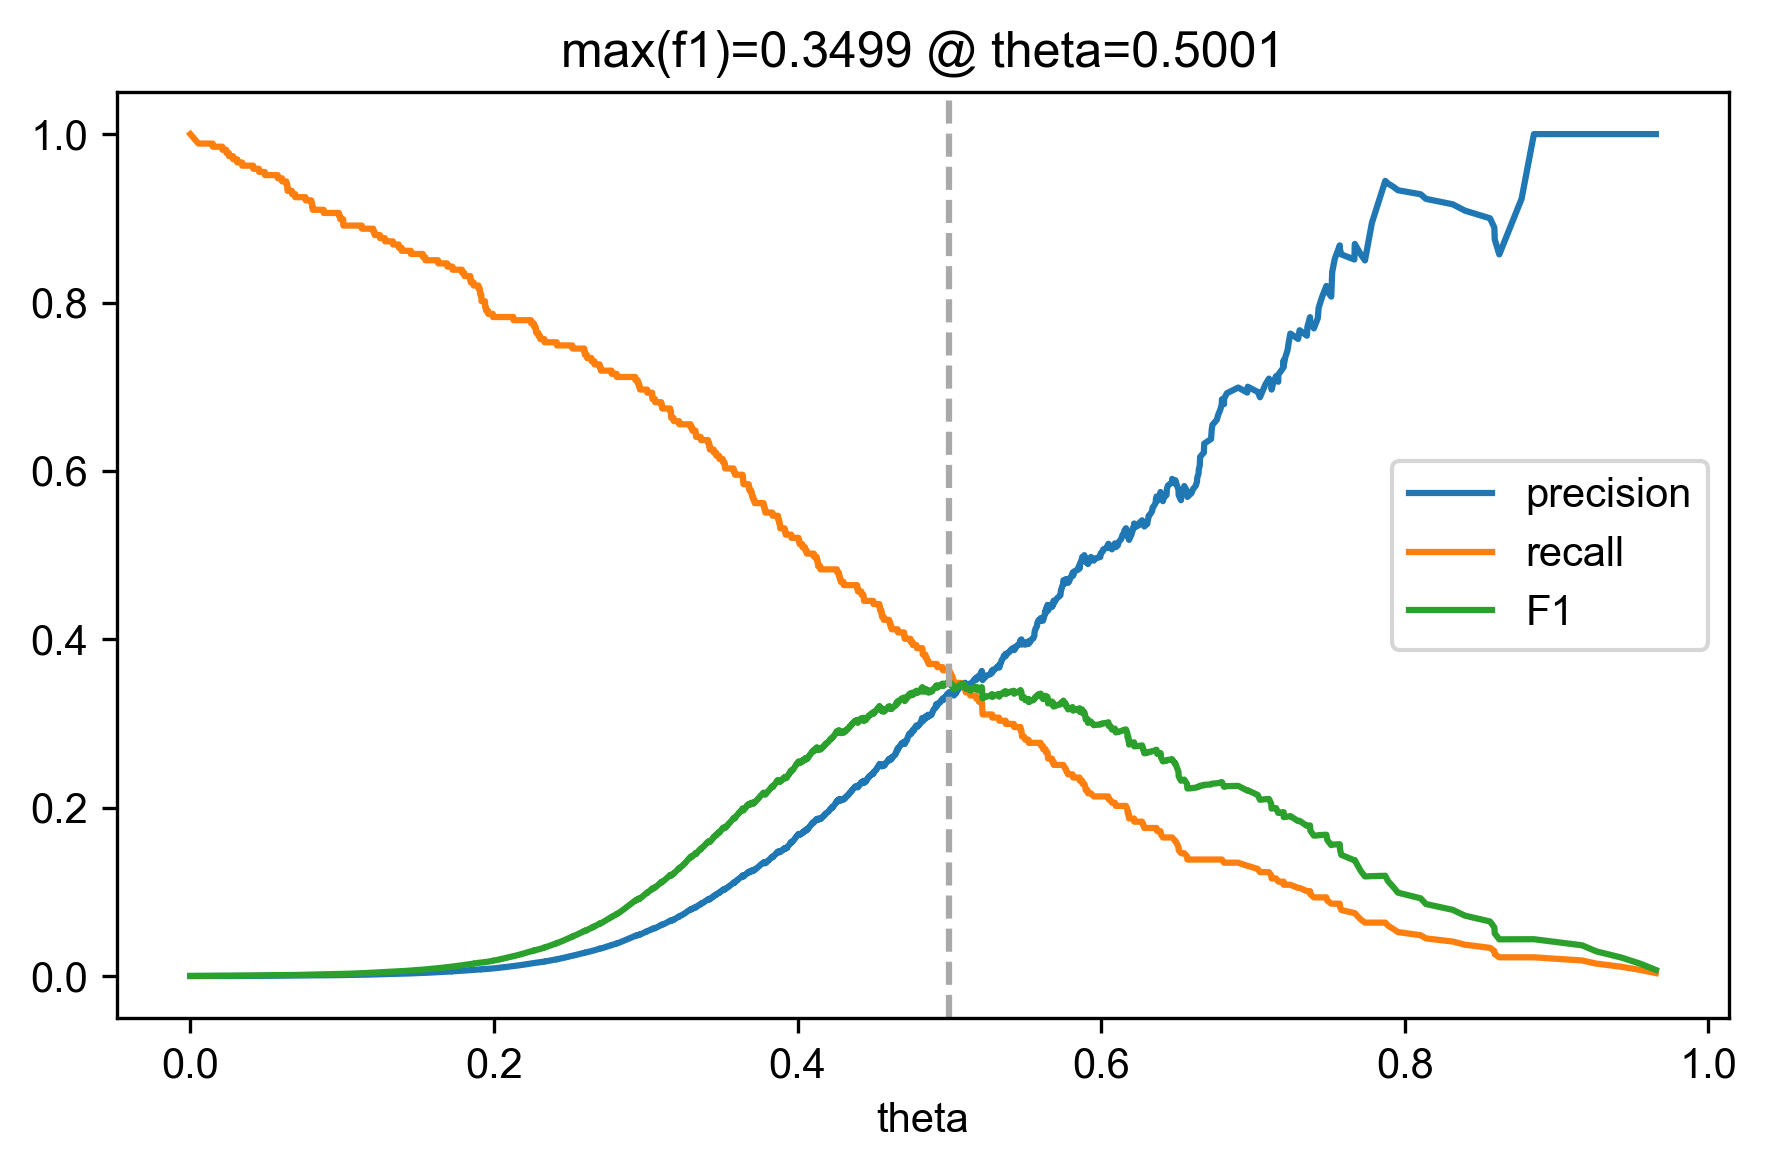

In [29]:
precisions, recalls, thresholds = precision_recall_curve(relevances, distances)
f1s = (2 * precisions * recalls) / (precisions + recalls)

max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]
print(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, f1s[:-1], label='F1')
plt.axvline(max_f1_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout()

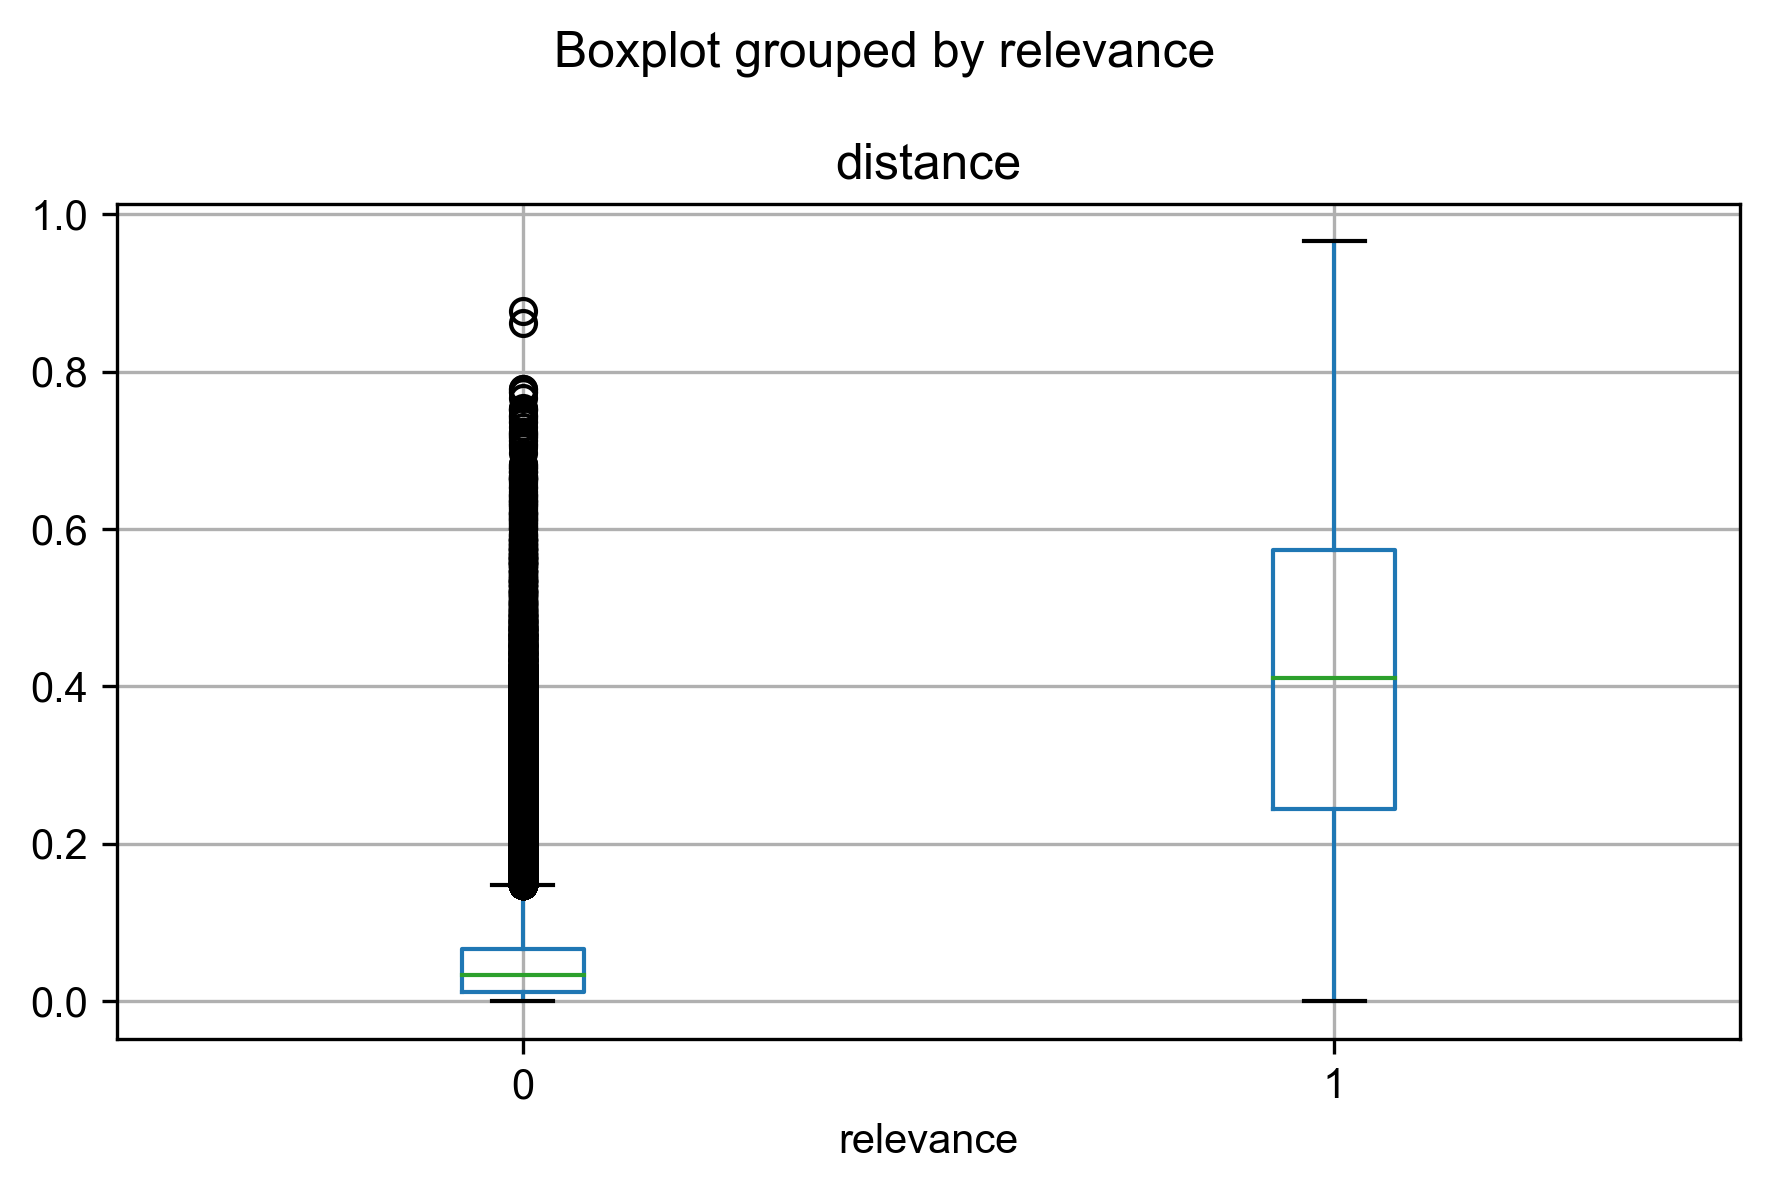

In [30]:
res_df = pd.DataFrame(zip(distances, relevances), columns=('distance', 'relevance'))
res_df.boxplot('distance', 'relevance')
plt.tight_layout();

#### Calibrate parameters

Like rhyme weight:

In [195]:
scores = []

# also negative weight for demonstration purposes:
rhyme_weights = tuple(np.linspace(-.3, 2.0, 50))

from sklearn.metrics import roc_auc_score

for rhyme_weight in tqdm(rhyme_weights):
    relevances, distances = precision_recall(df, meta, vec, rhyme_weight=rhyme_weight)
    distances = 1 - np.array(distances)
    auc = roc_auc_score(relevances, distances)
    av_prec = average_precision_score(relevances, distances)
    scores.append((rhyme_weight, auc, av_prec))

100%|██████████| 50/50 [04:01<00:00,  4.83s/it]


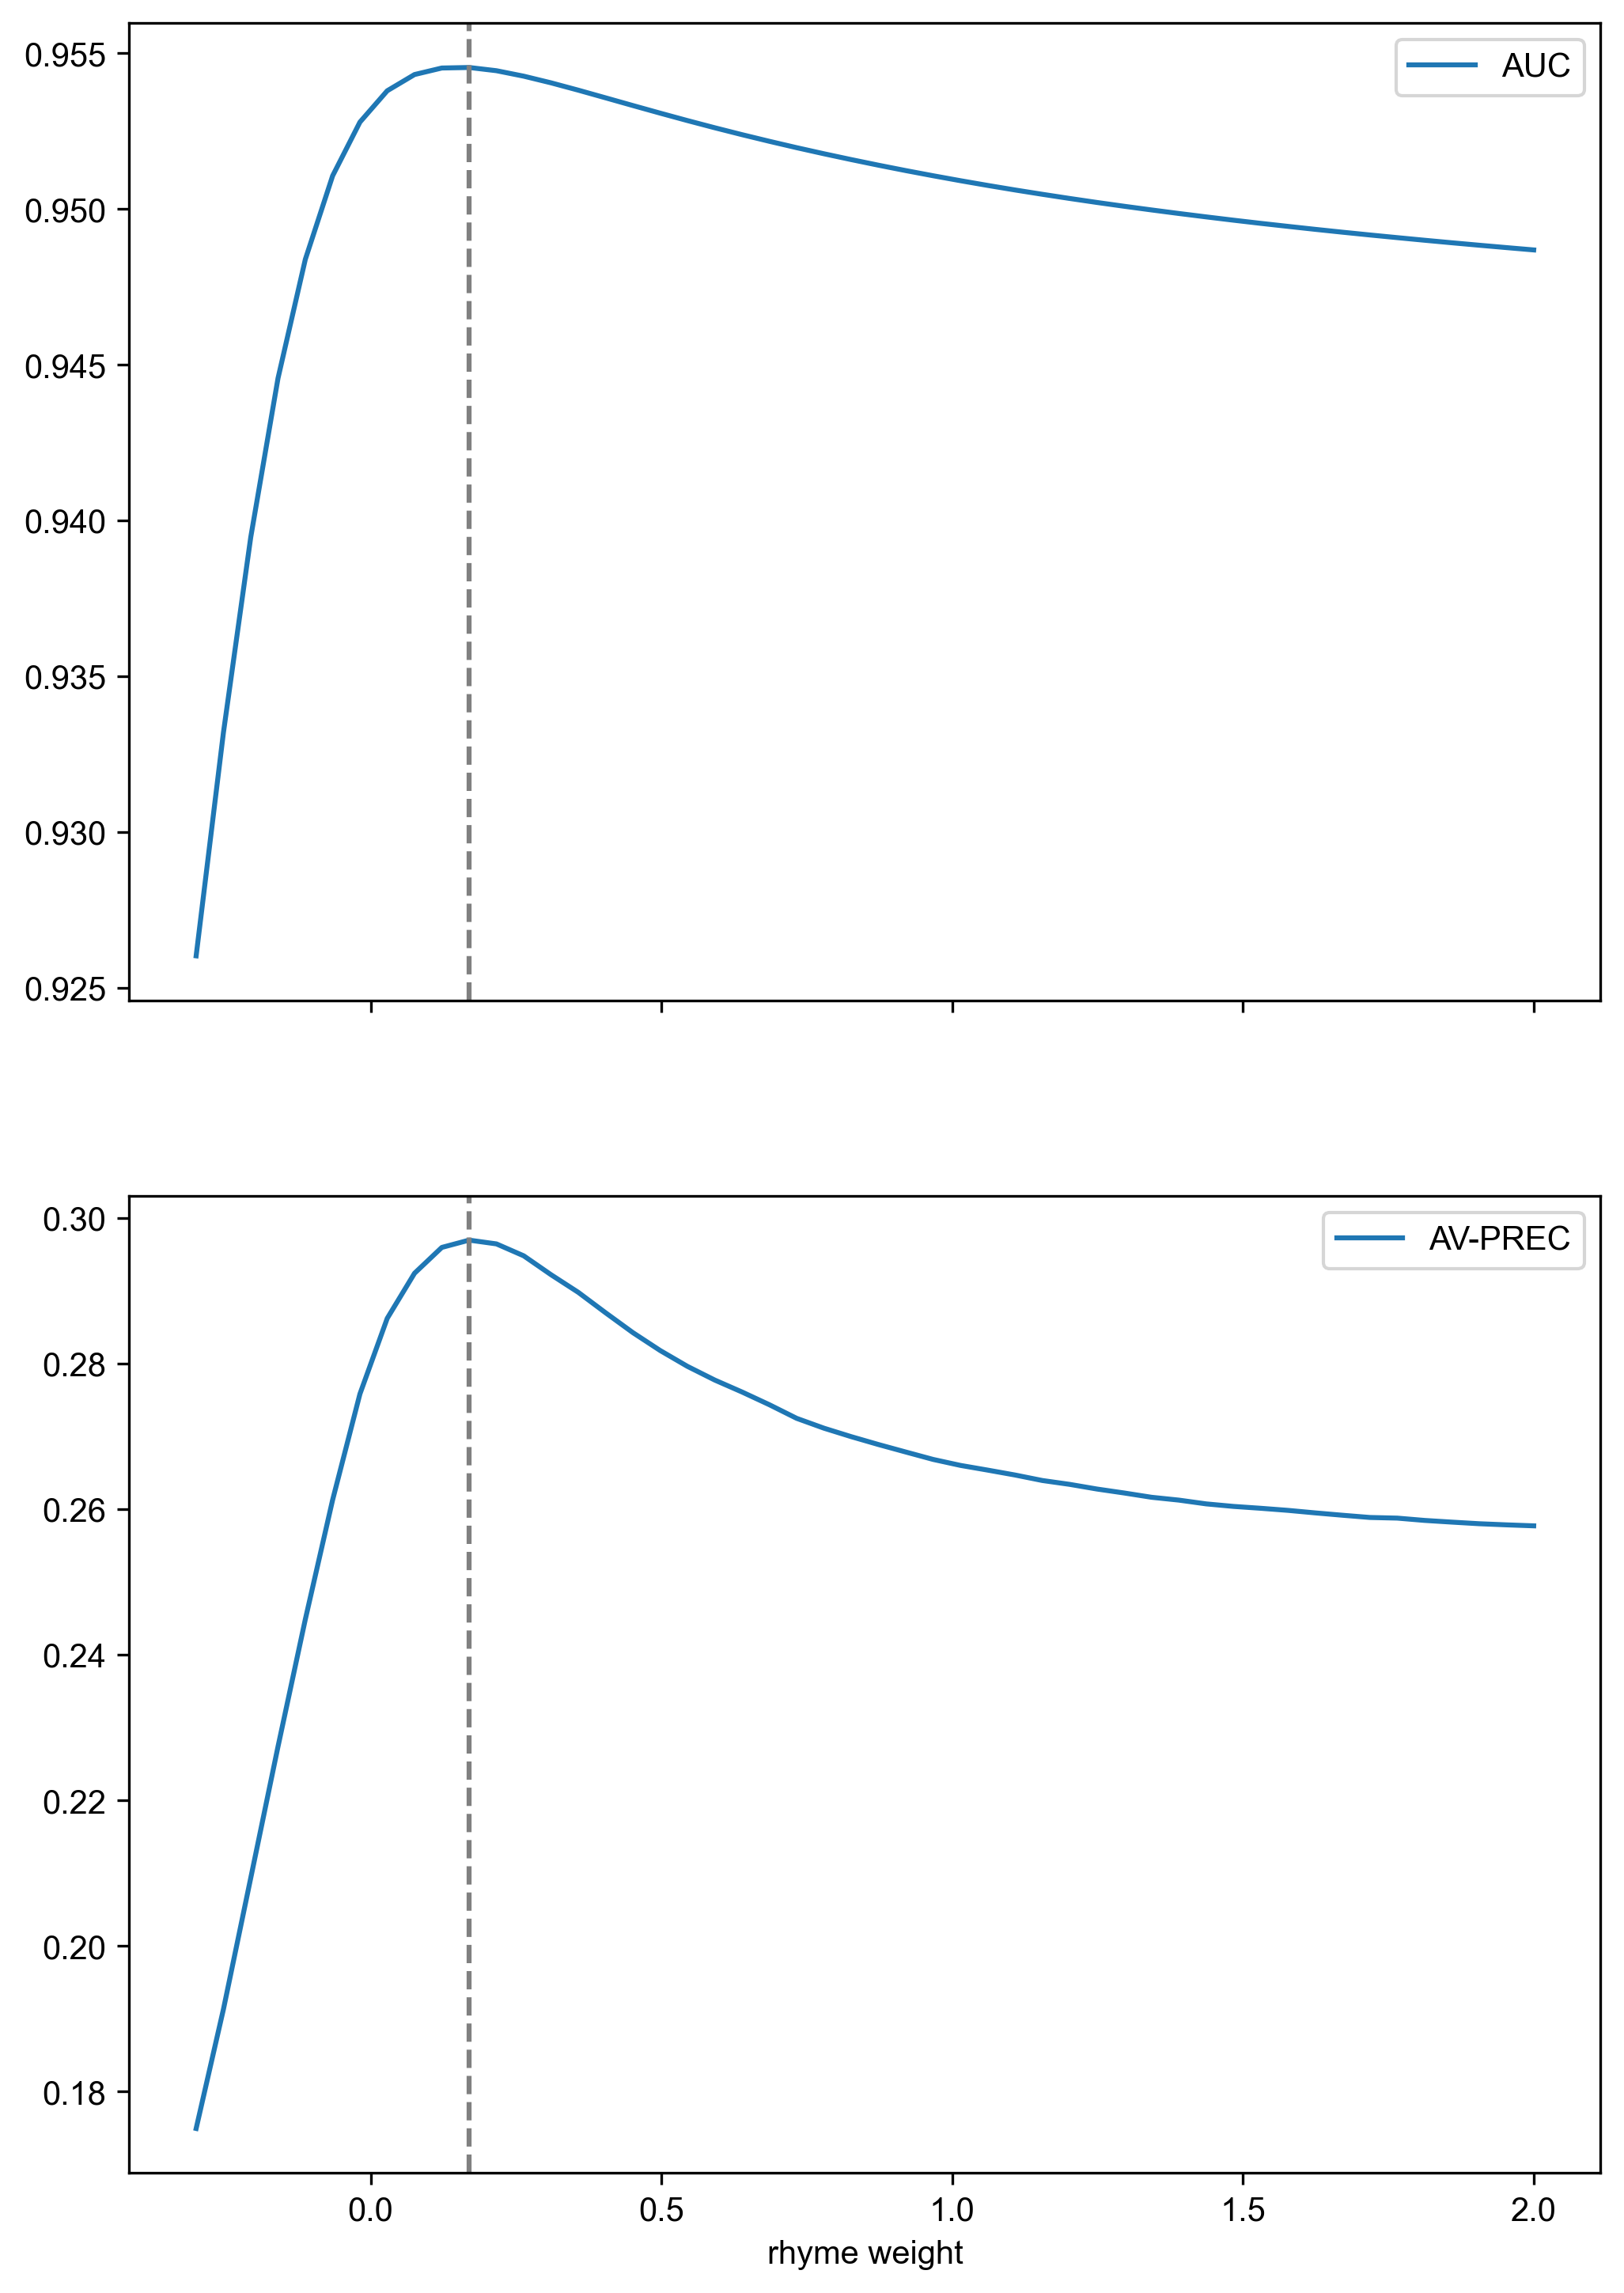

In [196]:
scores = pd.DataFrame(scores, columns=('rhyme weight', 'AUC', 'AV-PREC'))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 12))
scores.plot('rhyme weight', 'AUC', ax=ax1)
ax1.axvline(scores.iloc[scores['AUC'].idxmax()]['rhyme weight'], ls='--', c='grey')
scores.plot('rhyme weight', 'AV-PREC', ax=ax2)
ax2.axvline(scores.iloc[scores['AV-PREC'].idxmax()]['rhyme weight'], ls='--', c='grey');

In [197]:
optim_rw = scores.iloc[scores['AUC'].idxmax()]['rhyme weight']
optim_rw

0.1693877551020408

Vocabulary size?

In [26]:
vec = TfidfVectorizer(tokenizer=tokenizer, min_df=2, max_features=None)
vec.fit(df['lemmas'])
print(len(vec.get_feature_names()))

40568


Vocabulary size for TF and TF-IDF:

In [198]:
scores = []

vocab_sizes = list(range(500, 20000, 500))
parametrizations = {
                    'TF-IDF': {'min_df':2},
                    'TF': {'use_idf':False, 'min_df':2},
                    }

for vocab_size in tqdm(vocab_sizes):
    for param_name, param in parametrizations.items():
        param['max_features'] = vocab_size
        vec = TfidfVectorizer(tokenizer=tokenizer, **param)
        vec.fit(df['lemmas'])
        relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
        distances = 1 - np.array(distances)
        auc = roc_auc_score(relevances, distances)
        av_prec = average_precision_score(relevances, distances)
        scores.append((param_name, vocab_size, auc, av_prec))
scores = pd.DataFrame(scores, columns=('param', 'vocab_size', 'AUC', 'AV-PREC'))

  0%|          | 0/39 [00:00<?, ?it/s]/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
  3%|▎         | 1/39 [00:21<13:28, 21.27s/it]/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
 38%|███▊      | 15/39 [05:18<08:29, 21.24s/it]/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
 41%|████      | 16/39 [05:39<08:08, 21.24s/it]/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWa

 74%|███████▍  | 29/39 [10:14<03:30, 21.07s/it]/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
 77%|███████▋  | 30/39 [10:35<03:08, 20.97s/it]/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWa

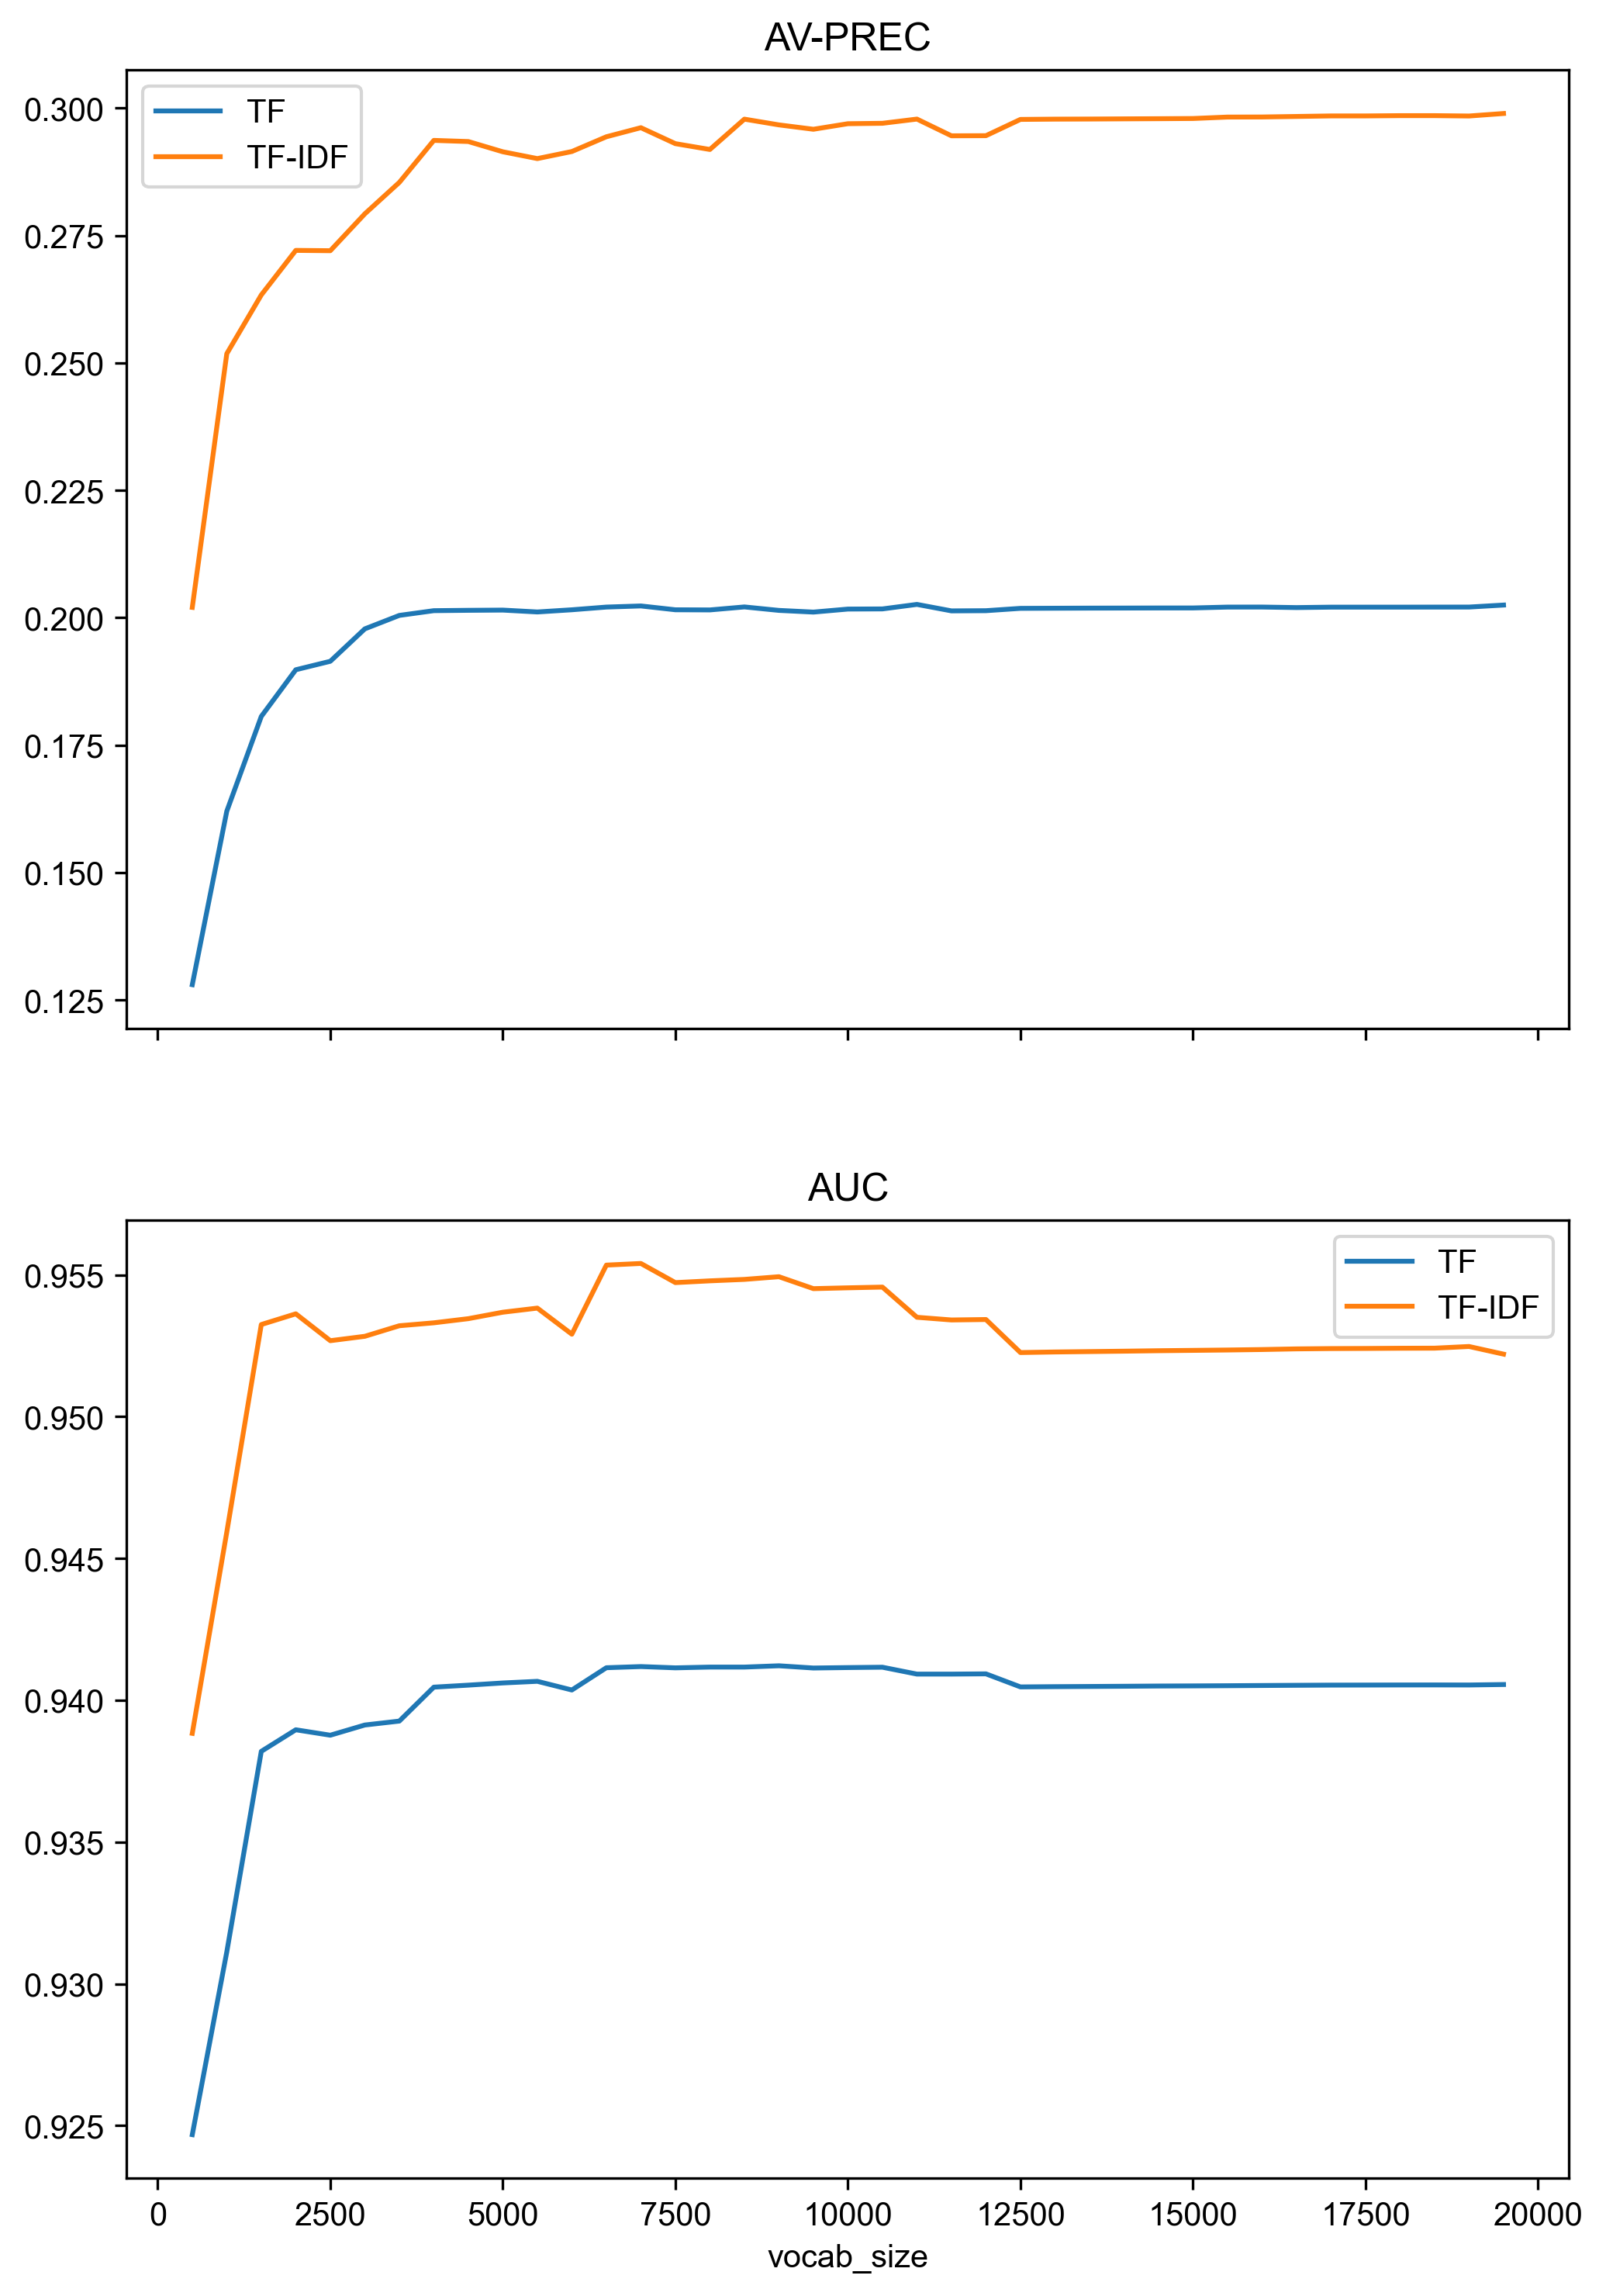

In [199]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 12))

for p, gr in scores.groupby('param'):
    gr.plot('vocab_size', 'AV-PREC', label=p, ax=ax1)
ax1.set_title('AV-PREC')
    
for p, gr in scores.groupby('param'):
    gr.plot('vocab_size', 'AUC', label=p, ax=ax2)
ax2.set_title('AUC');

In [200]:
scores['comb'] = scores['AUC'] * scores['AV-PREC']
optim_vs = scores.iloc[scores['AUC'].idxmax()]
display(optim_vs)
optim_vs = optim_vs['vocab_size']

param         TF-IDF  
vocab_size    7000    
AUC           0.955405
AV-PREC       0.296145
comb          0.282939
Name: 26, dtype: object

## Final threshold

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


max(f1)=0.3611 @ theta=0.6115


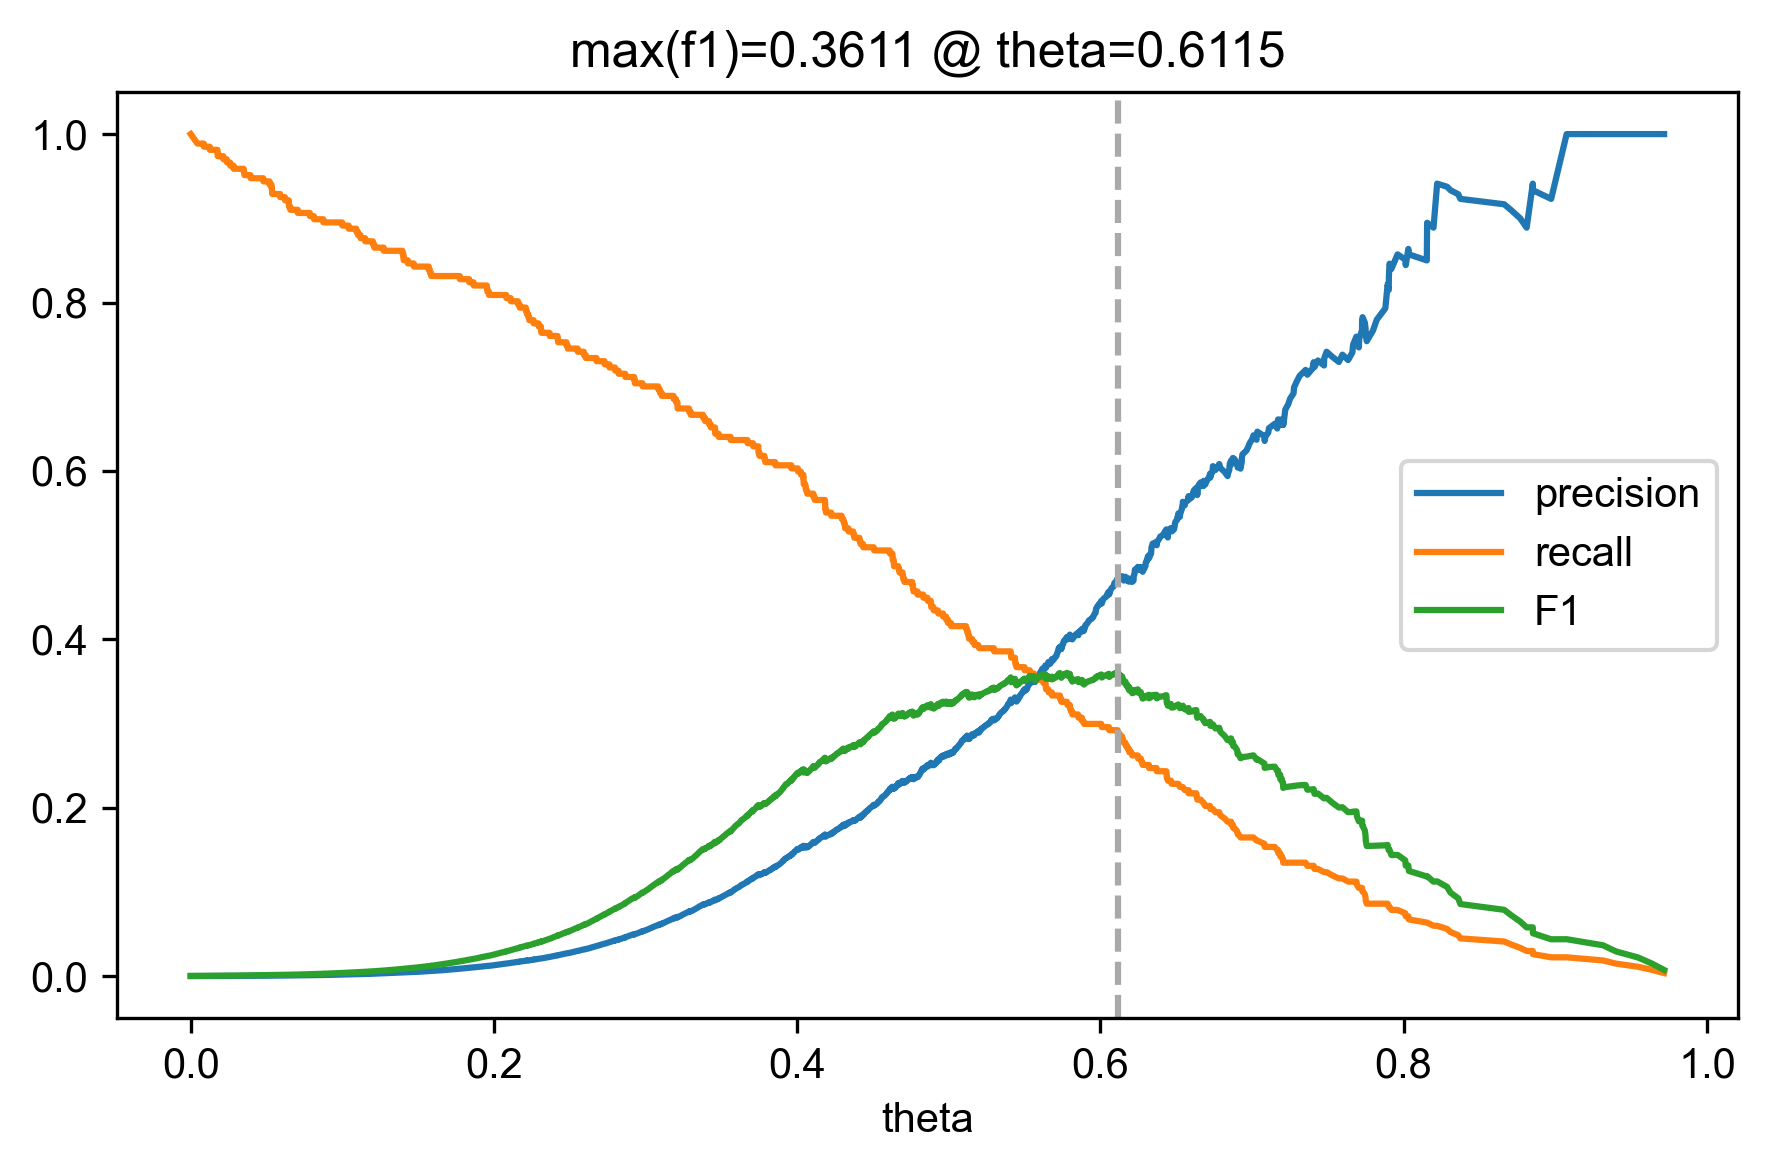

In [201]:
vec = TfidfVectorizer(max_features=40000, min_df=2,
                      tokenizer=tokenizer)
vec.fit(df['lemmas'])
relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
distances = 1 - np.array(distances)
precisions, recalls, thresholds = precision_recall_curve(relevances, distances)
f1s = (2 * precisions * recalls) / (precisions + recalls)

max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]
print(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, f1s[:-1], label='F1')
plt.axvline(max_f1_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout()

In [15]:
optim_rw = 0.1693877551020408
max_f1_th = 0.5624

## Case studies

#### Well-known cases of intertextual borrowings at the MACRO-level

In [210]:
def distance_nn(title1, title2, rhyme_weight=.25, batch_size=5000):
    
    def batch(iterable, n=1):
        l = iterable.shape[0]
        for ndx in range(0, l, n):
            yield iterable[ndx:min(ndx + n, l)]
    
    A = df[df['title'] == title1]
    B = df[df['title'] == title2]

    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

    all_distances = []

    for ax in batch(AX, batch_size):
         all_distances.extend(pairwise_distances(ax, BX, metric='cosine').min(axis=1))
    
    return pd.Series(all_distances)

def plot_min_distance_nn(t1, t2, min_dists, threshold, rolling_size=1000):
    mu = min_dists.rolling(rolling_size).mean()
    fig, ax = plt.subplots()
    mu.plot(ax=ax)
    ax.axhline(threshold, ls='--', c='grey')
    ax.set_ylim(0, 1)
    ax.set_xlabel(t1)
    ax.set_ylabel('Distance to NN in ' + t2)
    return ax

In [211]:
rolling_size, threshold = 1000, 1 - max_f1_th
print(threshold)

0.3885285476428948


In [212]:
def get_interpolations(title):
    fn = meta_df[meta_df['title'] == title]['id'].iloc[0]
    tree = lxml.etree.parse(f'../data/xml/{fn}.xml').getroot()
    interpol_idxs, interpol_names, line_cnt = [], [], 0
    for element in tree:
        line_cnt += 1
        if element.tag == 'interpolation':
            idxs, length = line_cnt, len(element.findall('l'))
            interpol_idxs.append([line_cnt, line_cnt + length])
            line_cnt += length
            interpol_names.append(element.attrib['reason'])      
    return interpol_idxs, interpol_names

Heelu in de Vijfde Partie:

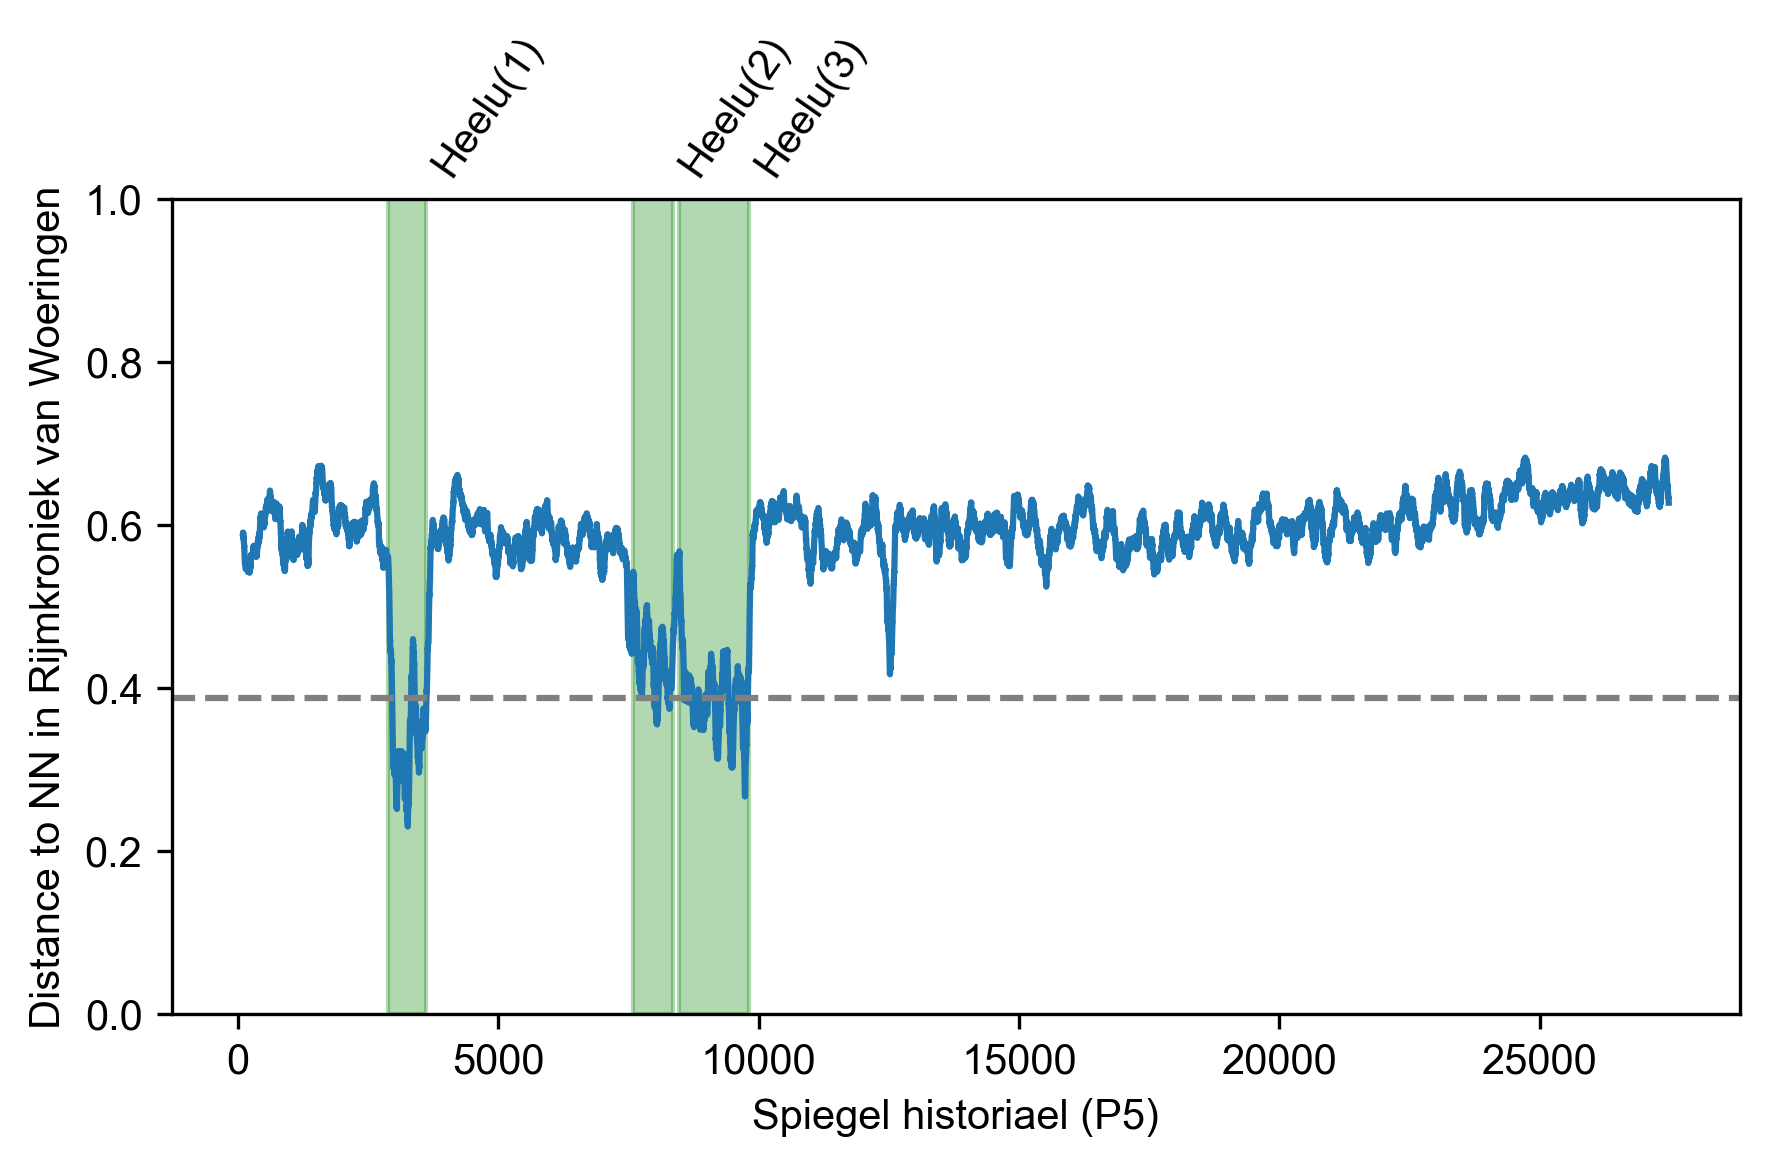

In [213]:
t1, t2 = 'Spiegel historiael (P5)', 'Rijmkroniek van Woeringen'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100)
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if n.startswith('Heelu'):
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

Maerlant in de Brabantse yeesten:

In [209]:
t1, t2 = 'Brabantsche yeesten (B1-5)', 'Spiegel historiael (P1-P4 [Maerlant])'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
    plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

ValueError: Found array with 0 sample(s) (shape=(0, 40000)) while a minimum of 1 is required.

In [ ]:
t1, t2 = 'Der vrouwen heimelijcheit', 'Van smeinscen lede'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
    plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

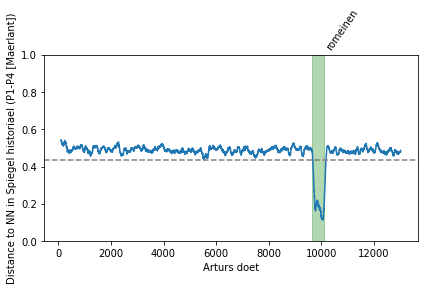

In [22]:
t1, t2 = 'Arturs doet', 'Spiegel historiael (P1-P4 [Maerlant])'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if not 'gebed' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

Nog te annoteren:

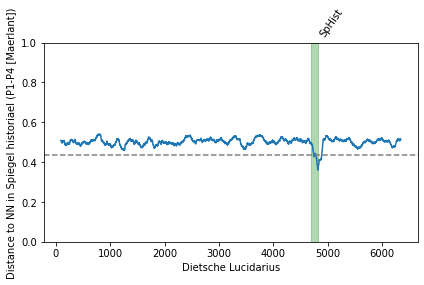

In [38]:
t1, t2 = 'Dietsche Lucidarius', 'Spiegel historiael (P1-P4 [Maerlant])'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if 'SpHist' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

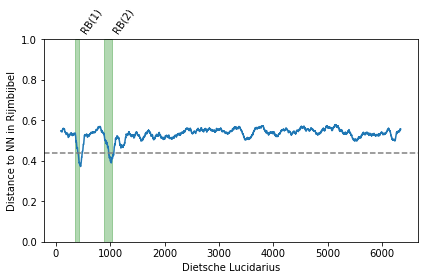

In [39]:
t1, t2 = 'Dietsche Lucidarius', 'Rijmbijbel'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if not 'SpHist' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

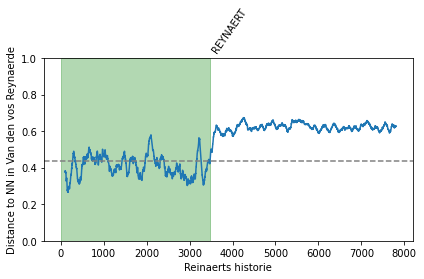

In [25]:
t1, t2 = 'Reinaerts historie', 'Van den vos Reynaerde'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if not 'gebed' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

(Show some random combinations of Maerlant works to show the many intertexts in a oeuvre!)

#### Large-scale detection

In [40]:
chiv_titles = meta_df[meta_df['genre'] == 'Epiek']['title'].unique()
chiv_titles

array(['Alexanders geesten', 'Alexiuslegende', 'Anatomie van de mens',
       'Arturs doet', 'Aubri de Borgengoen', 'Barlaam en Josaphat',
       'Beatrijs', 'Bediedenisse van der missen',
       'Beerte metten breden voeten', 'Beginsel der oorlogen van Luyck',
       'Boec Exemplaer', 'Boec van den houte', 'Boec vander wraken',
       'Boeve van Hamtone', 'Borchgrave van Couchi',
       'Borchgravinne van Vergi (1)', 'Borchgravinne van Vergi (2)',
       'Boudewijn van Seborch', 'Brabantsche yeesten (B1-5)',
       'Brabantsche yeesten (B6)', 'Brabantsche yeesten (B7)',
       'Nevelingenlied', "Chanson d'Aspremont", 'Collectief lunarium I',
       'Collectief lunarium III', 'Commentaar op het Hooglied',
       'Collectief lunarium II', 'Cyromanchie van den pape van den Hamme',
       'Der leken spieghel', 'Der mannen ende vrouwen heimelijcheit',
       'Der minnen loep', 'Der naturen bloeme',
       'Der vrouwen heimelijcheit', 'Der ystorien bloeme',
       'Dietsche doctrinale', 'Di

In [45]:
results = []
#for t1, t2 in tqdm(product(['Arturs doet'], chiv_titles)):
#for t1, t2 in tqdm(product(['Karel ende Elegast'], chiv_titles)):
for t1, t2 in tqdm(list(product(chiv_titles, chiv_titles))):
    if t1 == t2:
        continue
    results.append((t1, t2, distance_nn(t1, t2, batch_size=10000)))

100%|██████████| 25921/25921 [4:52:47<00:00,  1.48it/s]    


In [46]:
results = pd.DataFrame(results, columns=('t1', 't2', 'nn'))
results

t1                    t2  \
0      Alexanders geesten   Alexiuslegende         
1      Alexanders geesten   Anatomie van de mens   
2      Alexanders geesten   Arturs doet            
3      Alexanders geesten   Aubri de Borgengoen    
4      Alexanders geesten   Barlaam en Josaphat    
...                   ...                   ...    
25755  Merlijn-continuatie  Walewein               
25756  Merlijn-continuatie  Walewein ende Keye     
25757  Merlijn-continuatie  Willem van Oringen     
25758  Merlijn-continuatie  Wisselau               
25759  Merlijn-continuatie  Wrake van Ragisel      

                                                                                                                                                                                                                                        nn  
0      0        0.617685
1        0.780991
2        0.898283
3        0.797659
4        0.683945
           ...   
14212    0.739793
14213    0.822215
14214    0.834257
14215    0.830672
14216    0.774655
Length: 14217, dtype: float64  
1      0        0.729186
1        0.733216
2        0.805197
3        0.839706
4        0.815746
           ...   
14212    0.611593
14213    0.702276
14214    0.776497
14215    0.765159
14216    0.715193
Length: 14217, dtype: float64  
2      0        0.558574
1        0.598717
2        0.710090
3        0.708657
4        0.597332
           ...   
14212    0.530249
14213    0.591263
14214    0.596011
14215    0.520662
14216    0.613638
Length: 14217, dtype: float64  
3      0        0.750271
1        0.685702
2        0.828429
3        0.846650
4        0.713775
           ...   
14212    0.740806
14213    0.792871
14214    0.772396
14215    0.593234
14216    0.592947
Length: 14217, dtype: float64  
4      0        0.733087
1        0.775662
2        0.844656
3        0.846019
4        0.713229
           ...   
14212    0.655201
14213    0.826518
14214    0.769727
14215    0.745247
14216    0.803567
Length: 14217, dtype: float64  
...                                                                                                                                                                                                                                    ...  
25755  0        0.679183
1        0.642097
2        0.444396
3        0.530713
4        0.518685
           ...   
25805    0.722224
25806    0.804936
25807    0.816909
25808    0.719724
25809    0.598546
Length: 25810, dtype: float64  
25756  0        0.597280
1        0.493444
2        0.547290
3        0.678757
4        0.616630
           ...   
25805    0.789676
25806    0.796592
25807    0.688845
25808    0.649204
25809    0.674336
Length: 25810, dtype: float64  
25757  0        0.757083
1        0.752150
2        0.849134
3        0.854056
4        0.722972
           ...   
25805    0.718222
25806    0.914586
25807    0.910586
25808    0.862817
25809    0.737892
Length: 25810, dtype: float64  
25758  0        0.768819
1        0.765598
2        0.830051
3        0.810381
4        0.730846
           ...   
25805    0.849047
25806    0.911323
25807    0.901488
25808    0.865581
25809    0.832813
Length: 25810, dtype: float64  
25759  0        0.737809
1        0.557589
2        0.558297
3        0.632832
4        0.450962
           ...   
25805    0.769242
25806    0.833856
25807    0.694228
25808    0.658417
25809    0.641183
Length: 25810, dtype: float64  

[25760 rows x 3 columns]

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


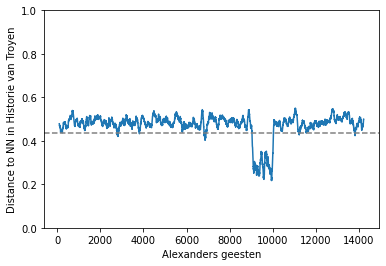

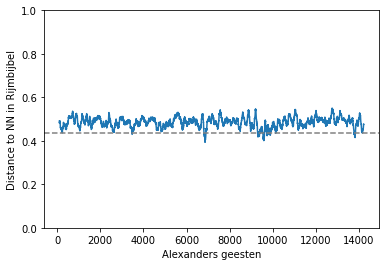

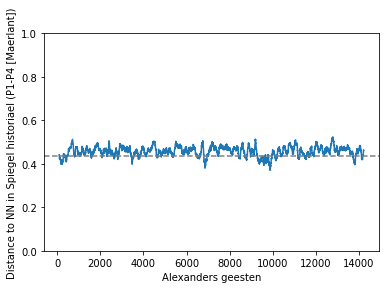

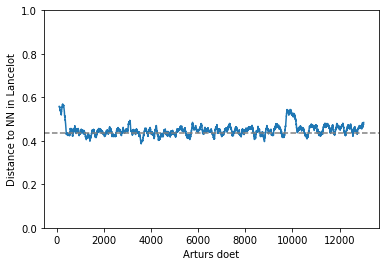

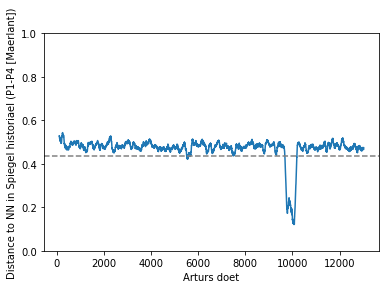

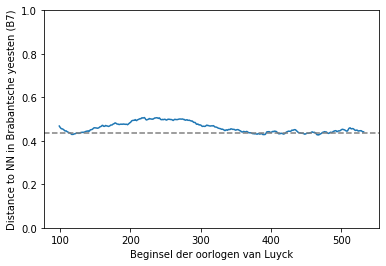

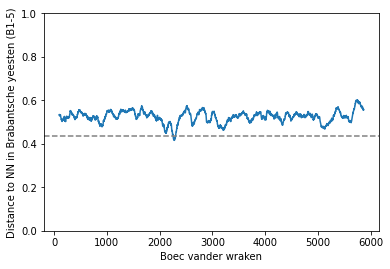

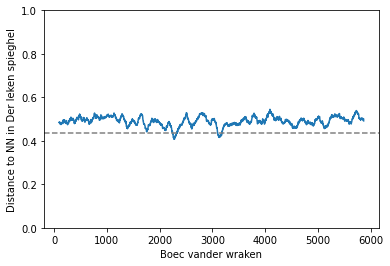

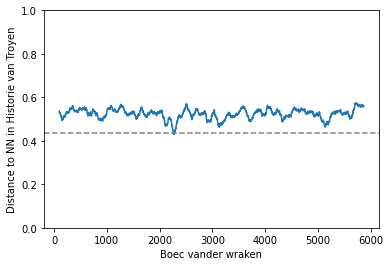

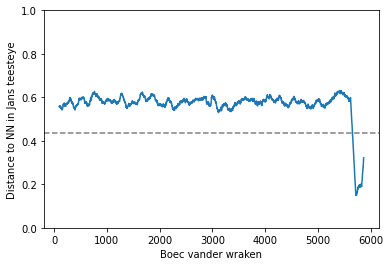

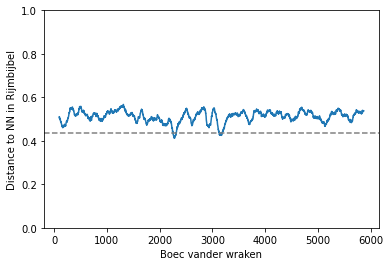

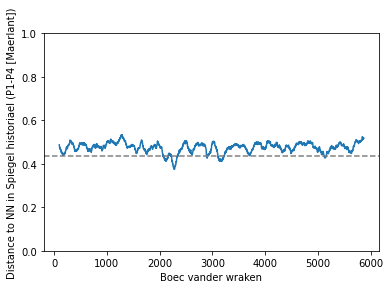

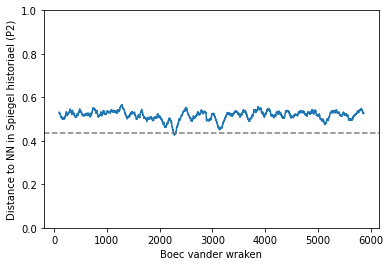

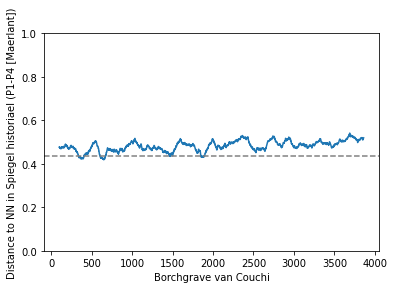

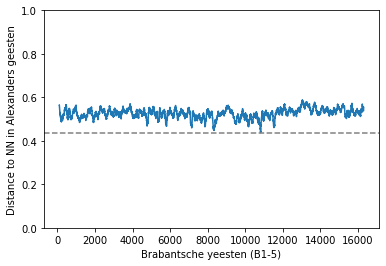

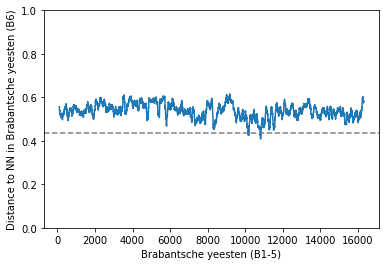

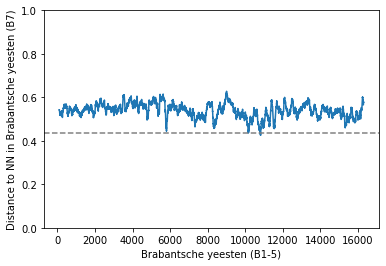

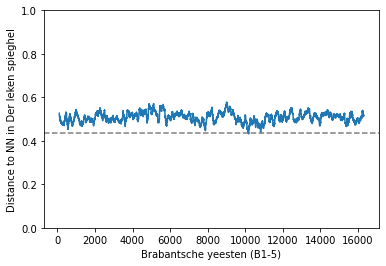

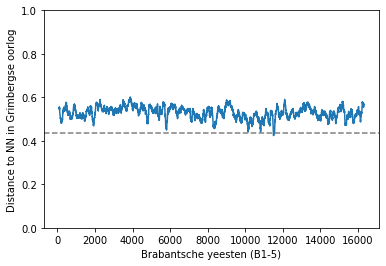

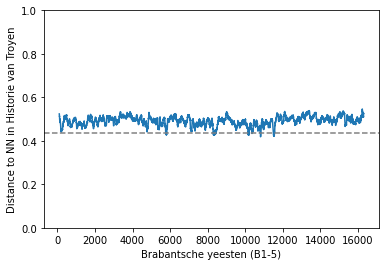

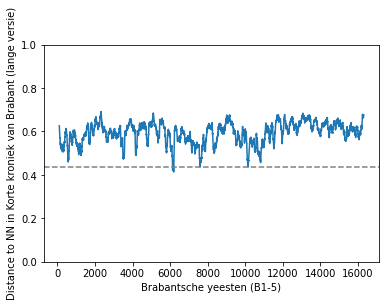

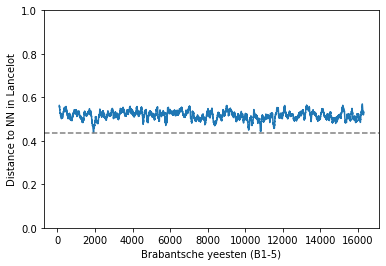

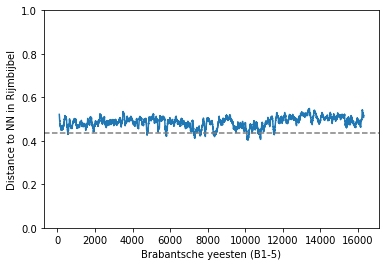

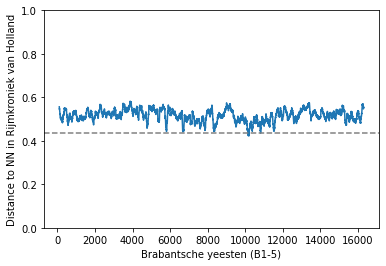

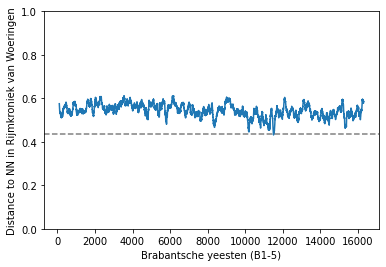

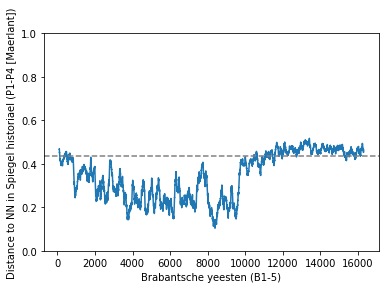

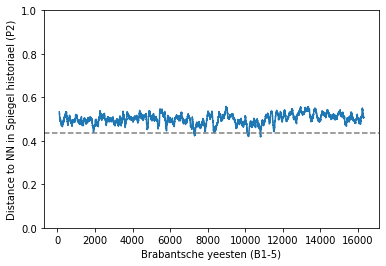

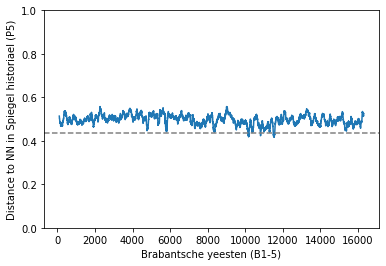

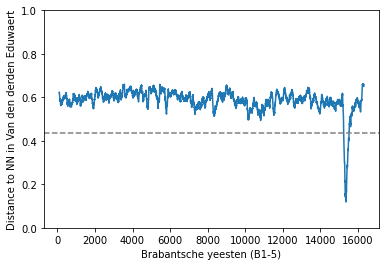

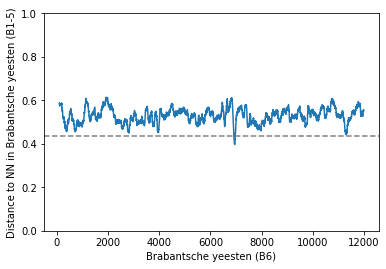

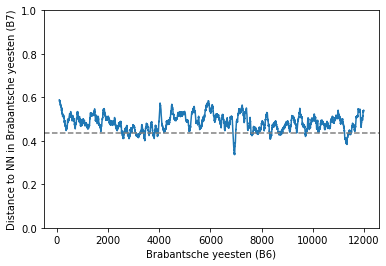

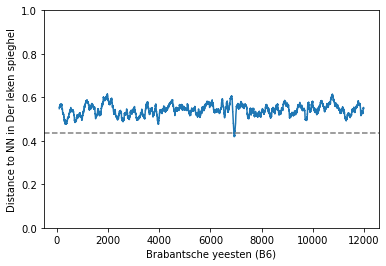

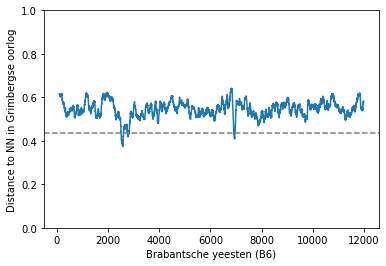

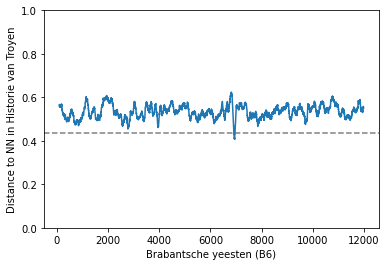

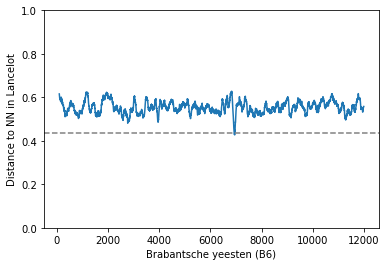

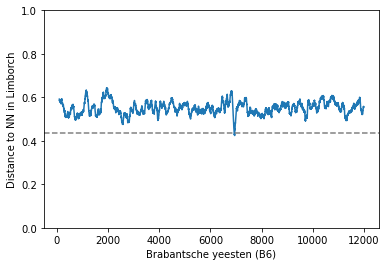

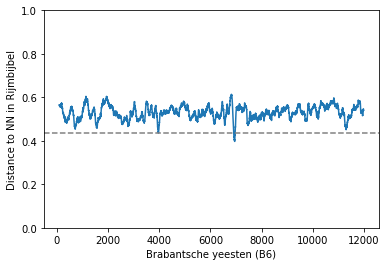

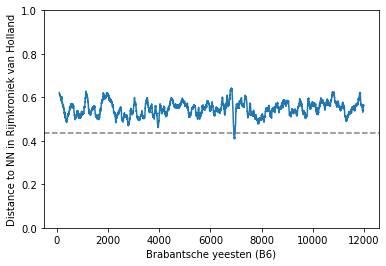

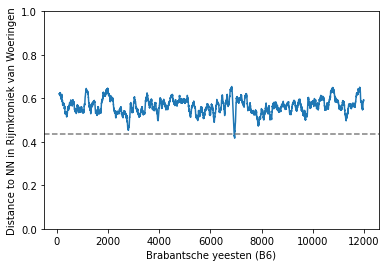

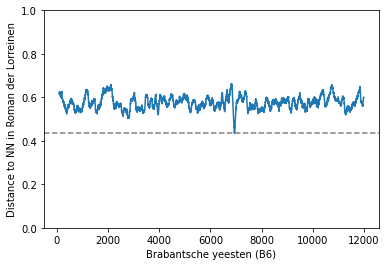

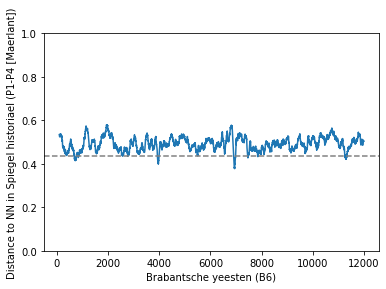

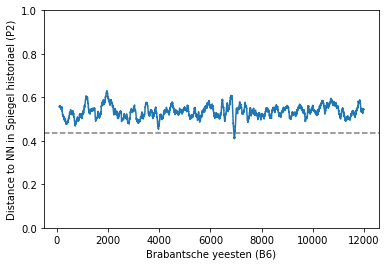

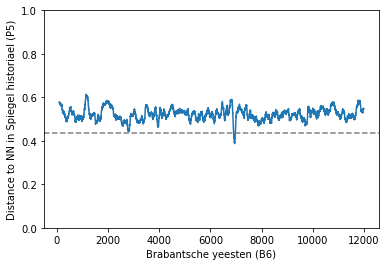

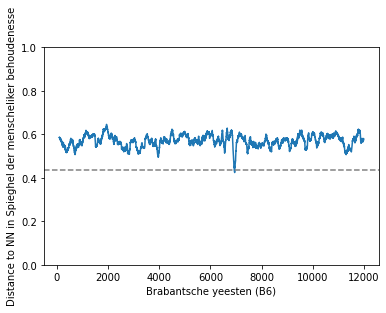

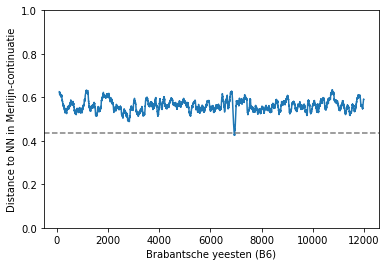

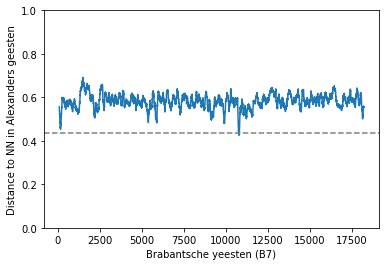

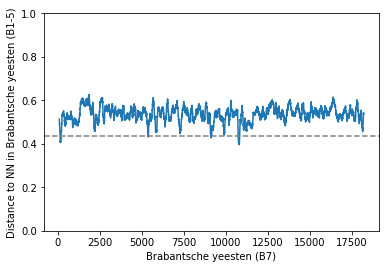

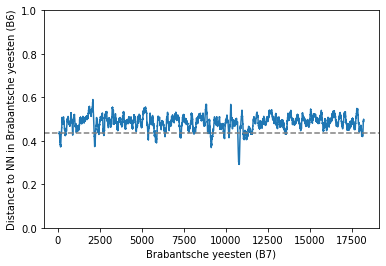

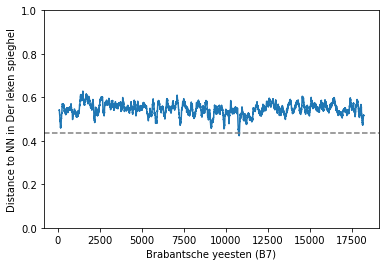

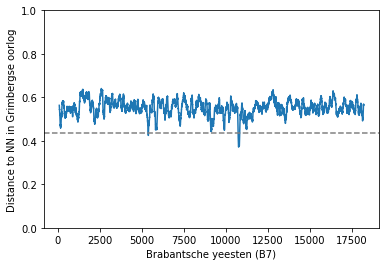

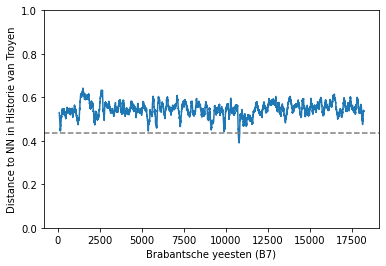

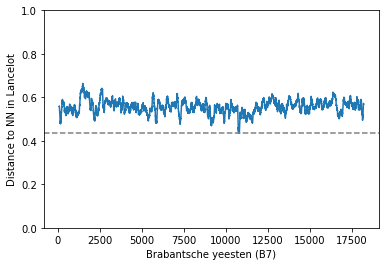

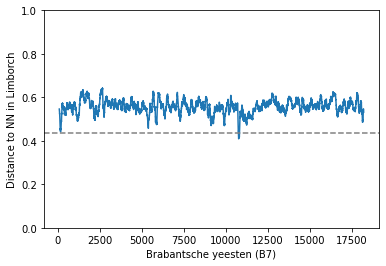

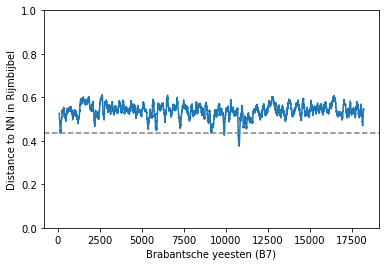

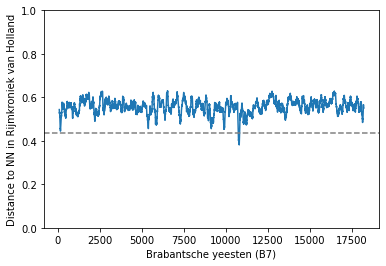

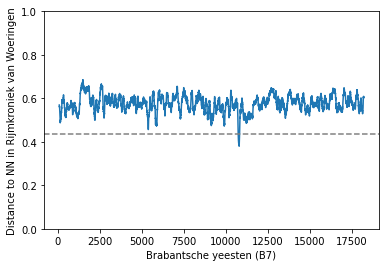

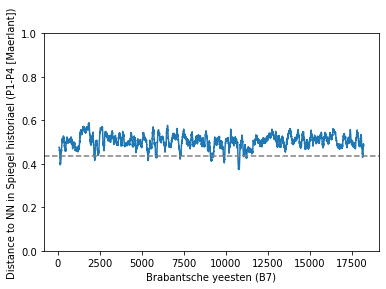

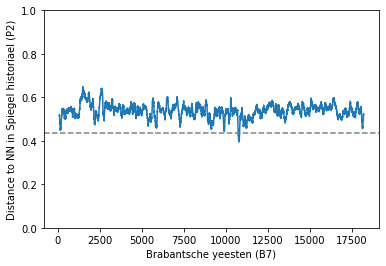

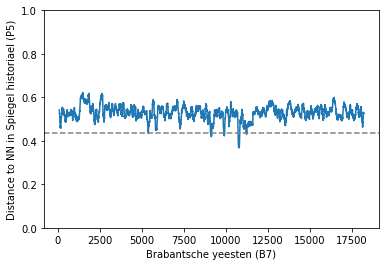

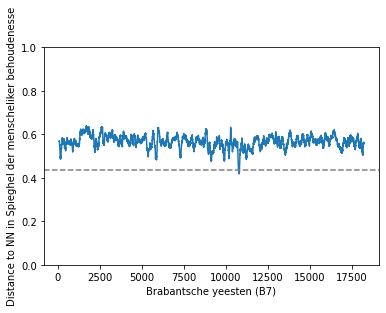

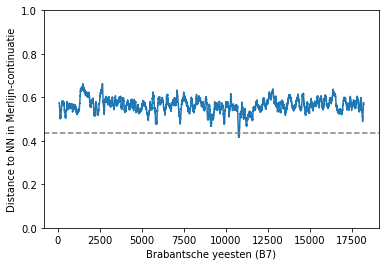

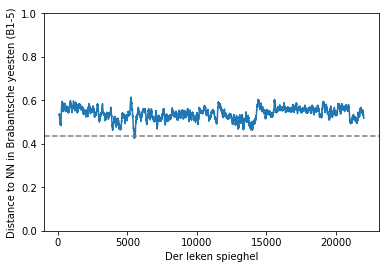

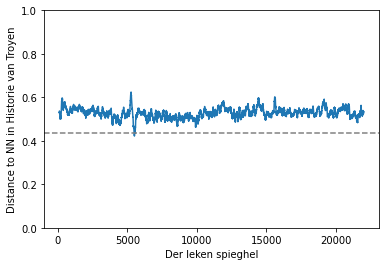

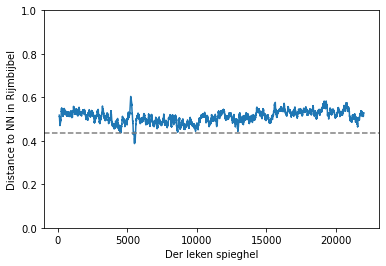

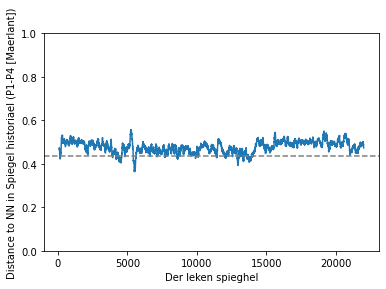

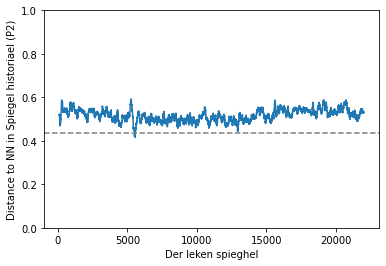

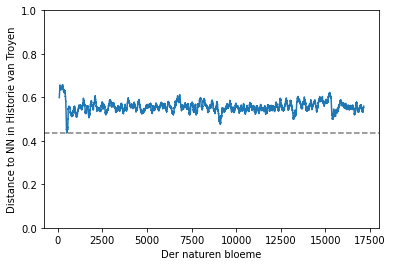

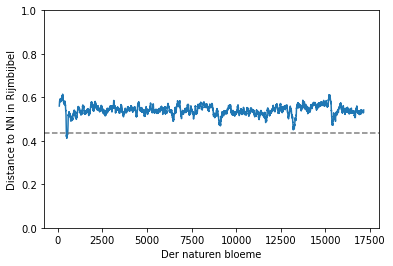

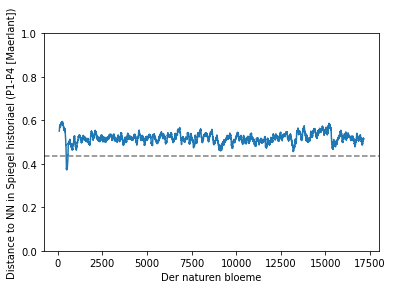

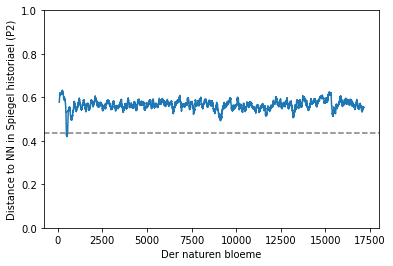

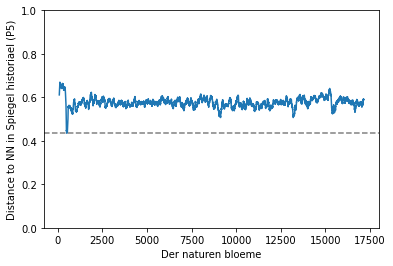

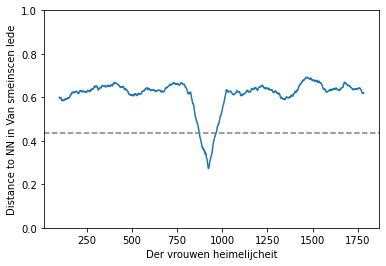

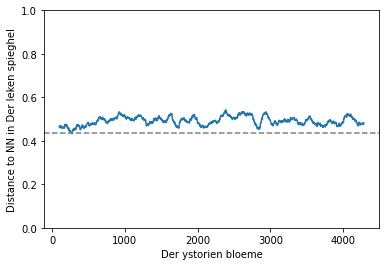

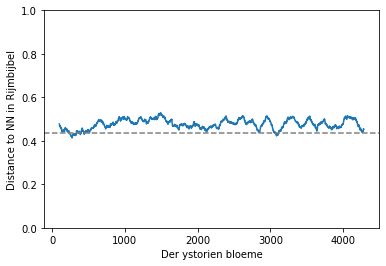

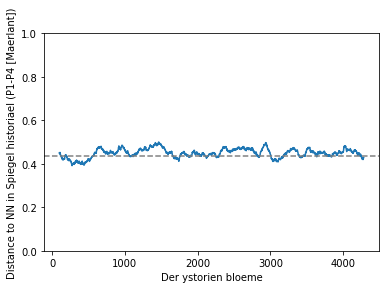

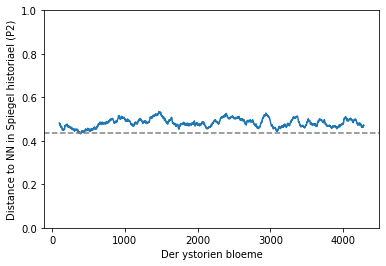

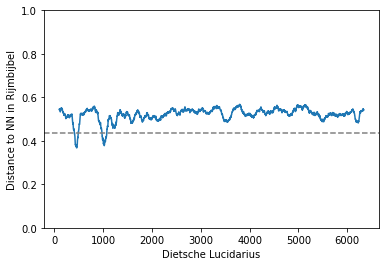

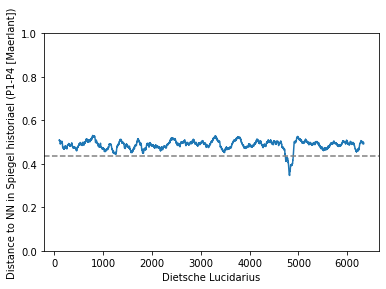

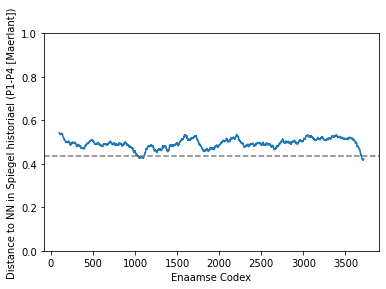

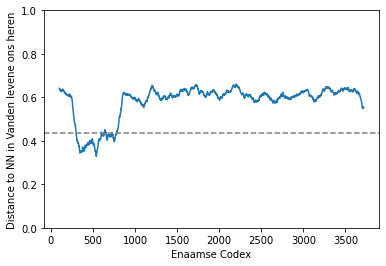

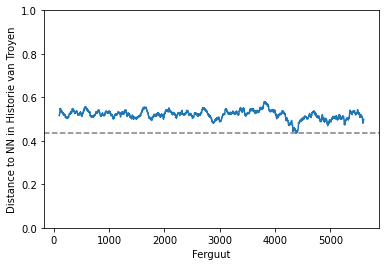

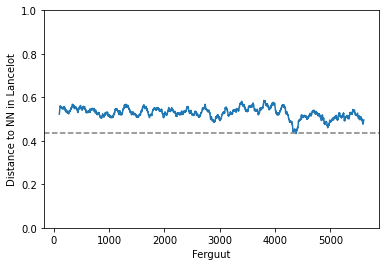

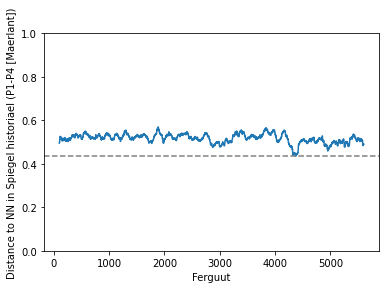

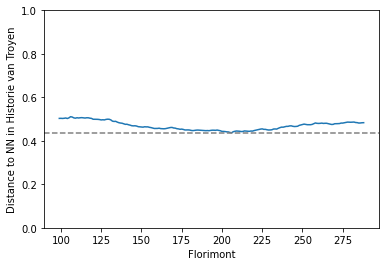

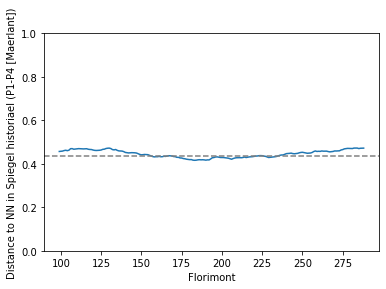

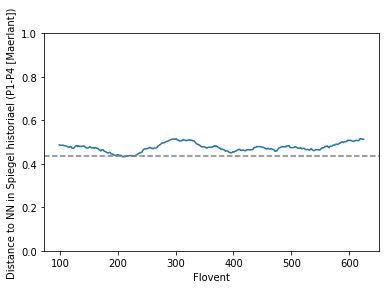

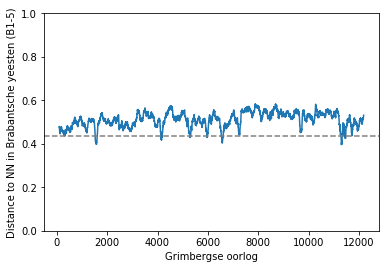

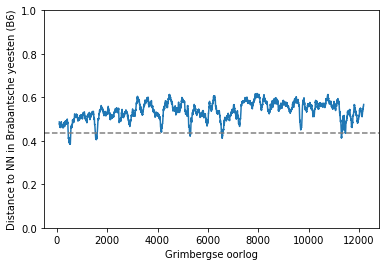

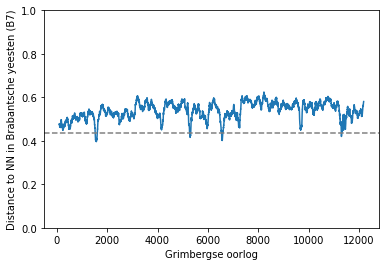

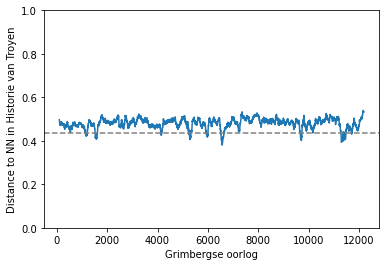

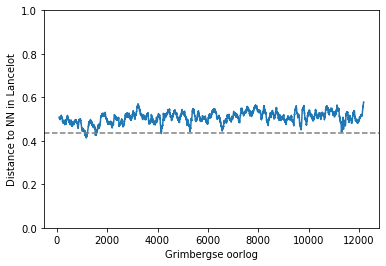

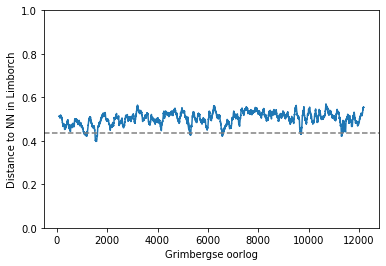

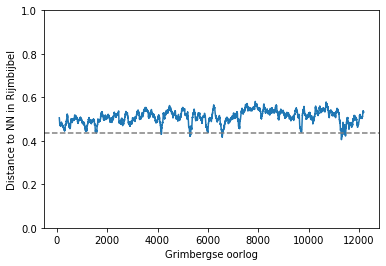

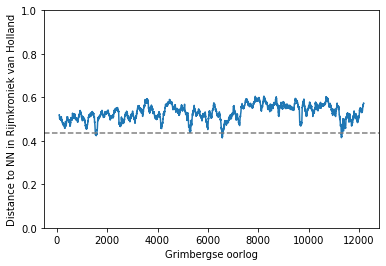

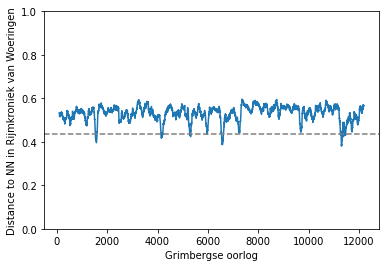

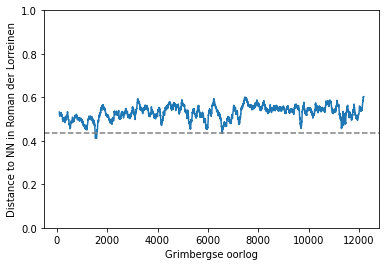

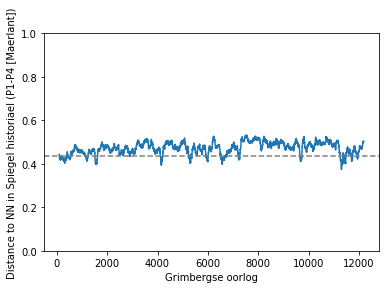

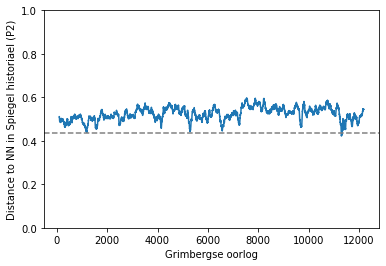

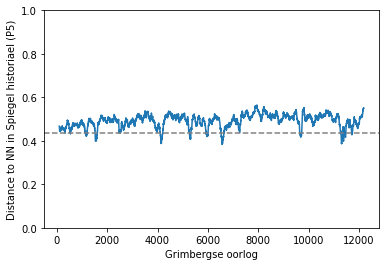

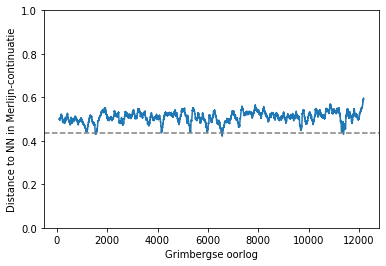

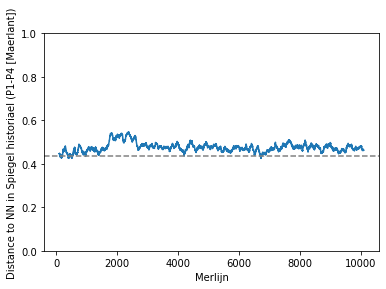

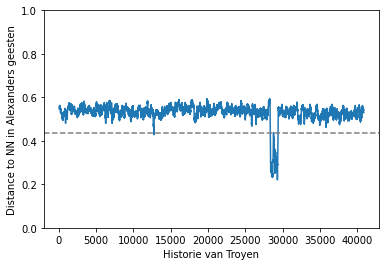

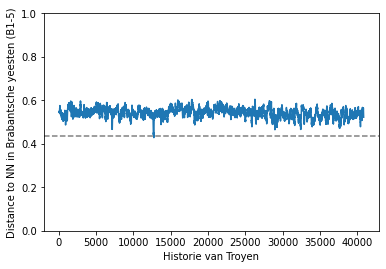

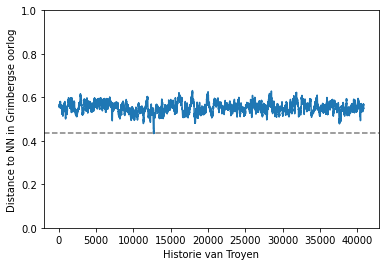

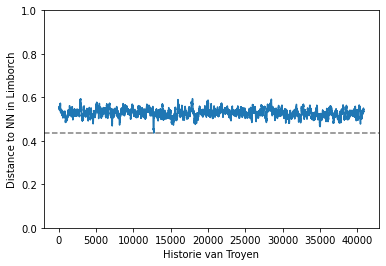

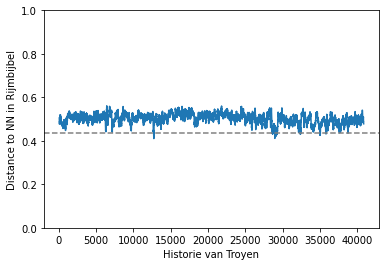

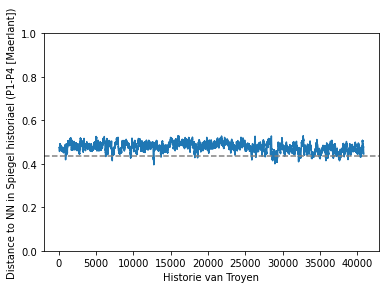

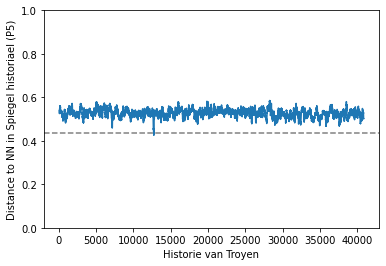

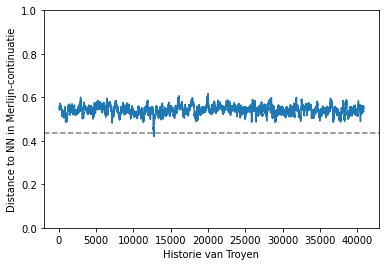

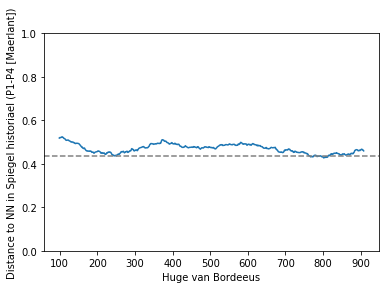

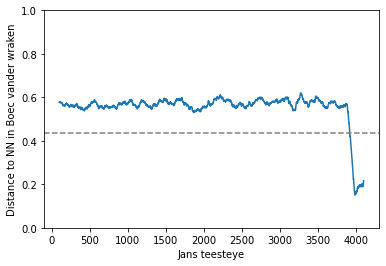

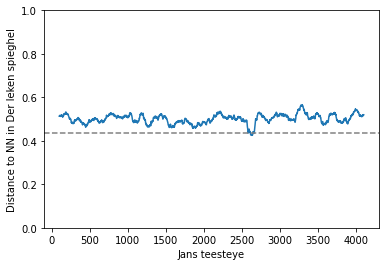

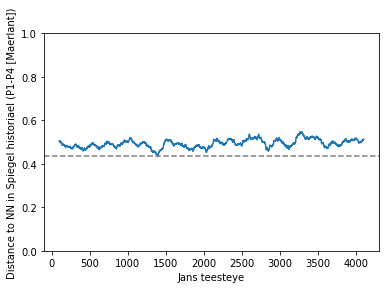

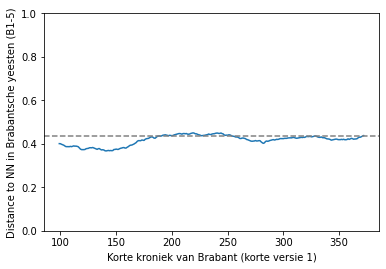

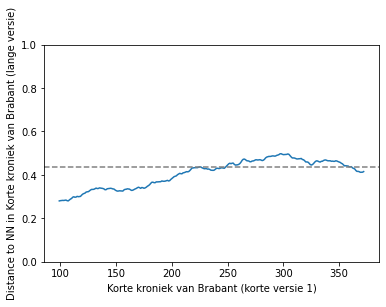

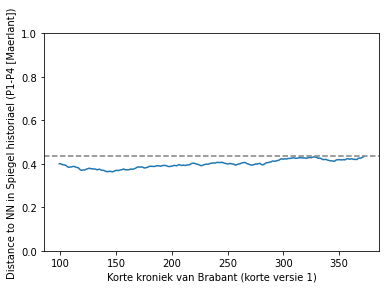

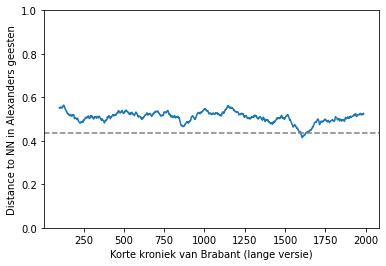

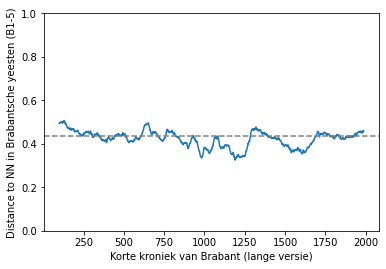

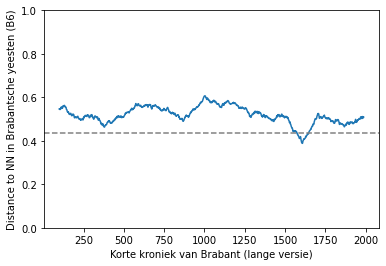

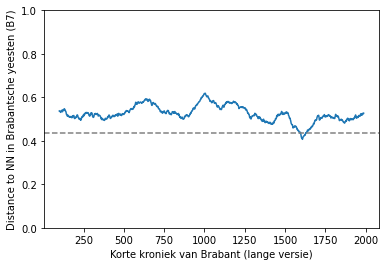

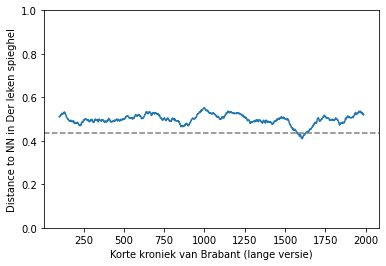

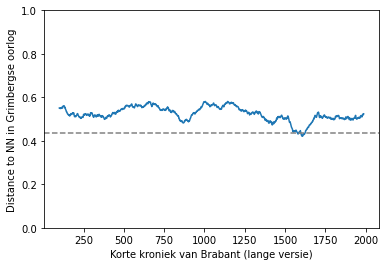

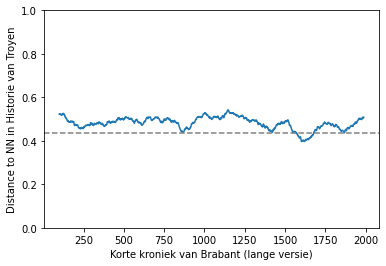

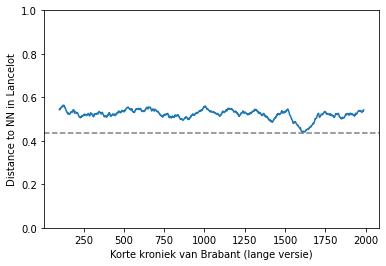

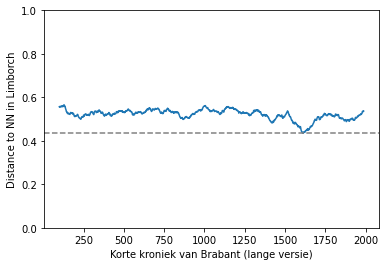

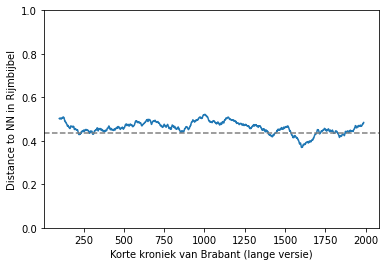

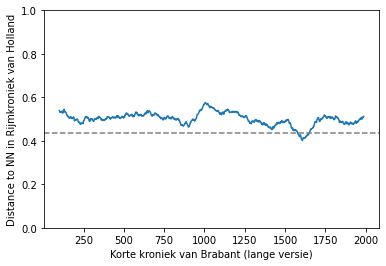

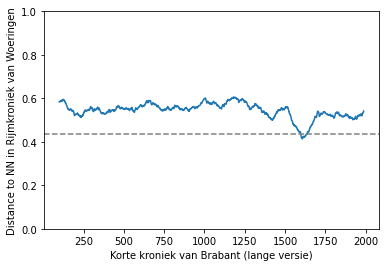

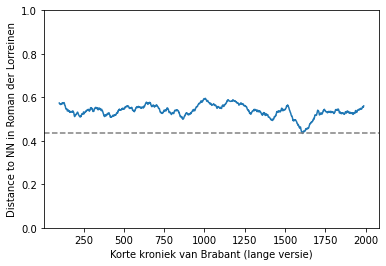

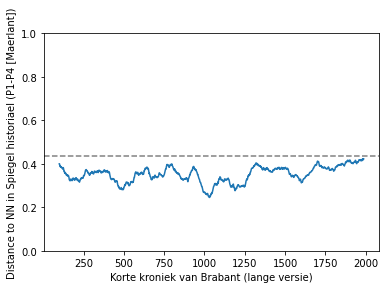

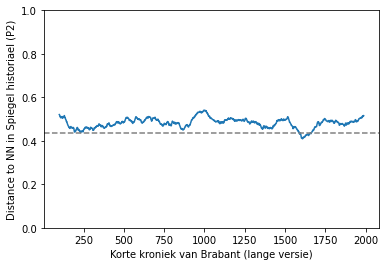

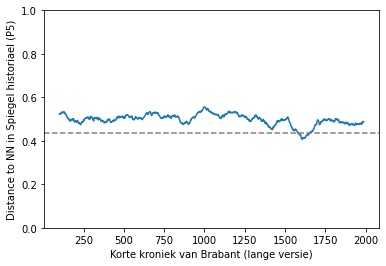

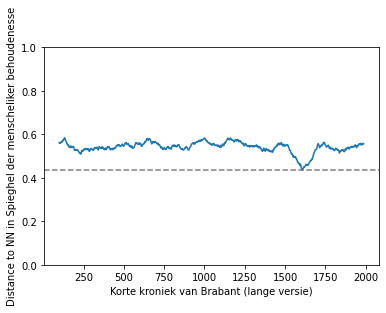

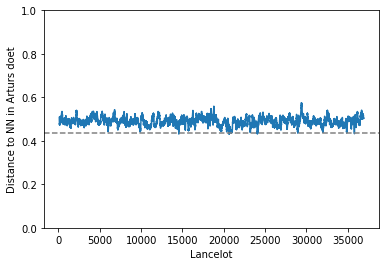

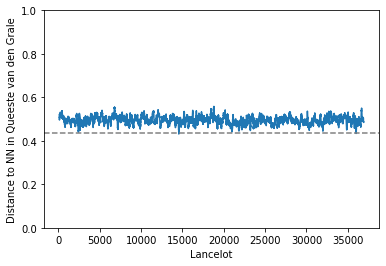

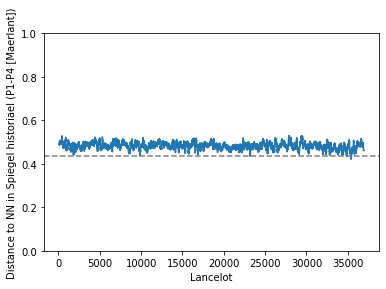

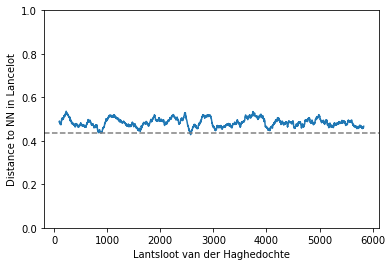

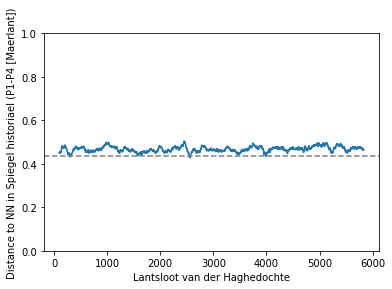

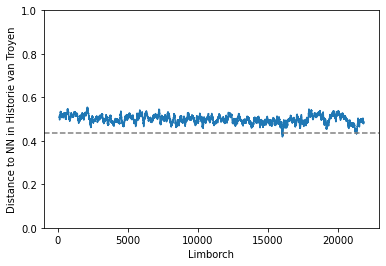

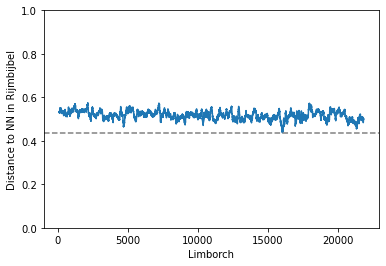

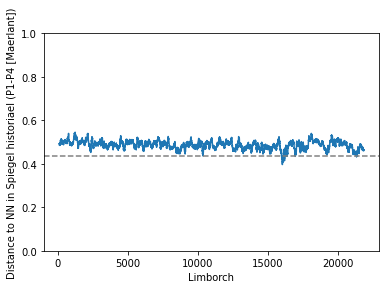

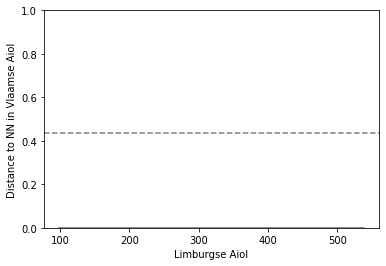

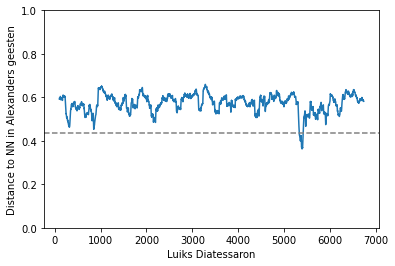

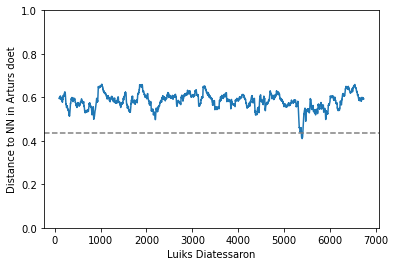

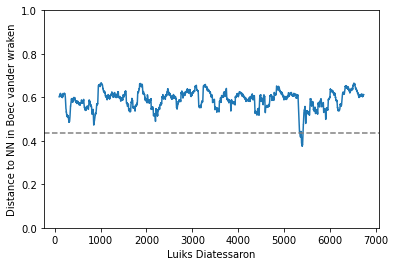

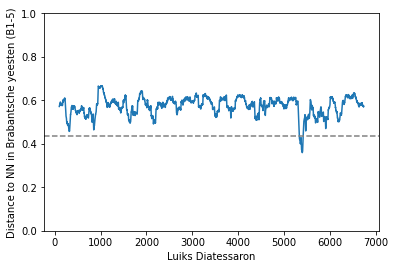

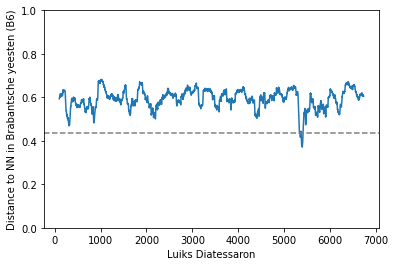

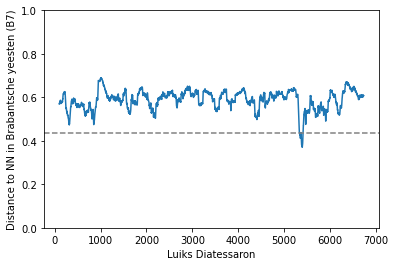

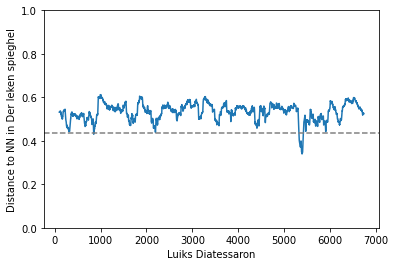

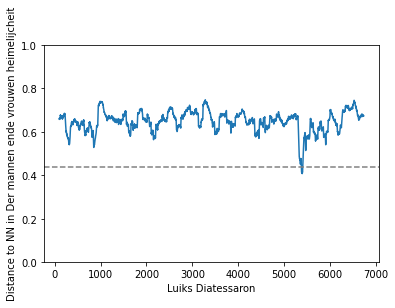

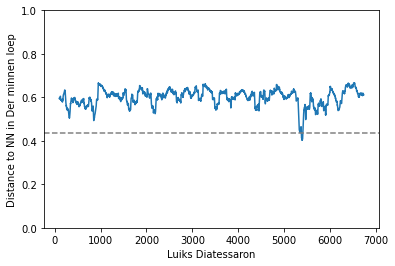

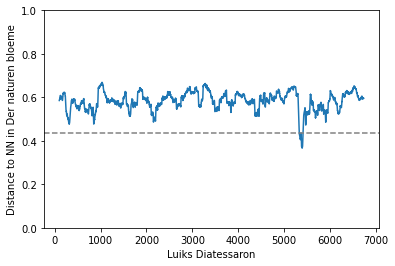

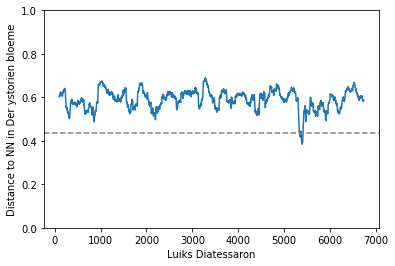

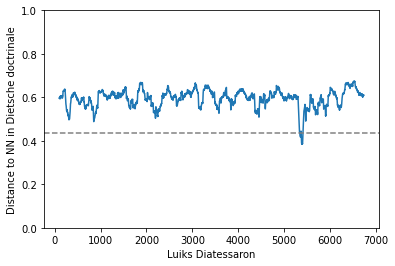

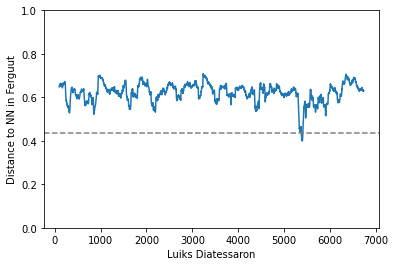

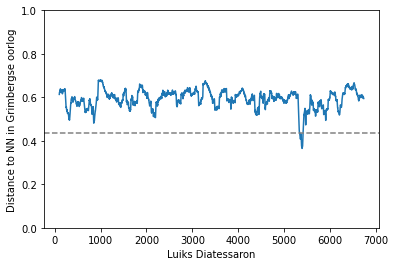

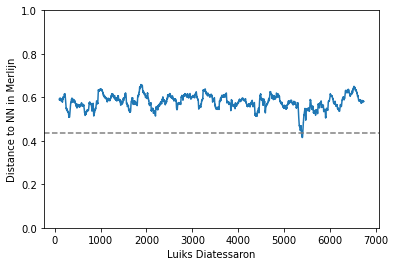

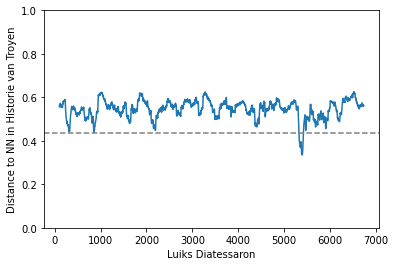

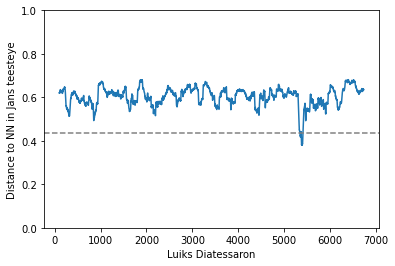

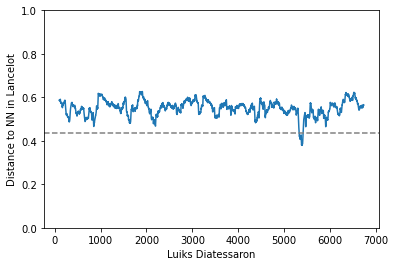

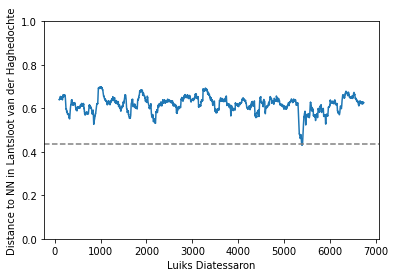

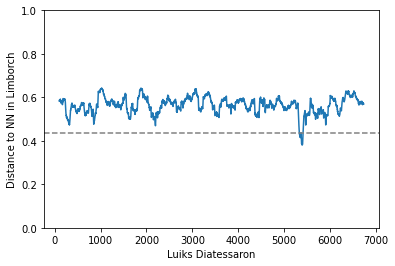

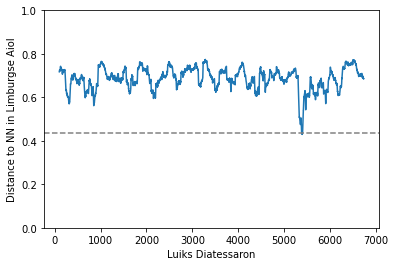

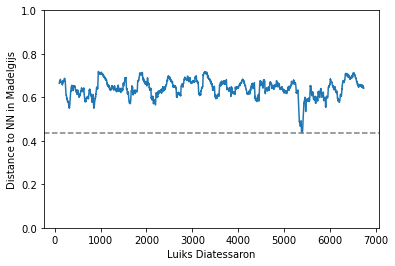

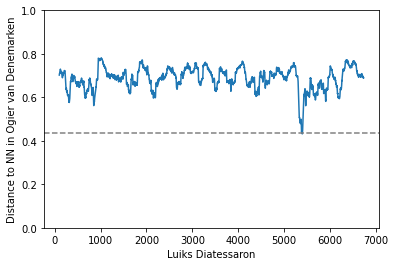

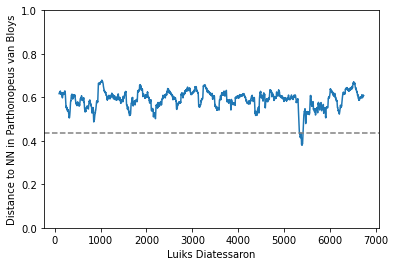

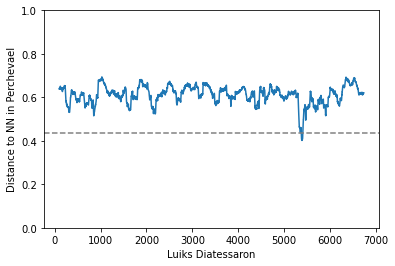

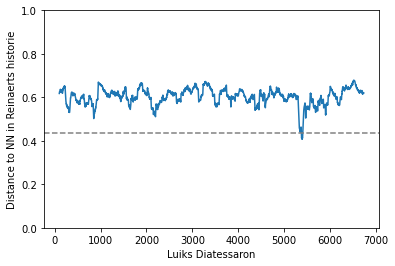

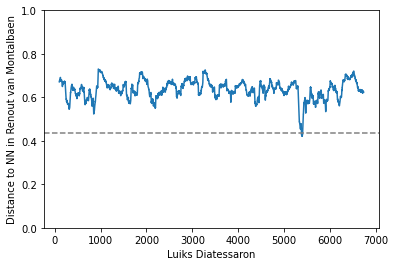

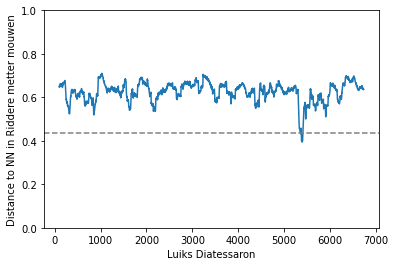

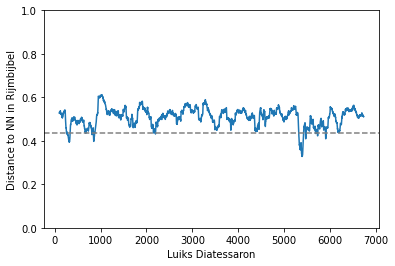

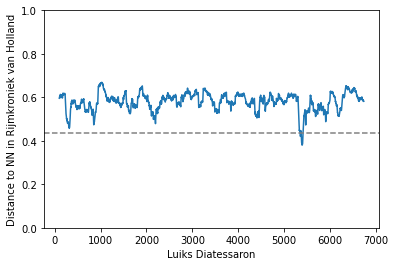

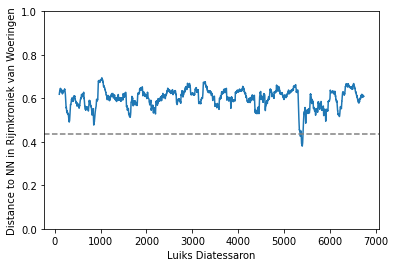

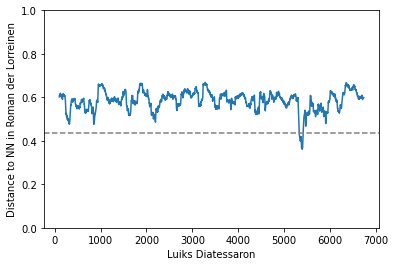

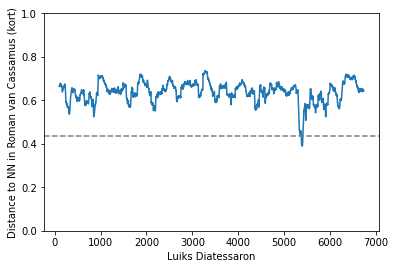

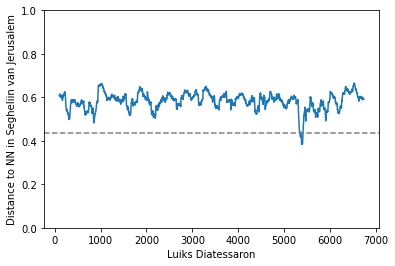

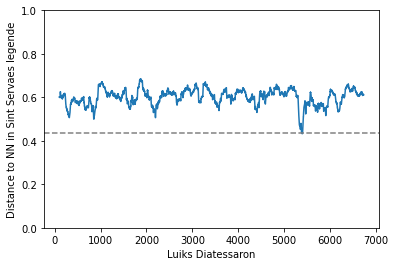

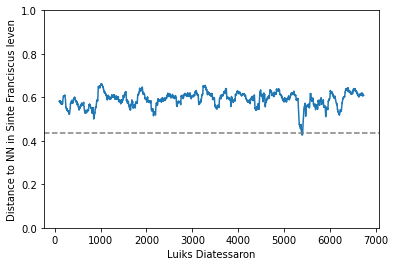

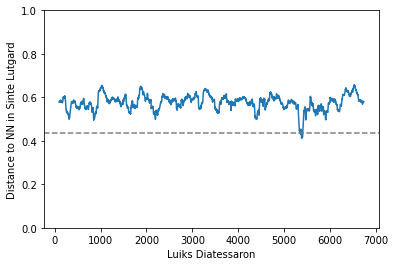

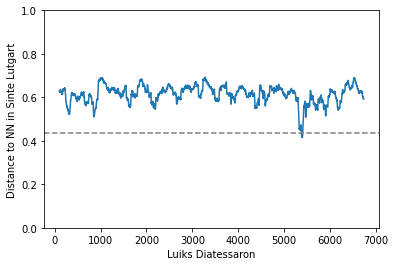

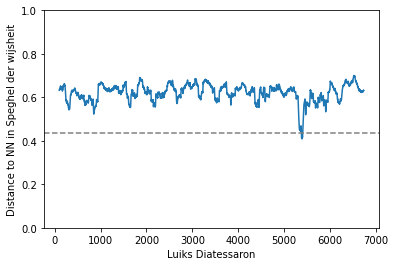

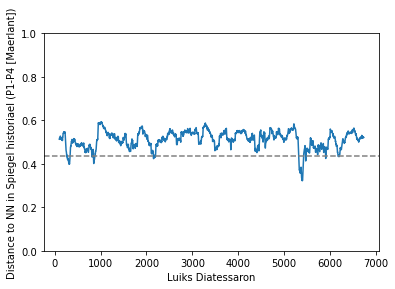

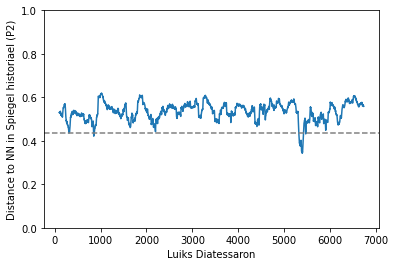

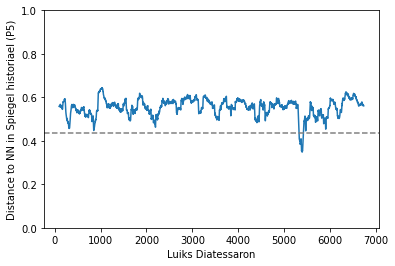

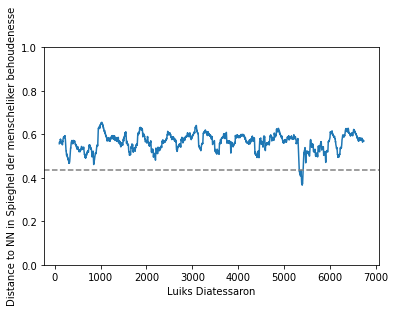

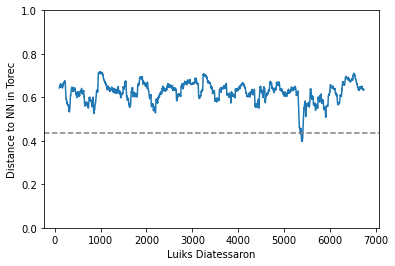

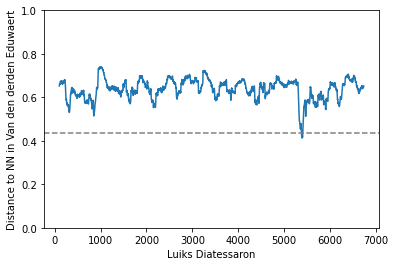

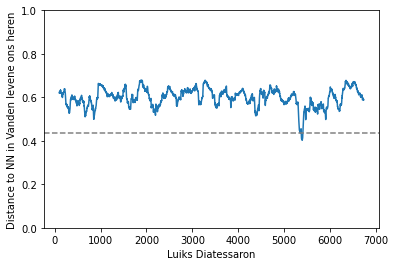

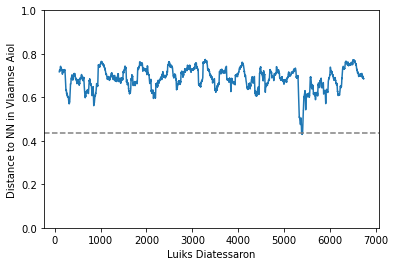

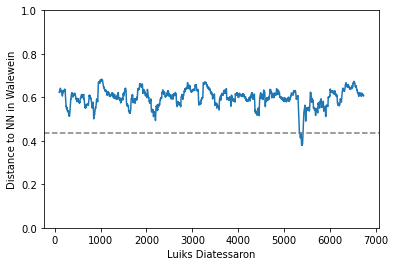

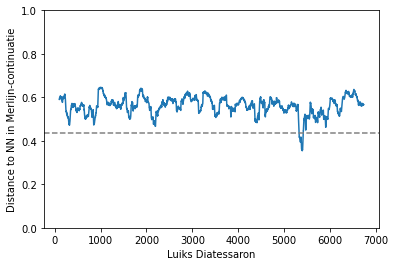

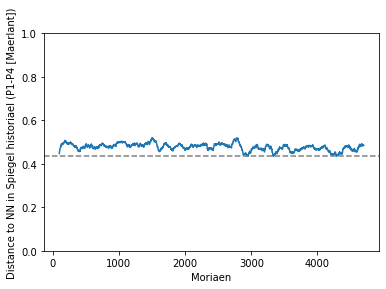

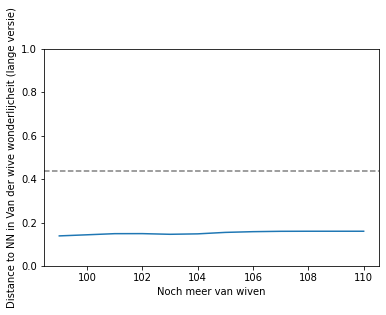

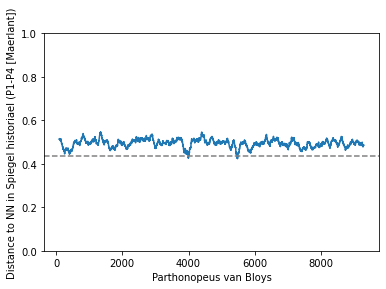

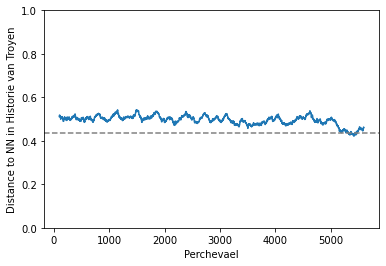

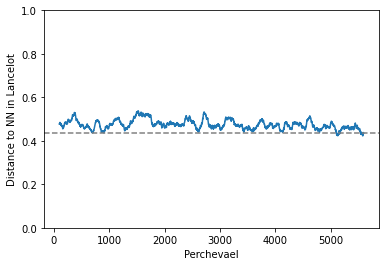

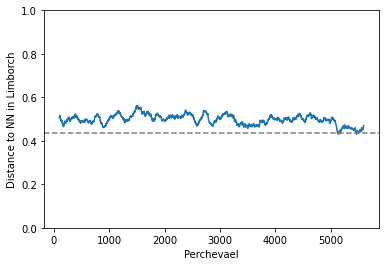

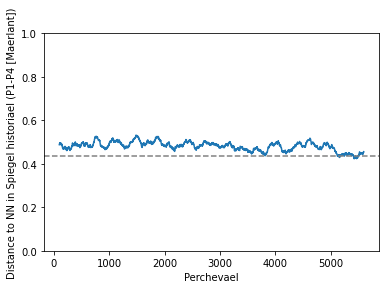

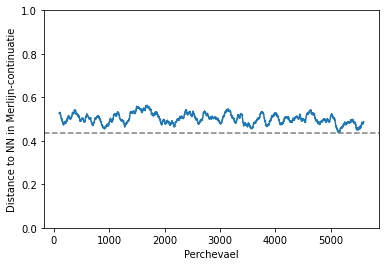

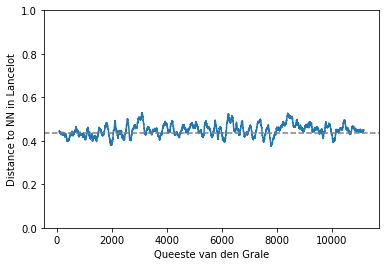

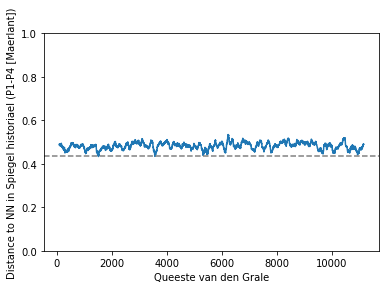

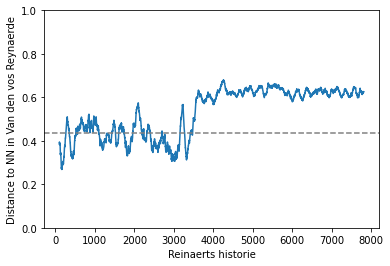

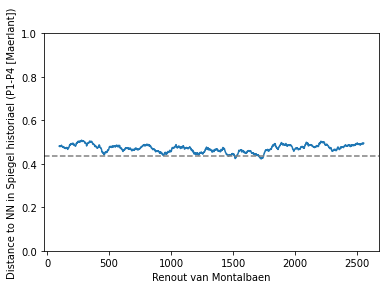

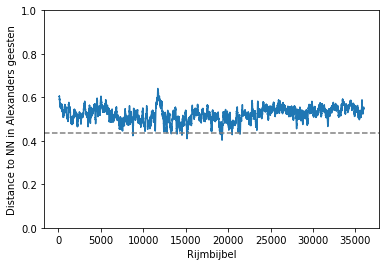

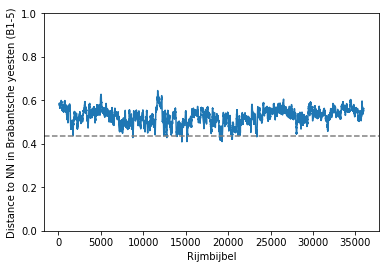

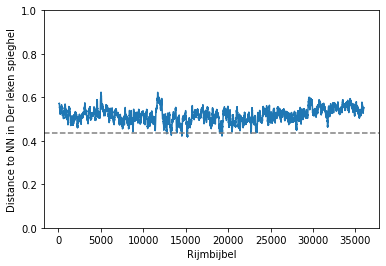

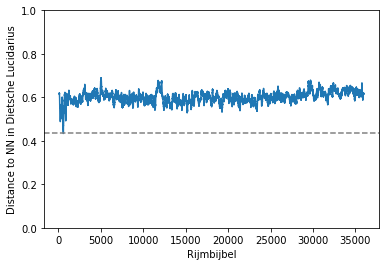

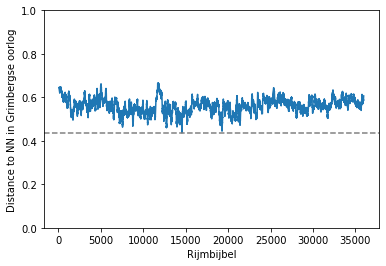

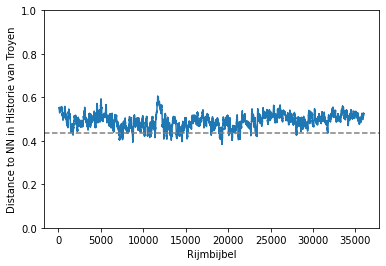

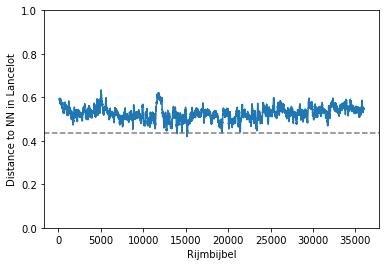

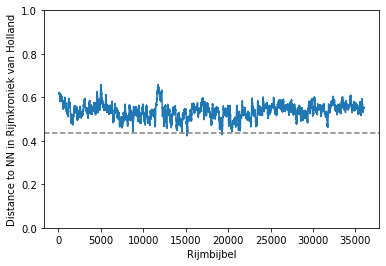

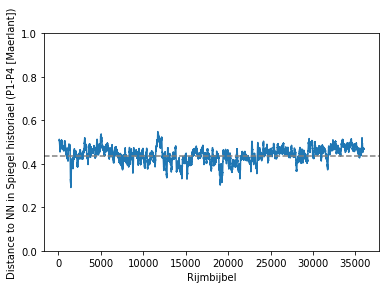

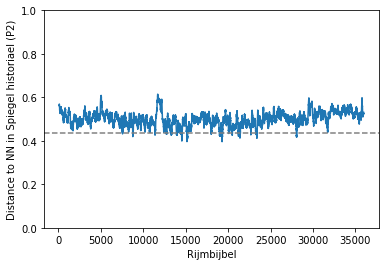

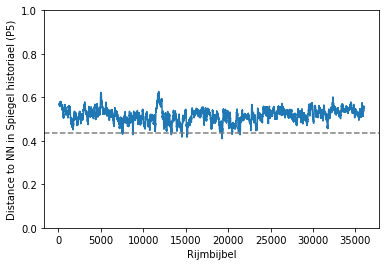

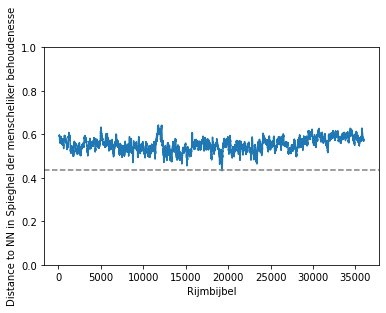

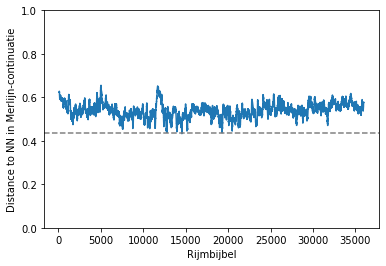

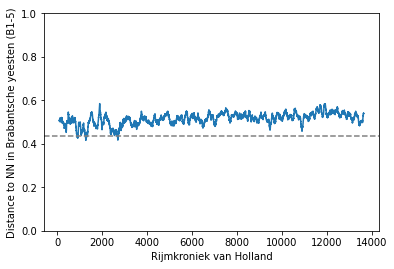

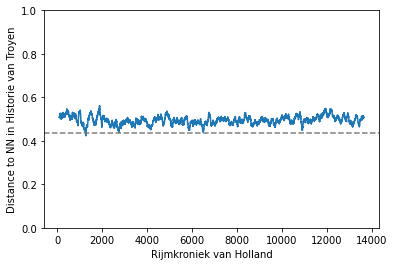

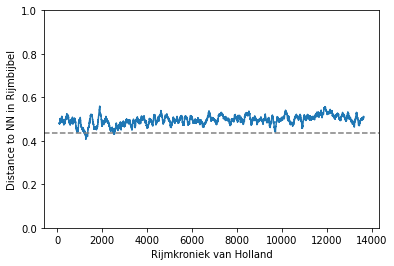

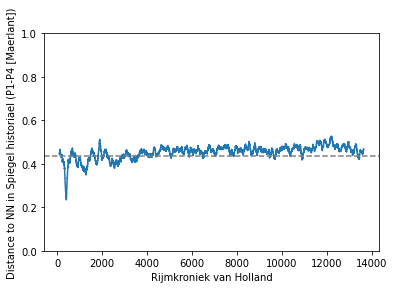

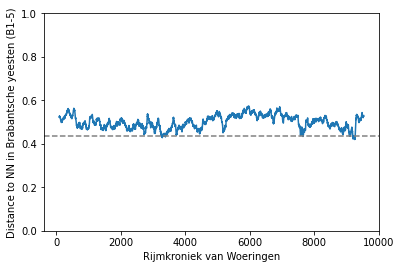

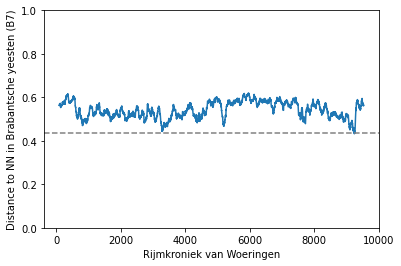

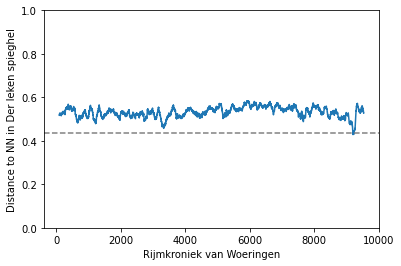

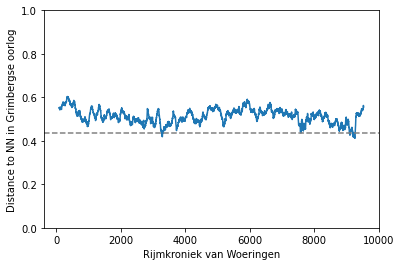

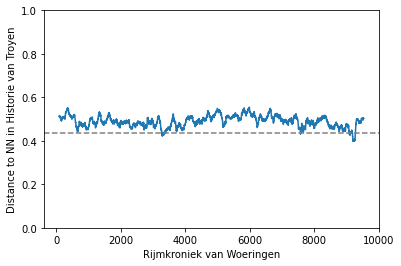

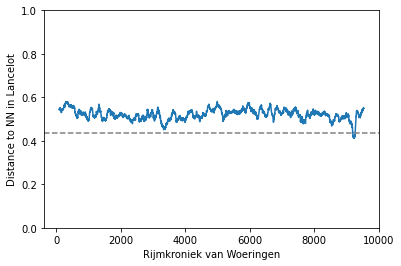

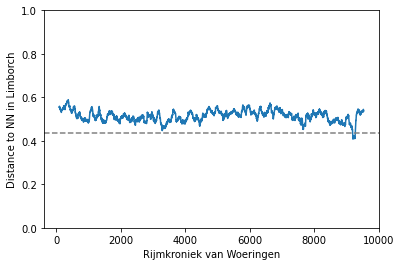

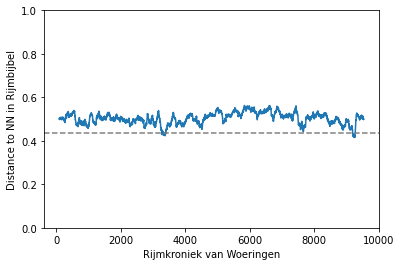

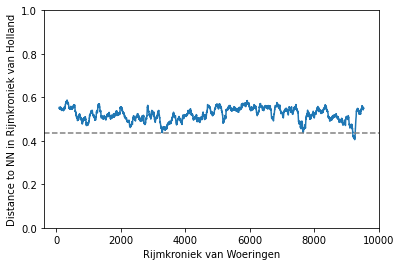

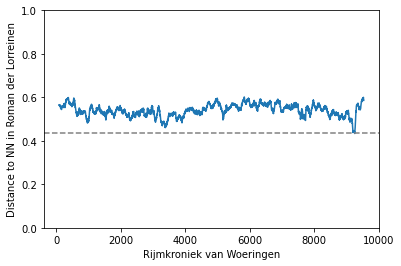

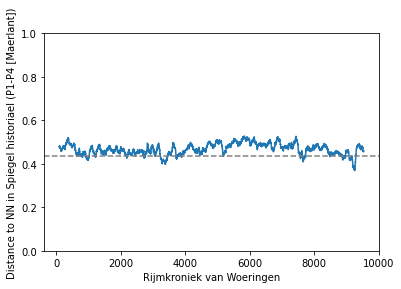

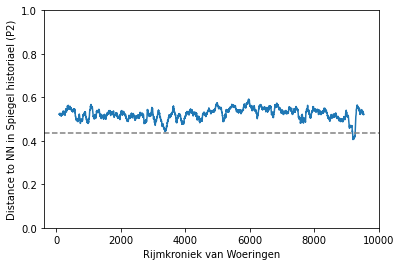

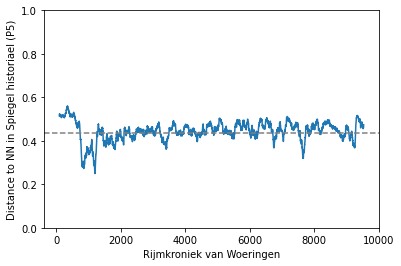

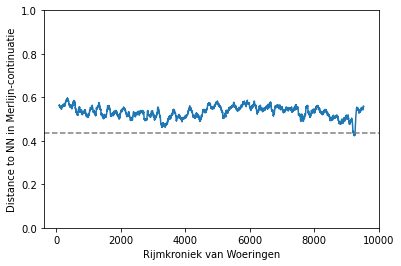

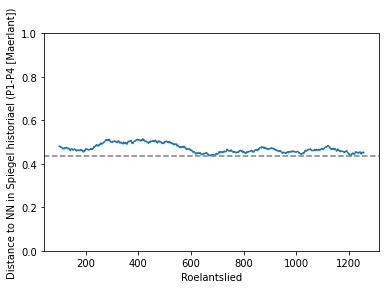

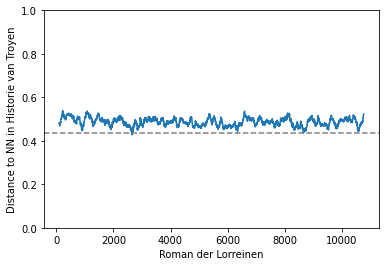

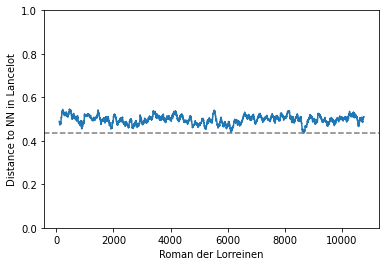

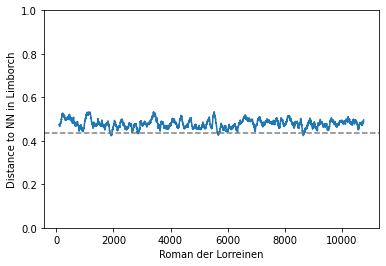

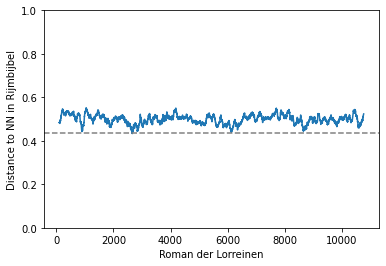

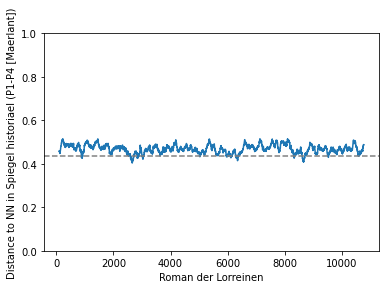

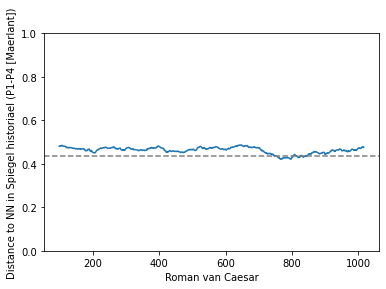

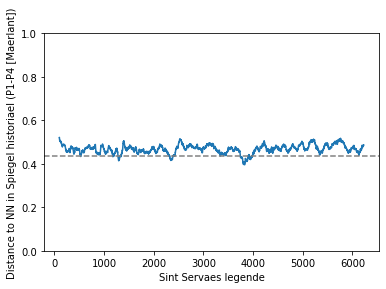

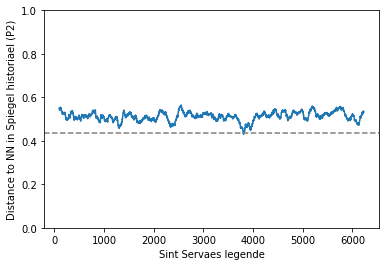

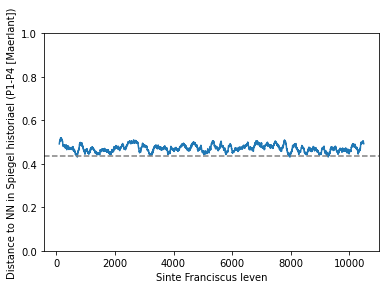

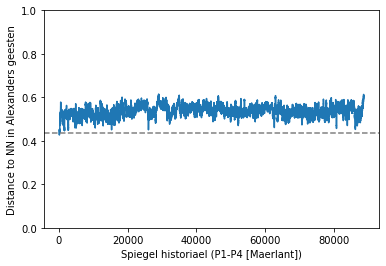

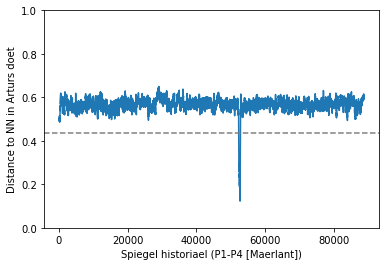

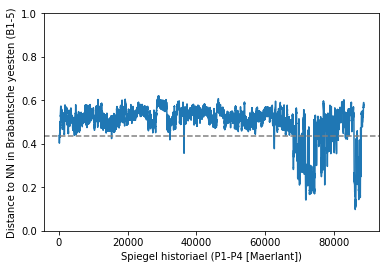

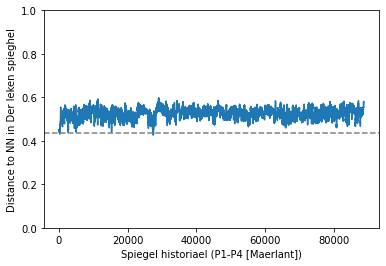

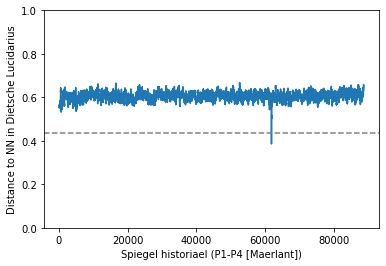

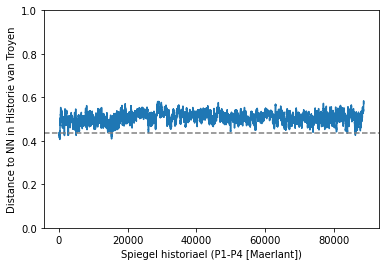

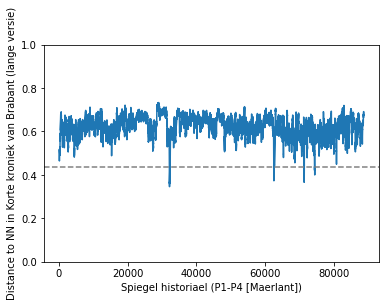

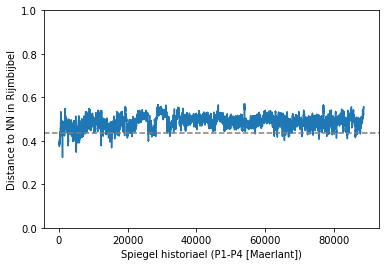

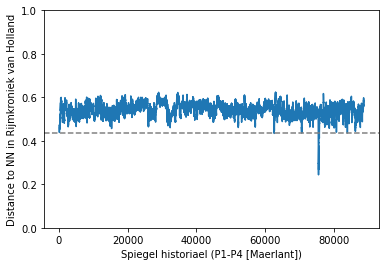

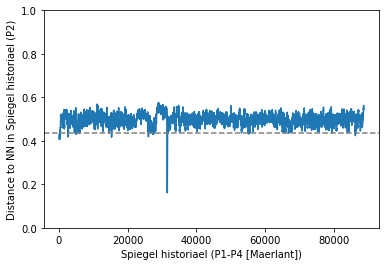

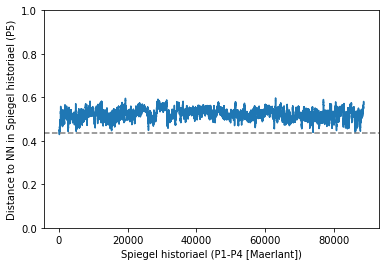

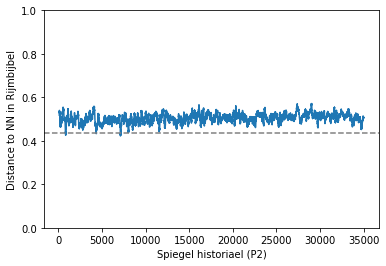

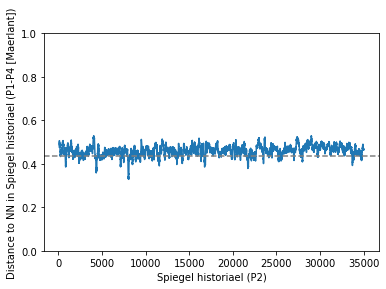

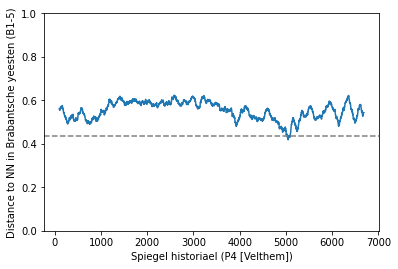

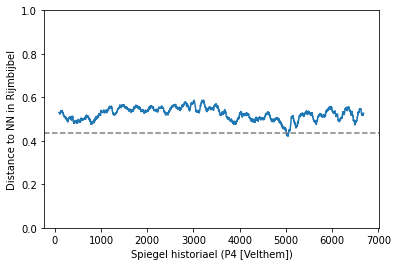

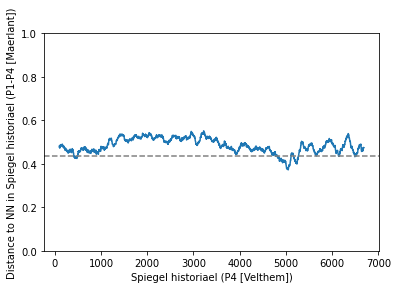

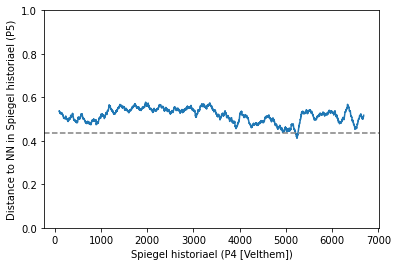

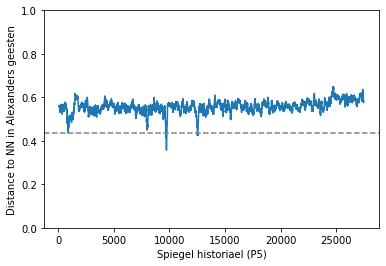

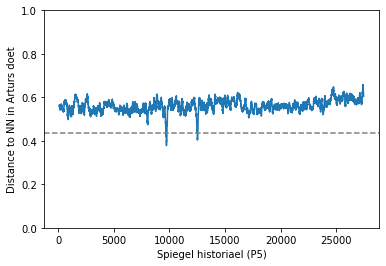

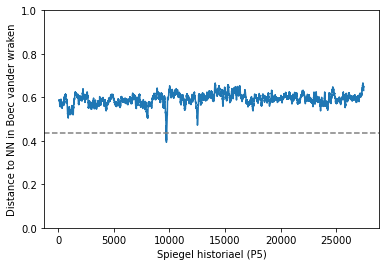

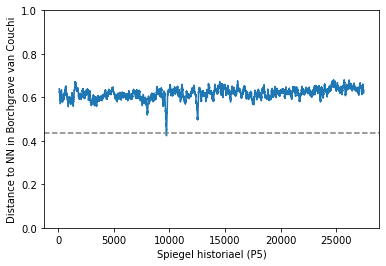

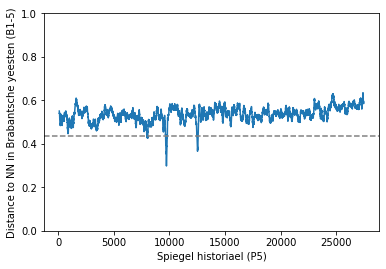

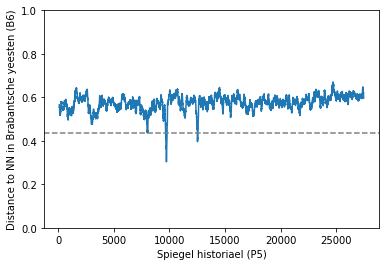

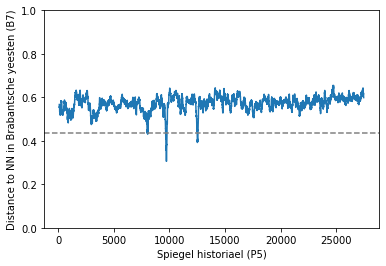

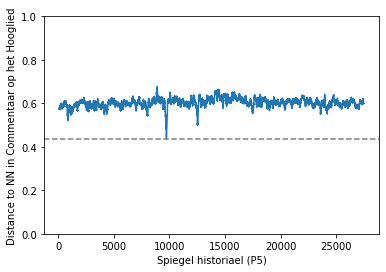

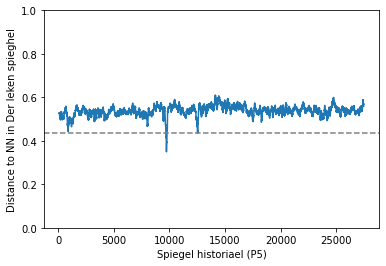

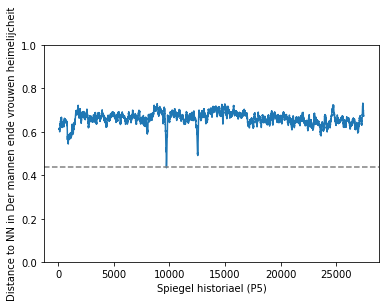

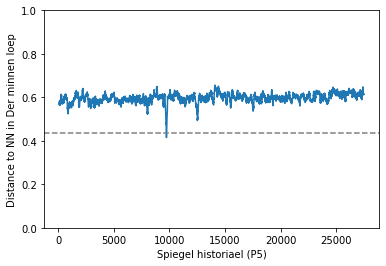

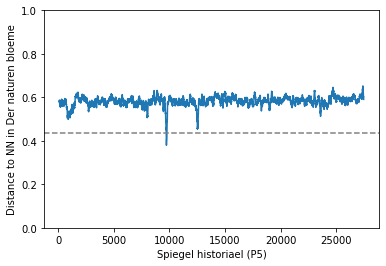

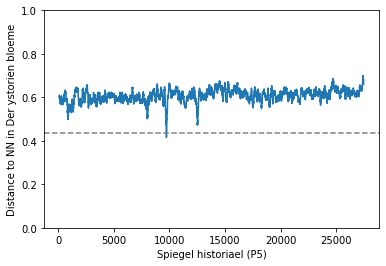

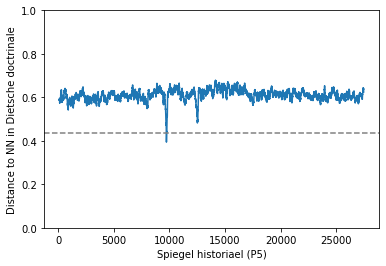

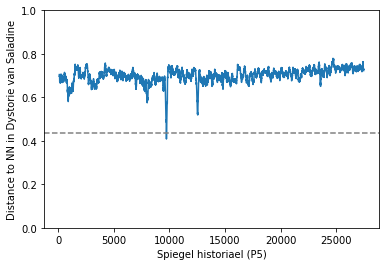

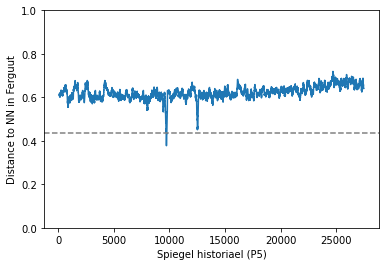

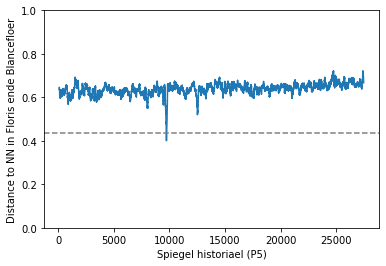

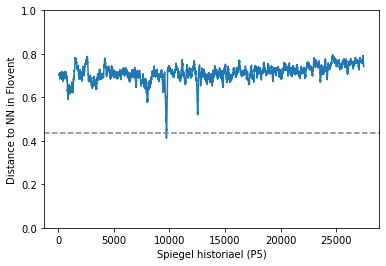

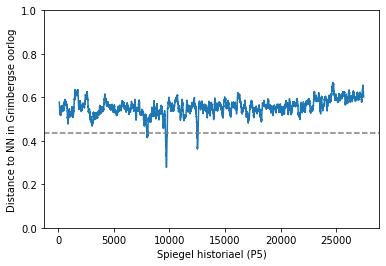

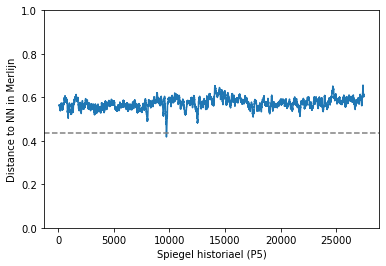

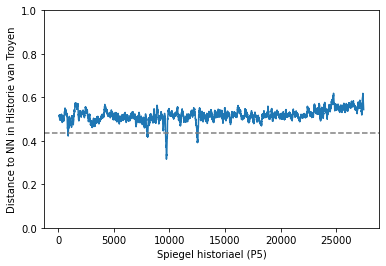

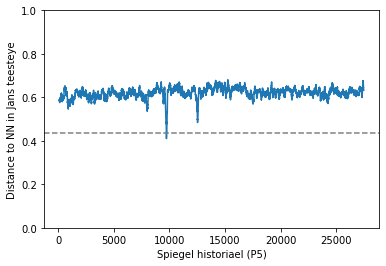

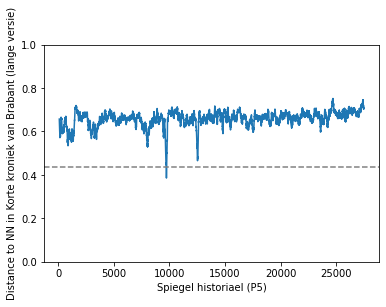

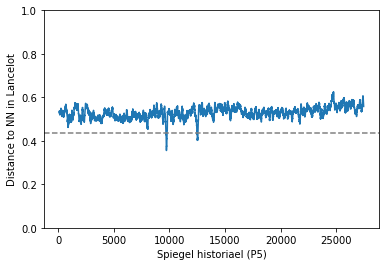

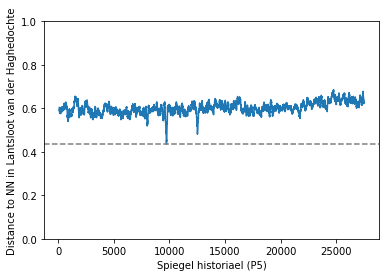

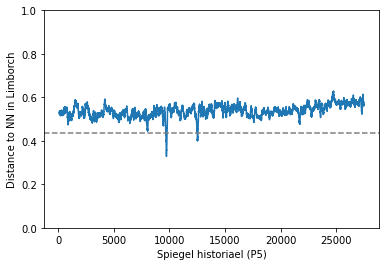

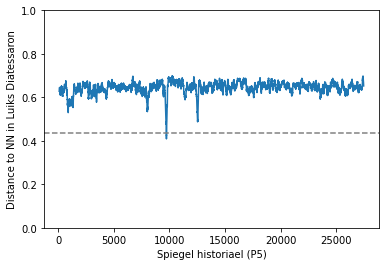

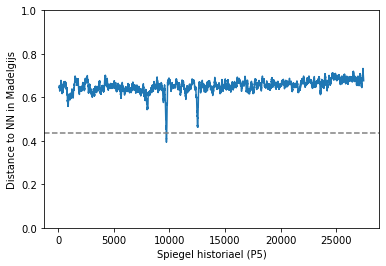

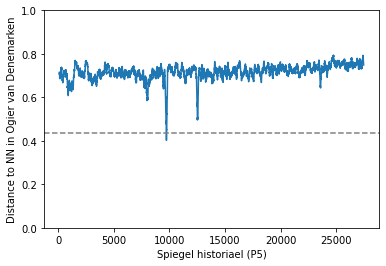

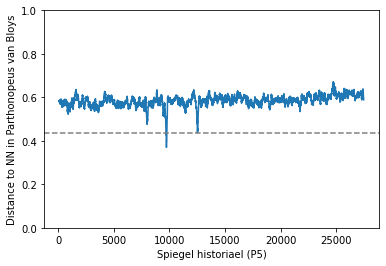

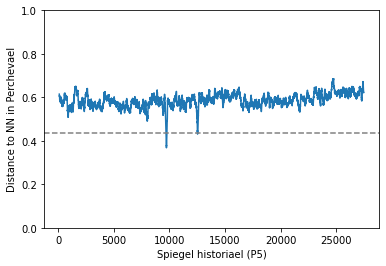

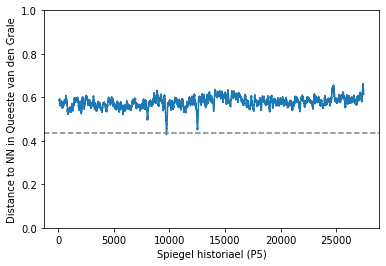

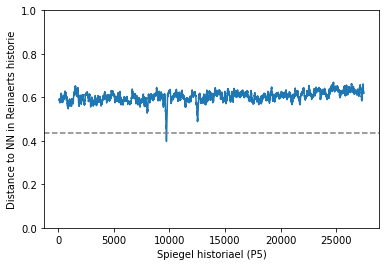

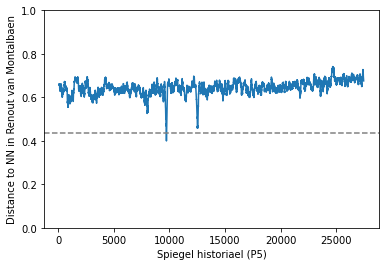

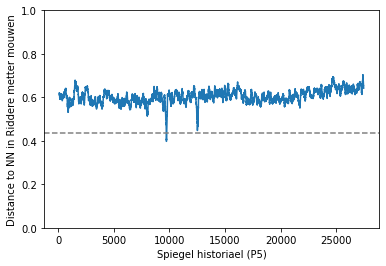

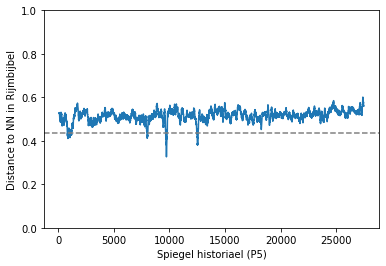

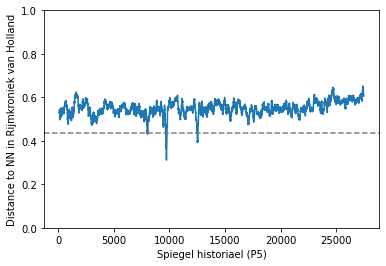

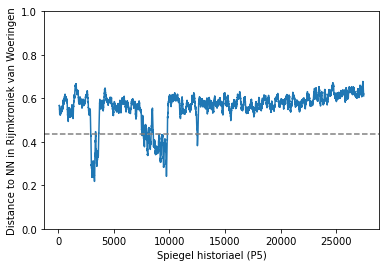

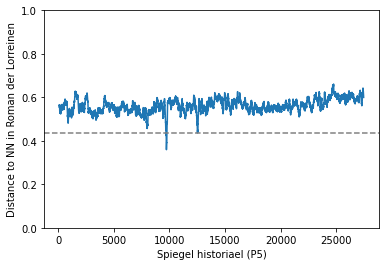

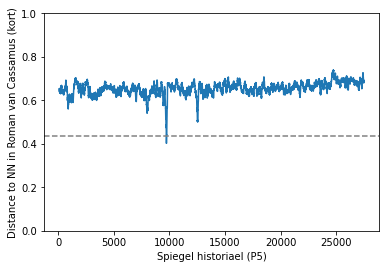

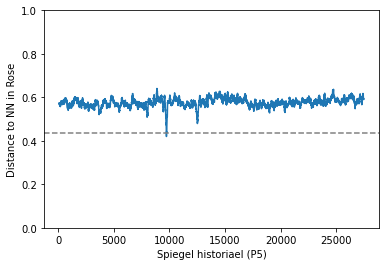

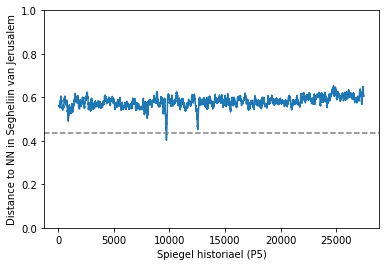

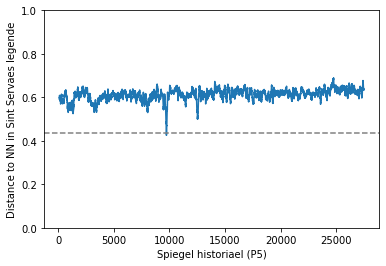

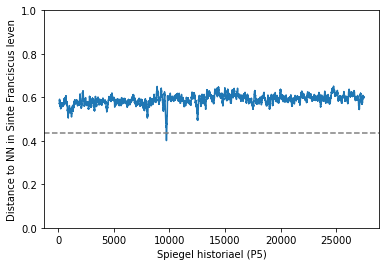

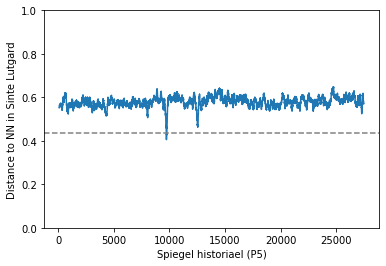

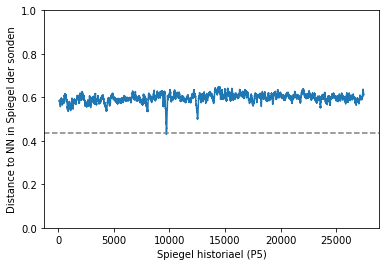

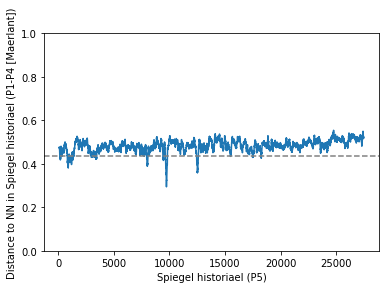

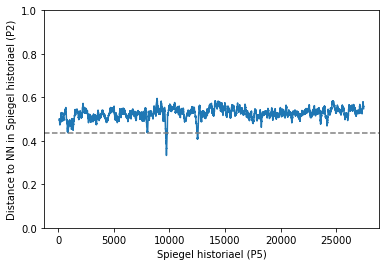

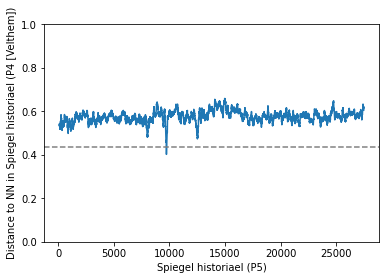

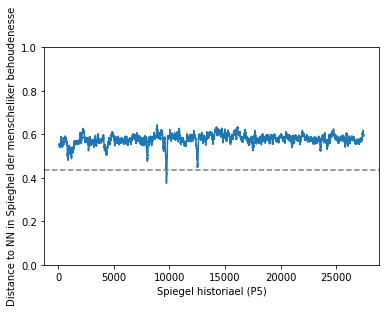

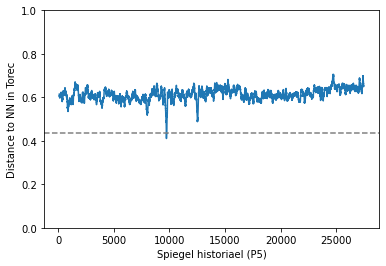

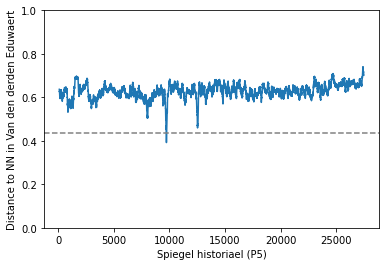

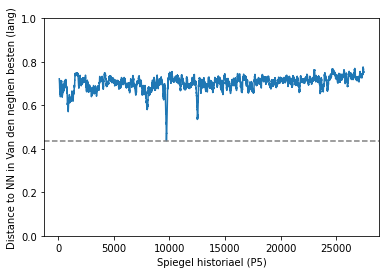

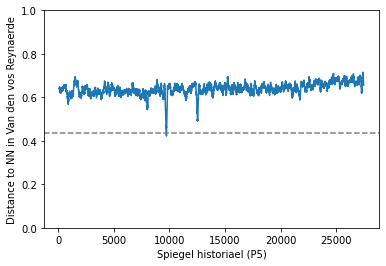

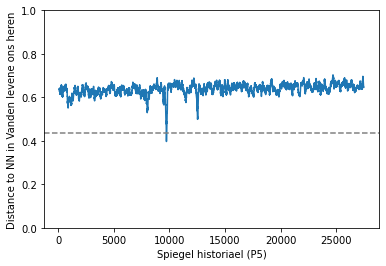

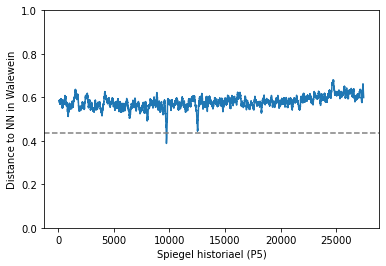

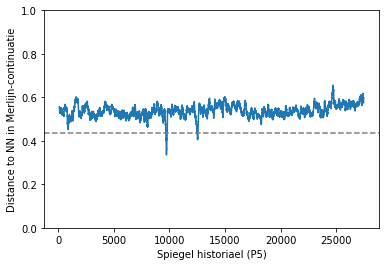

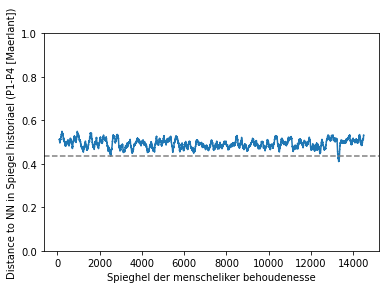

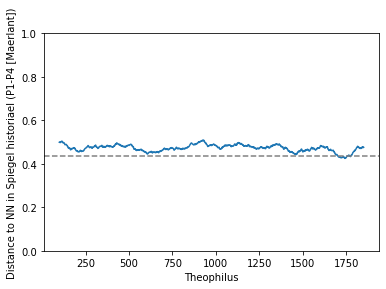

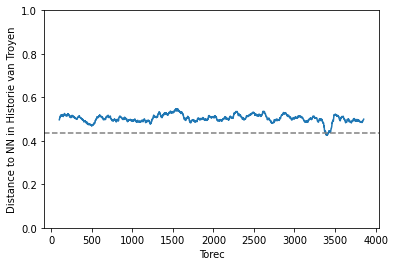

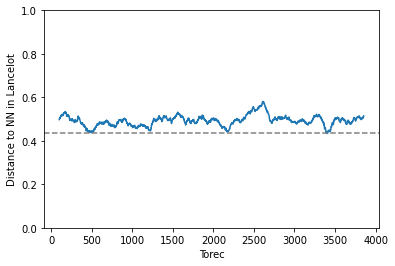

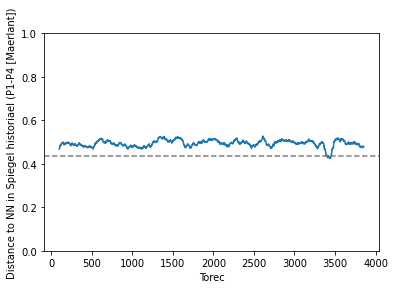

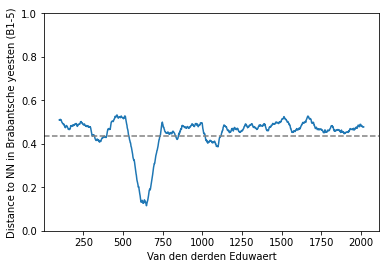

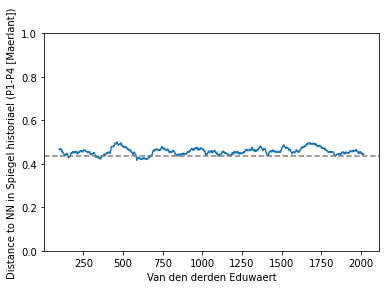

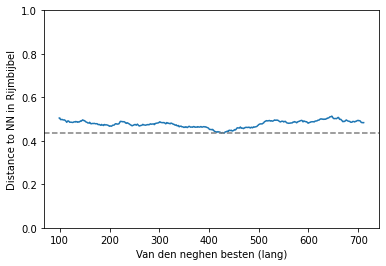

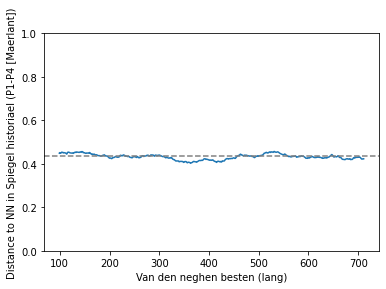

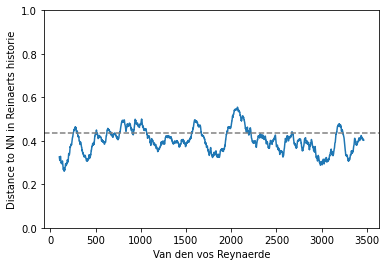

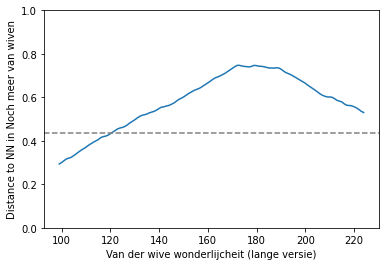

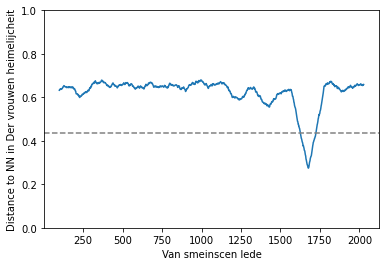

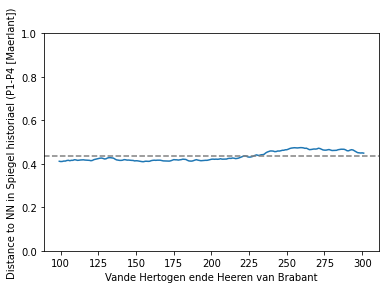

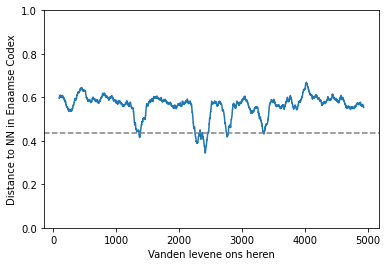

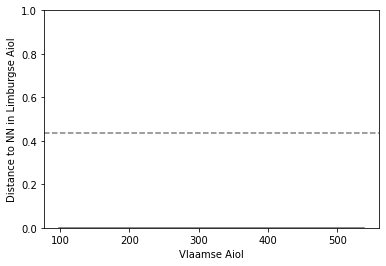

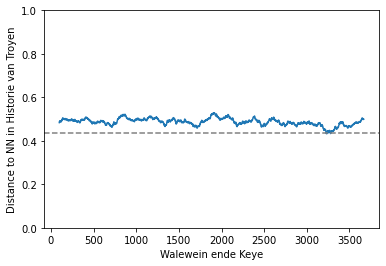

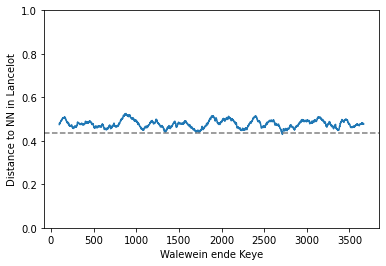

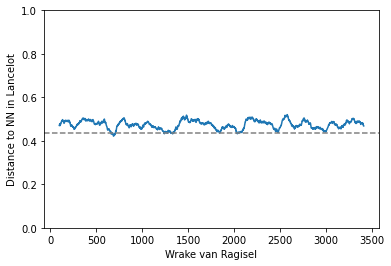

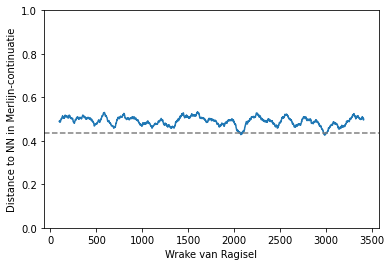

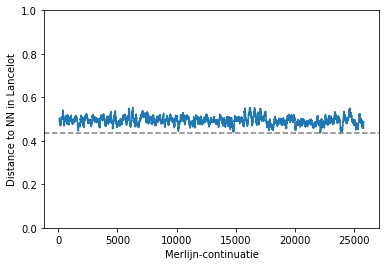

In [47]:
rolling_size = 100
for _, r in results.iterrows():
    if np.any(r['nn'].rolling(rolling_size).mean() < threshold):
        plot_min_distance_nn(r['t1'], r['t2'], r['nn'],
                             threshold=threshold, rolling_size=rolling_size);

Remarkable intertexts between:
- Lorreinen
- Limborch
- Rijmkroniek van Woeringen - Grimbergse oorlog: maar veelal beperkt tot strijdformules die telkens herhaald worden

## Meso-scale intertextuality

Case studies in sutbler intertextual connections as the MESO-scale. Fro this, we set the rhyme weight to 0.
- Prieel-scene Limborch vs Historie van Troyen
- River scene: Walewein vs Moriaen
- Hart-scene Ferguut vs Limborch

In [65]:
def load_meso_text(fn, title, group_size=None):
    work_tokens, work_lemmas = [], []
    for tok, lem, intertext_id in parse_xml(fn):
        work_tokens.append(tok)
        work_lemmas.append(lem)

    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]
    
    if not group_size:
        group_size = len(verse_tokens)

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=group_size))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=group_size))
    
    meso = pd.DataFrame(zip([title] * len(verse_group_tokens), verse_group_tokens, verse_group_lemmas),
                      columns=('title', 'tokens', 'lemmas'))
    meso = add_rhyme_column(meso)
    
    return group_size, meso

def top_meso(A, B, rhyme_weight, k=3):
    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    D = pd.Series(pairwise_distances(BX, AX, metric='cosine').min(axis=1))
    top_idxs = D.argsort()[:k]
    top_hits = B.iloc[top_idxs].copy()
    top_hits['distance'] = D[top_idxs]
    return top_hits

In [66]:
group_size, prieel = load_meso_text(fn='../data/meso/prieel.xml', title='Prieel')
_, HvT = load_meso_text(fn='../data/xml/roman_van_limborch.xml', title='Limborch',
                        group_size=group_size)
top_meso(prieel, HvT, rhyme_weight=0, k=20)

title  \
7369   Limborch   
7363   Limborch   
7370   Limborch   
7364   Limborch   
19282  Limborch   
7362   Limborch   
7365   Limborch   
19281  Limborch   
7366   Limborch   
7368   Limborch   
19283  Limborch   
7367   Limborch   
19277  Limborch   
19284  Limborch   
12184  Limborch   
12185  Limborch   
19289  Limborch   
19280  Limborch   
19285  Limborch   
19286  Limborch   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             tokens  \
7369   Soe langhe reet die ridder coene / Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer / Dat wonder te seggen ware / Die ridder peinsde eer ic vort vare / Willic mi hier een luttel rusten / Het mochts elken mensce lusten / Te rustene in alsoe sconer stede / Hi beete neder ende dede / Siin ors peistren gaen int gras                                  
7363   Ende voeren te Grieken waert / Nu latic staen van hare vaert / Ende seggu van Echites voert / Dien de minne sere cort / Ende reet berch ende dal / Gode hi hem altoes beval / Soe langhe reet die ridder coene / Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer / Dat wonder te seggen ware                                                              
7370   Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer / Dat wonder te seggen ware / Die ridder peinsde eer ic vort vare / Willic mi hier een luttel rusten / Het mochts elken mensce lusten / Te rustene in alsoe sconer stede / Hi beete neder ende dede / Siin ors peistren gaen int gras / Hi ghinc liggen als ict las                                       
7364   Nu latic staen van hare vaert / Ende seggu van Echites voert / Dien de minne sere cort / Ende reet berch ende dal / Gode hi hem altoes beval / Soe langhe reet die ridder coene / Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer / Dat wonder te seggen ware / Die ridder peinsde eer ic vort vare                                                       
19282  Die daer waren in die stede / Waerliic ic mach u seggen dat / Dat ene die liefeliicste stad / Was die men mochte visieren / Daer wiesen boeme meneghertieren / Die drougen menegerande vrucht / Soete ende coele was daer de lucht / Soe datter te menegher stad met pinen / Die sonne en conste dore scinen / Oec sprongen daer fonteynen een deel / Die sere ververschten dat proyeel / Int proyeel dat ic u noeme / Stont menege roese ende bloeme / Daer waren die conincge geseten / Bi der ghere die hem vergheten       
7362   Ghereiden hem met bliitheden / Ende voeren te Grieken waert / Nu latic staen van hare vaert / Ende seggu van Echites voert / Dien de minne sere cort / Ende reet berch ende dal / Gode hi hem altoes beval / Soe langhe reet die ridder coene / Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer                                     

Walewein-passage in Moriaen: vs. 3676 (*Mettien quam hi up ene riviere*) t.e.m. vs. 3856 (*Ende hare twier scachte braken*)

In [69]:
group_size, rivier = load_meso_text(fn='../data/meso/rivier.xml', title='Rivier')
_, Mor = load_meso_text(fn='../data/xml/roman_van_moriaen.xml', title='Moriaen',
                        group_size=group_size)
display(rivier)
top_meso(rivier, Mor, rhyme_weight=0, k=3)

title  \
0  Rivier   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

title  \
1221  Moriaen   
1222  Moriaen   
1220  Moriaen   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Naar [Knuttel](https://www.dbnl.org/tekst/_tij003194401_01/_tij003194401_01_0003.php).
Hart-passage (niet duidelijk afgegrensd door eerdere onderzoekers) uit Ferguut: vs. 1365 (*Arger ben ic dan een dief*) - vs. 1453 (*Algader hoet met haer stoet ende ware*)

In [68]:
group_size, hart = load_meso_text(fn='../data/meso/hart.xml', title='Hart')
_, Lim = load_meso_text(fn='../data/xml/roman_van_limborch.xml', title='Limborch',
                        group_size=group_size)
display(hart)
top_meso(hart, Lim, rhyme_weight=0, k=1)

title  \
0  Hart   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                tokens  \
0  Arger ben ic dan een dief / Dat ic den genen wille hebben lief / Die ic noit en sach meer dan heden / Noch en sprac in eneger steden / Morgen so sal hi orlof / Betide nemen ende ltrumen thofgt / Dan sal hi nemmer van mi weten / Saen sal hi mijns vergeten / In weet hoes hem gedinken mochte / Dade hi altenen in sijn gedochte / Daer hi quame alle ioncfrouwen / Het ware heme quaet te minen trouwen / Hi vaert tielec wech metten dage / Hoe sal hi geweten mine clage / Hoe wel dat icken minnen mach / Hi sal mi geuen den doet slach / Wisti dat ic in selken vare / In allen stonden dore hem ware / Hine dade nemmer die dorperheltidegt / Dat hi mi sine minne ontseide / Secgict hem niet hine weet nommer / Wi seggict hem ic segge mi commer / Waer soudic nemen die gedachte / Ic soude onneren mijn geslachte / Ic lage mi lieuer jndie doet kiste / Dan hijt van minen monde wiste / Wat doe ic dan ic sal wech vlien / Om enen andren salic spien / In willen sien in al mijn leuen / Mijn vader wille mi emmer geuen / Enen hogen princ

title  \
5260  Limborch   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             tokens  \
5260  Op siin bedde gheleghen quam / Was hi stappans ontslapen / Want hi moede was van wapen / Europa die scone jonfrouwe / Die met herde groten rouwe / Te bedde ghinc om sridders wille / Seide tote hare selven stille / Ja en ben ic keytivinne / Dat ic dus haestelec mine minne / Hebbe geleit an enen man / Die vremde es ende wattan / Ende es van der werelt bloeme / Van ridderscape die ic noeme / Ende hoe soudict ghelaten / Nieman en mochten haten / Hi es scone ende welgheraect / Ende in allen dogeden volmaect / Helpe ende sal ics moeten derven / Soe sal ic cortelike besterven / Besterven moet ict keytivinne / Helpe wat doet mi de minne / Ic ben dat armste wiif / Die nie ontfinc ter werelt liif / Dat ic hebbe in minen lande / Ende in miin huus ende in dar bestanden / Jeghen hem spreken gaen / Bi gode ic wilt nochtan bestaen / Al wouden siit alle zien ende hoeren / Die te minen lande horen / Doe stoet op die welghedane / Ende dede hare pelsken ane / Mettien bepeisese hare / Dats hoe grote scande het ware / Seide si thaer selven of ment sage / Ic werde ghelachtert alle dage / Ic moet laten dore den lachter / Ic sal nochtan achter / Laten dore der lieder tale / Die mi

But would it have selected the hart-passage from *all texts*?

In [77]:
nns = []
group_size, hart = load_meso_text(fn='../data/meso/hart.xml', title='Hart')
chiv = meta_df[meta_df['genre'] == 'Epiek'][['id', 'title']]
for fn, title in zip(chiv['id'], chiv['title']):
    print(fn, title)
    try:
        _, trg = load_meso_text(fn=f'../data/xml/{fn}.xml', title=title,
                                group_size=group_size)
        nn = top_meso(hart, trg, rhyme_weight=0, k=1)
        nns.append(nn)
    except ValueError:
        continue

alexanders_geesten Alexanders geesten
Alexiuslegende Alexiuslegende
anatomie_van_de_mens Anatomie van de mens
arturs_doet Arturs doet
aubri_de_borgengoen Aubri de Borgengoen
barlaam_en_josaphat_fragm_go Barlaam en Josaphat
barlaam_en_josaphat_fragm_ge Barlaam en Josaphat
beatrijs Beatrijs
bediedenisse_van_der_missen Bediedenisse van der missen
beerte_metten_breden_voeten Beerte metten breden voeten
beginsel_der_oorlogen_van_luyck Beginsel der oorlogen van Luyck
boec_exemplaer Boec Exemplaer
boec_van_den_houte Boec van den houte
dat_boec_vander_wraken Boec vander wraken
Boeve van Hamtone Boeve van Hamtone
borchgrave_van_couchi Borchgrave van Couchi
borchgrave_van_couchi_fragm_a Borchgrave van Couchi
borchgrave_van_couchi_fragm_br Borchgrave van Couchi
borchgrave_van_couchi_fragm_dp Borchgrave van Couchi
borchgravinne_van_vergi__1 Borchgravinne van Vergi (1)
borchgravinne_van_vergi__2 Borchgravinne van Vergi (2)
boudewijn_van_seborch_fragm_a Boudewijn van Seborch
boudewijn_van_seborch_fr

spiegel_historiael__4_velthem__fragm_we Spiegel historiael (P4 [Velthem])
spiegel_historiael__4_velthem__fragm_brs Spiegel historiael (P4 [Velthem])
spiegel_historiael__4_velthem__fragm_m Spiegel historiael (P4 [Velthem])
spiegel_historiael__4_velthem__fragm_l Spiegel historiael (P4 [Velthem])
spiegel_historiael__5 Spiegel historiael (P5)
de_spieghel_der_menscheliker_behoudenesse Spieghel der menscheliker behoudenesse
theophilus Theophilus
tien_plaghen Tien plaghen ende die tien ghebode
roman_van_torec Torec
Tristant Tristant
valentijn_en_nameloos_fragm_be Valentijn en Nameloos
valentijn_en_nameloos_fragm_ge Valentijn en Nameloos
van_den_derden_eduwaert Van den derden Eduwaert
van_den_neghen_besten__kort Van den neghen besten (kort)
van_den_neghen_besten__lang Van den neghen besten (lang)
van_den_vii_vroeden_van_binnen_rome Van den VII Vroeden van binnen Rome
van_den_vijf_vrouden Van den vijf vrouden
van_den_vos_reynaerde Van den vos Reynaerde
maanzodiologium Van der manen zeden
van_de

Rivier-passage?

In [83]:
nns = []
group_size, rivier = load_meso_text(fn='../data/meso/rivier.xml', title='Rivier')
chiv = meta_df[meta_df['genre'] == 'Epiek'][['id', 'title']]
for fn, title in zip(chiv['id'], chiv['title']):
    print(fn, title)
    try:
        _, trg = load_meso_text(fn=f'../data/xml/{fn}.xml', title=title,
                                group_size=group_size)
        nn = top_meso(rivier, trg, rhyme_weight=0, k=1)
        nns.append(nn)
    except ValueError:
        continue

alexanders_geesten Alexanders geesten
Alexiuslegende Alexiuslegende
anatomie_van_de_mens Anatomie van de mens
arturs_doet Arturs doet
aubri_de_borgengoen Aubri de Borgengoen
barlaam_en_josaphat_fragm_go Barlaam en Josaphat
barlaam_en_josaphat_fragm_ge Barlaam en Josaphat
beatrijs Beatrijs
bediedenisse_van_der_missen Bediedenisse van der missen
beerte_metten_breden_voeten Beerte metten breden voeten
beginsel_der_oorlogen_van_luyck Beginsel der oorlogen van Luyck
boec_exemplaer Boec Exemplaer
boec_van_den_houte Boec van den houte
dat_boec_vander_wraken Boec vander wraken
Boeve van Hamtone Boeve van Hamtone
borchgrave_van_couchi Borchgrave van Couchi
borchgrave_van_couchi_fragm_a Borchgrave van Couchi
borchgrave_van_couchi_fragm_br Borchgrave van Couchi
borchgrave_van_couchi_fragm_dp Borchgrave van Couchi
borchgravinne_van_vergi__1 Borchgravinne van Vergi (1)
borchgravinne_van_vergi__2 Borchgravinne van Vergi (2)
boudewijn_van_seborch_fragm_a Boudewijn van Seborch
boudewijn_van_seborch_fr

spiegel_historiael__4_velthem__fragm_wr Spiegel historiael (P4 [Velthem])
spiegel_historiael__4_velthem__fragm_we Spiegel historiael (P4 [Velthem])
spiegel_historiael__4_velthem__fragm_brs Spiegel historiael (P4 [Velthem])
spiegel_historiael__4_velthem__fragm_m Spiegel historiael (P4 [Velthem])
spiegel_historiael__4_velthem__fragm_l Spiegel historiael (P4 [Velthem])
spiegel_historiael__5 Spiegel historiael (P5)
de_spieghel_der_menscheliker_behoudenesse Spieghel der menscheliker behoudenesse
theophilus Theophilus
tien_plaghen Tien plaghen ende die tien ghebode
roman_van_torec Torec
Tristant Tristant
valentijn_en_nameloos_fragm_be Valentijn en Nameloos
valentijn_en_nameloos_fragm_ge Valentijn en Nameloos
van_den_derden_eduwaert Van den derden Eduwaert
van_den_neghen_besten__kort Van den neghen besten (kort)
van_den_neghen_besten__lang Van den neghen besten (lang)
van_den_vii_vroeden_van_binnen_rome Van den VII Vroeden van binnen Rome
van_den_vijf_vrouden Van den vijf vrouden
van_den_vos_

In [85]:
nns = pd.concat(nns)
nns = nns.sort_values(by='distance')
nns.head(10)

title  \
3675   Walewein                                  
1221   Moriaen                                   
8848   Lancelot                                  
207    Riddere metter mouwen                     
5036   Lantsloot van der Haghedochte             
524    Lanceloet en het hert met de witte voet   
1815   Ferguut                                   
12324  Limborch                                  
2351   Perchevael                                
14     Flandrijs                                 

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Interessante lijst van treffers (over schaamte?), maar *Limborch* komt erg laag in de rangschikking.

In [86]:
nns = []
group_size, prieel = load_meso_text(fn='../data/meso/prieel.xml', title='Prieel')
chiv = meta_df[meta_df['genre'] == 'Epiek'][['id', 'title']]
for fn, title in zip(chiv['id'], chiv['title']):
    print(fn, title)
    try:
        _, trg = load_meso_text(fn=f'../data/xml/{fn}.xml', title=title,
                                group_size=group_size)
        nn = top_meso(prieel, trg, rhyme_weight=0, k=1)
        nns.append(nn)
    except ValueError:
        continue

alexanders_geesten Alexanders geesten
Alexiuslegende Alexiuslegende
anatomie_van_de_mens Anatomie van de mens
arturs_doet Arturs doet
aubri_de_borgengoen Aubri de Borgengoen
barlaam_en_josaphat_fragm_go Barlaam en Josaphat
barlaam_en_josaphat_fragm_ge Barlaam en Josaphat
beatrijs Beatrijs
bediedenisse_van_der_missen Bediedenisse van der missen
beerte_metten_breden_voeten Beerte metten breden voeten
beginsel_der_oorlogen_van_luyck Beginsel der oorlogen van Luyck
boec_exemplaer Boec Exemplaer
boec_van_den_houte Boec van den houte
dat_boec_vander_wraken Boec vander wraken
Boeve van Hamtone Boeve van Hamtone
borchgrave_van_couchi Borchgrave van Couchi
borchgrave_van_couchi_fragm_a Borchgrave van Couchi
borchgrave_van_couchi_fragm_br Borchgrave van Couchi
borchgrave_van_couchi_fragm_dp Borchgrave van Couchi
borchgravinne_van_vergi__1 Borchgravinne van Vergi (1)
borchgravinne_van_vergi__2 Borchgravinne van Vergi (2)
boudewijn_van_seborch_fragm_a Boudewijn van Seborch
boudewijn_van_seborch_fr

spiegel_historiael__4_velthem__fragm_m Spiegel historiael (P4 [Velthem])
spiegel_historiael__4_velthem__fragm_l Spiegel historiael (P4 [Velthem])
spiegel_historiael__5 Spiegel historiael (P5)
de_spieghel_der_menscheliker_behoudenesse Spieghel der menscheliker behoudenesse
theophilus Theophilus
tien_plaghen Tien plaghen ende die tien ghebode
roman_van_torec Torec
Tristant Tristant
valentijn_en_nameloos_fragm_be Valentijn en Nameloos
valentijn_en_nameloos_fragm_ge Valentijn en Nameloos
van_den_derden_eduwaert Van den derden Eduwaert
van_den_neghen_besten__kort Van den neghen besten (kort)
van_den_neghen_besten__lang Van den neghen besten (lang)
van_den_vii_vroeden_van_binnen_rome Van den VII Vroeden van binnen Rome
van_den_vijf_vrouden Van den vijf vrouden
van_den_vos_reynaerde Van den vos Reynaerde
maanzodiologium Van der manen zeden
van_der_wive_wonderlijcheit_lang Van der wive wonderlijcheit (lange versie)
van_ghevene Van ghevene
van_saladijn Van Saladijn
van_sente_brandane Van sente 

## Statistical analysis

In [41]:
results = []

select_titles = chiv_titles

for t1, t2 in tqdm(list(product(select_titles, select_titles))):
    if t1 == t2:
        continue
    
    # genre
    g1 = meta_df[meta_df['title'] == t1]['genre'].iloc[0]
    g2 = meta_df[meta_df['title'] == t2]['genre'].iloc[0]
    
    # subgenre
    sg1 = meta_df[meta_df['title'] == t1]['subgenre'].iloc[0]
    sg2 = meta_df[meta_df['title'] == t2]['subgenre'].iloc[0]
    
    # date
    d1 = meta_df[meta_df['title'] == t1]['date'].iloc[0]
    d2 = meta_df[meta_df['title'] == t2]['date'].iloc[0]
    
    # author
    a1 = meta_df[meta_df['title'] == t1]['author'].iloc[0]
    a2 = meta_df[meta_df['title'] == t2]['author'].iloc[0]

    
    NNs = distance_nn(t1, t2, batch_size=10000)
    hits = np.sum(NNs <= threshold) / ( len(df[df['title'] == t1]) + len(df[df['title'] == t2]))
    results.append((t1, t2, hits, g1, g2, sg1, sg2, d1, d2, a1, a2))
    
results = pd.DataFrame(results, columns=['t1', 't2', 'hits', 'genre1', 'genre2',
                                         'subgenre1', 'subgenre2', 'date1', 'date2',
                                         'author1', 'author2'])
results.to_excel('statistics.xlsx', index=False)
results

100%|██████████| 25921/25921 [25:17:47<00:00,  3.51s/it]       


t1                    t2      hits genre1 genre2  \
0      Alexanders geesten   Alexiuslegende        0.000000  Epiek  Epiek   
1      Alexanders geesten   Anatomie van de mens  0.000903  Epiek  Epiek   
2      Alexanders geesten   Arturs doet           0.040564  Epiek  Epiek   
3      Alexanders geesten   Aubri de Borgengoen   0.008172  Epiek  Epiek   
4      Alexanders geesten   Barlaam en Josaphat   0.001806  Epiek  Epiek   
...                   ...                   ...        ...    ...    ...   
25755  Merlijn-continuatie  Walewein              0.035389  Epiek  Epiek   
25756  Merlijn-continuatie  Walewein ende Keye    0.051769  Epiek  Epiek   
25757  Merlijn-continuatie  Willem van Oringen    0.004553  Epiek  Epiek   
25758  Merlijn-continuatie  Wisselau              0.008085  Epiek  Epiek   
25759  Merlijn-continuatie  Wrake van Ragisel     0.050031  Epiek  Epiek   

      subgenre1      subgenre2   date1   date2               author1  \
0      Ridder    Heiligenleven  1400.0  1295.5  Jacob van Maerlant     
1      Ridder    Didactiek      1400.0  1375.0  Jacob van Maerlant     
2      Ridder    Arthur         1400.0  1325.0  Jacob van Maerlant     
3      Ridder    Karel          1400.0  1350.0  Jacob van Maerlant     
4      Ridder    Ridder         1400.0  1387.5  Jacob van Maerlant     
...       ...       ...            ...     ...                 ...     
25755  Arthur    Arthur         1425.0  1350.0  Lodewijk van Velthem   
25756  Arthur    Arthur         1425.0  1325.0  Lodewijk van Velthem   
25757  Arthur    Karel          1425.0  1325.0  Lodewijk van Velthem   
25758  Arthur    Karel          1425.0  1295.5  Lodewijk van Velthem   
25759  Arthur    Arthur         1425.0  1325.0  Lodewijk van Velthem   

                          author2  
0      NaN                         
1      NaN                         
2      NaN                         
3      NaN                         
4      NaN                         
...    ...                         
25755  Penninc en Pieter Vostaert  
25756  NaN                         
25757  Clays van Haerlem           
25758  NaN                         
25759  NaN                         

[25760 rows x 11 columns]

In [42]:
results = pd.read_excel('statistics.xlsx')
results.sample(10)

t1  \
23611  Van sente Brandane                   
173    Alexiuslegende                       
19859  Speghel der wijsheit                 
7509   Floris ende Blancefloer              
3975   Collectief lunarium III              
11628  Leven van Sint Trudo (berijming)     
7190   Florigout                            
21419  Tien plaghen ende die tien ghebode   
24367  Vander rijcheit ende vander doot     
1086   Beatrijs                             

                                           t2      hits genre1 genre2  \
23611  Ongeïdentificeerd (4)                   0.003302  Epiek  Epiek   
173    Borchgrave van Couchi                   0.000000  Epiek  Epiek   
19859  Brabantsche yeesten (B6)                0.006708  Epiek  Epiek   
7509   Vande Hertogen ende Heeren van Brabant  0.001393  Epiek  Epiek   
3975   Valentijn en Nameloos                   0.000912  Epiek  Epiek   
11628  Roman van Cassamus (kort)               0.000457  Epiek  Epiek   
7190   Vanden levene ons heren                 0.006100  Epiek  Epiek   
21419  Van den VII Vroeden van binnen Rome     0.002003  Epiek  Epiek   
24367  Flovent                                 0.000000  Epiek  Epiek   
1086   Spiegel historiael (P1-P4 [Maerlant])   0.001694  Epiek  Epiek   

           subgenre1       subgenre2   date1   date2                author1  \
23611  Heiligenleven  Karel           1402.5  1350.0  NaN                     
173    Heiligenleven  Ridder          1295.5  1387.5  NaN                     
19859  Didactiek      Historiografie  1450.0  1432.0  Jan Praet               
7509   Ridder         Historiografie  1350.0  1580.0  Diederic van Assenede   
3975   Didactiek      Ridder          1450.0  1350.0  NaN                     
11628  Heiligenleven  Ridder          1400.0  1325.0  NaN                     
7190   Ridder         Heiligenleven   1387.5  1438.0  NaN                     
21419  Didactiek      Didactiek       1400.0  1375.0  NaN                     
24367  Didactiek      Karel           1410.0  1450.0  Augustijnken            
1086   Didactiek      Historiografie  1374.0  1312.5  NaN                     

                  author2  
23611  NaN                 
173    NaN                 
19859  NaN                 
7509   NaN                 
3975   NaN                 
11628  NaN                 
7190   NaN                 
21419  NaN                 
24367  NaN                 
1086   Jacob van Maerlant

## Limborch-Lorreinen

In [27]:
nearest_df = nearest_verses('Limborch', 'Roman der Lorreinen',
                            base_df=df, vectorizer=vec, prop_filt=2)
nearest_df = nearest_df.sort_values(by='distance')
nearest_df.head(50)

tokens1  \
3335   Smargens doe die dach ontspranc / Entie liwerke sanc                     
6723   Smergens doe die dach ontspranc / Entie liwerke sanc                     
14997  Smargens doe de dach ontspranc / Entie liwerke sanc                      
9024   Ende seide here die macht van gode / Moet u behouden in u ere            
2346   Die den keyser goeden dach / Ontboet tierst dat sine sach                
17189  Ic ligghe hier al miin leven lanc / Of ic hebs minen wille               
4429   Nu es die ridder in sorgen groet / Ende in anxste van der doet           
14979  Seits hem allen groten danc / Daerna over niet lanc                      
14175  Gheseit heeft behagedem wale / Hi seide bi Mamet u tale                  
8559   Reden si hem ten gemoete / Dat ontmoet was onsoete                       
13455  Doe die keyser dat verstoet / Wert hi blide in sinen moet                
21439  Oec bat hem die ghelike / Die keyser van den Roemscen rike               
10795  In sconinx Therus lant / Ende stichten roef ende brant                   
15115  Nu laet ic van hem bliven / Ende willu vort bescriven                    
482    Ende te vertellen alle die zake / Hoe si gheweest hadde te onghemake     
7497   Was riep ontfarmelike / God here van hemelrike                           
14137  Ic ligghe hier al miin leven lanc / Of ic winse an haren danc            
6785   Nichia die dat verstoet / Wert droeve in haren moet                      
3415   Doe miin her Heinriic dat verstoet / Wert hi blide in sinen moet         
11165  Ghi heren nu es u wel cont / Dat wi hebben langhe stont                  
21063  Entie conincginne mettien / Heeften comende versien                      
21573  Comen conincge ene grote pertie / Van den coninc van Ermenie             
7761   Seide doen ontfarmelike / O god here van hemelrike                       
14469  Ane Demophon den coninc / Diene swaerliic ontfinc                        
163    Ende riep op gode ontfarmelike / O god die in hemelrike                  
3031   Dat hi gheraecte bi ghelucke / Den enen dat van hem I stucke             
12445  Dus laghen si in anxte groet / Ende in sorgen van der doet               
6341   Die bode knielde doe hine sach / Ende ontboet hem goeden dach            
7137   Heeft siin swert verheven / Ende hem noch enen slach ghegeven            
19259  God onse here moet achterwaren / Die conincge die nu henen varen         
14399  Wrachten wonders al te vele / Het ghinc met hem al uten spele            
12307  Van der vrouwe latic bliven / Ende wille u vort bescriven                
13831  Si sloegen doet dat vore hem quam / Demophon die ridder lofsaem          
13167  Hier latic van Evax bliven / Ende wille u vort bescriven                 
21025  Op van Ecidonien den coninc / Dien hi swaerliic ontfinc                  
13743  Maer sal doen mine macht / God verlene mi die cracht                     
19122  Ende custen ter selver stont / Menichwarf an sinen mont                  
10335  Te wetene wie hi ware / Die conincginne seide oppenbare                  
3345   Es die stad al omme beleghen / Ende oec in welker weghen                 
13877  Ende hief tswert met beiden handen / Ende waenden slaen toten tanden     
9169   Pyrreus die coninc seide / Ghi heren dore u edelheide                    
9841   Ende slouchen opten helm boven / Dat wonder was hine ware gecloven       
14573  Ende rouwe ende toren / Want si hadden vele verloren                     
17188  Die stad ontsitten an onsen danc / Ic ligghe hier al miin leven lanc     
7559   Doe hief hi tswert met beiden handen / Ende slouchen dore toten tanden   
6921   Ende tierst dat hi den ridder sach / Ontboet hi hem goeden dach          
15213  Niet wel en waest siin wille / Onlanghe sweech hi stille                 
9095   Evax seide ghi segt waer / Ic woude wi nu waren daer                     
13985  Ende slouch doet dat vore hem quam / Entie ridder lofsam                 
19142  Bereide die c

In [28]:
rhyme_weight = .15
threshold = .5
A = df[df['title'] == 'Limborch'].iloc[nearest_df.iloc[0].name]
AX = vec.transform([A['lemmas']]) + rhyme_weight * vec.transform([A['rhyme']])

for title2 in df['title'].unique():
    B = df[df['title'] == title2]
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    D = pd.Series(pairwise_distances(BX, AX, metric='cosine').min(axis=1))
    if D.min() < threshold:
        print(title2)
        top_idxs = D.argsort()[:3]
        top_hits = B.iloc[top_idxs]
        display(top_hits)

Arturs doet


title  \
26413  Arturs doet   
26414  Arturs doet   
26367  Arturs doet   

                                                                                tokens  \
26413  Dattie vrowe mochte wel versien / Des margens alse die dach ontspranc             
26414  Des margens alse die dach ontspranc / Lanceloet stont op ende maecte sinen ganc   
26367  Des mergens eer die sonne ontspranc / Quamen si gereden dat was waer              

                                                                       lemmas  \
26413  dat de vrouw mogen wel verzien / de morgen als de dag ontspringen        
26414  de morgen als de dag ontspringen / n(prop) staan op en maken zijn gang   
26367  de morgen eer de zon ontspringen / komen zij rijden dat zijn waar        

      intertext                rhyme  
26413  None      verzien ontspringen  
26414  None      ontspringen gang     
26367  None      ontspringen waar

Der naturen bloeme


title  \
159711  Der naturen bloeme   
159710  Der naturen bloeme   
161924  Der naturen bloeme   

                                                                   tokens  \
159711  ende groet den dach alsi ontsprinct / jndien tiden dat soe sinct    
159710  die soete sinct alsic merke / ende groet den dach alsi ontsprinct   
161924  der lewerken enter calandren / ende oec someghen uoglen andren      

                                                                     lemmas  \
159711  en groot de dag als zij ontspringen / in de tijd dat zij zingen       
159710  die zoet zingen als ik merken / en groot de dag als zij ontspringen   
161924  de leeuwerik en de kalander / en ook sommig vogel ander               

       intertext               rhyme  
159711  None      ontspringen zingen  
159710  None      merken ontspringen  
161924  None      kalander ander

Gedichten (Willem van Hildegaersberch)


title  \
242137  Gedichten (Willem van Hildegaersberch)   
242138  Gedichten (Willem van Hildegaersberch)   
247605  Gedichten (Willem van Hildegaersberch)   

                                                                  tokens  \
242137  By naturen lude songhen / Entie bloemelkijn ontspronghen           
242138  Entie bloemelkijn ontspronghen / Op dese rivier aldaer ic ghinc    
247605  Dat ic uut minen droem ontspranc / Doe was mi wonderlic te moede   

                                                                     lemmas  \
242137  bij natuur man zingen / de en bloempjel ontspringen                   
242138  de en bloempjel ontspringen / op deze rivier aldaar ik gaan           
247605  dat ik uit mijn droom ontspringen / toen zijn ik wonderlijk te moed   

       intertext               rhyme  
242137  None      zingen ontspringen  
242138  None      ontspringen gaan    
247605  None      ontspringen moed

Historie van Troyen


title  \
297748  Historie van Troyen   
297749  Historie van Troyen   
307050  Historie van Troyen   

                                                                             tokens  \
297748  Dat sy mitten hadden ghesonghen / Dander maghede die ontspronghen             
297749  Dander maghede die ontspronghen / Songhen seer in hare sede                   
307050  Ende hoert hoe dese voghel singhen / Scliep ic ic waende derby ontspringhen   

                                                                         lemmas  \
297748  dat zij met de hebben zingen / ander de maagd die ontspringen             
297749  ander de maagd die ontspringen / zingen zeer in haar zede                 
307050  en horen hoe deze vogel zingen / slapen ik ik wanen daarbij ontspringen   

       intertext               rhyme  
297748  None      zingen ontspringen  
297749  None      ontspringen zede    
307050  None      zingen ontspringen

Jans teesteye


title  \
334906  Jans teesteye   
334907  Jans teesteye   
335606  Jans teesteye   

                                                                       tokens  \
334906  Die locht was scone ende goet / Ende die lewerke sanc wale              
334907  Ende die lewerke sanc wale / Menegherande was hare tale                 
335606  Dats hen die vrouwen niet en scamen / Die sijnre eren es ontspronghen   

                                                                      lemmas  \
334906  de lucht zijn schoon en goed / en de leeuwerik zingen wel              
334907  en de leeuwerik zingen wel / menigerhande zijn haar taal               
335606  dat het zij de vrouw niet ne schamen / die zijn eer zijn ontspringen   

       intertext                rhyme  
334906  None      goed wel             
334907  None      wel taal             
335606  None      schamen ontspringen

Lancelot


title  \
368290  Lancelot   
363033  Lancelot   
367877  Lancelot   

                                                                         tokens  \
368290  Dar die vogelkine elcs dages songen / Entie rosen scone ontsprongen       
363033  Dar dansede Lanceloet ende sanc / Alse dandre deden doe                   
367877  Ende hi sliep toten dage toe / Tierst dat hi ontspranc ende hi doe sach   

                                                                               lemmas  \
368290  daar de vogeltje elk dag zingen / de en roos schoon ontspringen                 
363033  daar danzen n(prop) en zingen / als ander de doen toen                          
367877  en hij slapen de tot dag toe / eerst het dat hij ontspringen en hij toen zien   

       intertext               rhyme  
368290  None      zingen ontspringen  
363033  None      zingen toen         
367877  None      toe zien

Lantsloot van der Haghedochte


title  \
386151  Lantsloot van der Haghedochte   
386150  Lantsloot van der Haghedochte   
384803  Lantsloot van der Haghedochte   

                                                                       tokens  \
386151  Des morghens als die dach ontspranc / Nam hi orlof ende voer van daer   
386150  Alse die pijnde om sinen danc / Des morghens als die dach ontspranc     
384803  Des morghens alsemen sach / Verbaren den sconen dach                    

                                                                       lemmas  \
386151  de morgen als de dag ontspringen / nemen hij oorlof en varen van daar   
386150  als die pijnen om zijn dank / de morgen als de dag ontspringen          
384803  de morgen als men zien / verbaren de schoon dag                         

       intertext             rhyme  
386151  None      ontspringen daar  
386150  None      dank ontspringen  
384803  None      zien dag

Limborch


title                                                tokens  \
392567  Limborch  Smargens doe die dach ontspranc / Entie liwerke sanc   
395955  Limborch  Smergens doe die dach ontspranc / Entie liwerke sanc   
404229  Limborch  Smargens doe de dach ontspranc / Entie liwerke sanc    

                                                            lemmas intertext  \
392567  de morgen toen de dag ontspringen / de en leeuwerik zingen  None       
395955  de morgen toen de dag ontspringen / de en leeuwerik zingen  None       
404229  de morgen toen de dag ontspringen / de en leeuwerik zingen  None       

                     rhyme  
392567  ontspringen zingen  
395955  ontspringen zingen  
404229  ontspringen zingen

Moriaen


title  \
467926  Moriaen   
467927  Moriaen   
467501  Moriaen   

                                                                       tokens  \
467926  Hadde gelesen ende gesongen / Van dat die dach was ontsprongen          
467927  Van dat die dach was ontsprongen / Tot dat die heren op waren gestaen   
467501  Des smargens als die dach ontspranc / Ende scone verbarde over al       

                                                                 lemmas  \
467926  hebben lezen en zingen / van dat de dag zijn ontspringen          
467927  van dat de dag zijn ontspringen / tot dat de heer op zijn staan   
467501  de de als de dag ontspringen / en schoon verbaren over al         

       intertext               rhyme  
467926  None      zingen ontspringen  
467927  None      ontspringen staan   
467501  None      ontspringen al

Rijmbijbel


title  \
519027  Rijmbijbel   
519028  Rijmbijbel   
538177  Rijmbijbel   

                                                                       tokens  \
519027  Aritmetike / ontspronghen                                               
519028  ontspronghen / chus                                                     
538177  Ende brochte antiocuse den ionghen / Die vten stride was ontspronghen   

                                                                 lemmas  \
519027  arithmetica / ontspringen                                         
519028  ontspringen / n(prop)                                             
538177  en brengen n(prop) de jong / die de uit strijd zijn ontspringen   

       intertext                    rhyme  
519027  None      arithmetica ontspringen  
519028  None      ontspringen n(prop)      
538177  None      jong ontspringen

Roman der Lorreinen


title  \
589991  Roman der Lorreinen   
589992  Roman der Lorreinen   
583684  Roman der Lorreinen   

                                                               tokens  \
589991  Smargens als die dach ontspranc / Ende die lewerke sanc         
589992  Ende die lewerke sanc / Na dat ons die ieeste segt              
583684  Smargens doe ontspranc die dach / Ende menne scone baren sach   

                                                                 lemmas  \
589991  de morgen als de dag ontspringen / en de leeuwerik zingen         
589992  en de leeuwerik zingen / na dat wij de geeste zeggen              
583684  de morgen toen ontspringen de dag / en men ne schoon baren zien   

       intertext               rhyme  
589991  None      ontspringen zingen  
589992  None      zingen zeggen       
583684  None      dag zien

Sinte Lutgard


title  \
650947  Sinte Lutgard   
650946  Sinte Lutgard   
660724  Sinte Lutgard   

                                                               tokens  \
650947  Dat si onsprongen es eer dach / Ende alse was onsprongen doe    
650946  Vernomen hadde aldaer si lach / Dat si onsprongen es eer dach   
660724  Was al volcomen so onspranc / Ver ysaeel ende oc lutgart        

                                                                      lemmas  \
650947  dat zij ontspringen zijn eer dag / en als zijn ontspringen toen        
650946  vernemen hebben aldaar zij liggen / dat zij ontspringen zijn eer dag   
660724  zijn al volkomen zo ontspringen / vrouw n(prop) en ook n(prop)         

       intertext                rhyme  
650947  None      dag toen             
650946  None      liggen dag           
660724  None      ontspringen n(prop)

Van ses vaerwen ende twaelf outheyden


title  \
891290  Van ses vaerwen ende twaelf outheyden   
891289  Van ses vaerwen ende twaelf outheyden   
891291  Van ses vaerwen ende twaelf outheyden   

                                                                  tokens  \
891290  Uter erden hier ontspringhen / Daer van die blide voghel singhen   
891289  Acoleyen tidelosen / Uter erden hier ontspringhen                  
891291  Daer van die blide voghel singhen / Soe siet men berch ende dal    

                                                               lemmas  \
891290  de uit aarde hier ontspringen / daar van de blij vogel zingen   
891289  n(prop) n(prop) / de uit aarde hier ontspringen                 
891291  daar van de blij vogel zingen / zo zien men berg en dal         

       intertext                rhyme  
891290  None      ontspringen zingen   
891289  None      n(prop) ontspringen  
891291  None      zingen dal